<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/LSTMsimplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            accuracy_score, precision_recall_fscore_support,
                            confusion_matrix, roc_auc_score, cohen_kappa_score,
                            matthews_corrcoef)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# --- Set Random Seeds for Reproducibility ---
random.seed(1927)
np.random.seed(1927)
tf.random.set_seed(1927)

# --- Data Loading and Preparation ---
data = pd.read_csv('sledatacut2.csv', parse_dates=['ASSDT'])
data = data[data['end_state'].isin(['Disability Benefit', 'Employed'])]  # Assuming these are the labels for classes 0 and 3

# Feature Engineering
data['sdi_flare_interaction'] = data['score_n'] * data['total_flares']
data['flares_per_month'] = data['total_flares'] / (data['time_since_first']/30 + 1e-6)
data['delta_SLEDAI_Renal'] = data.groupby('PTNO')['SLEDAI_Renal'].diff().fillna(0)
data['time_between_visits'] = data.groupby('PTNO')['ASSDT'].diff().dt.days
data['visits_last_year'] = data.groupby('PTNO')['ASSDT'].transform(
    lambda x: x.apply(lambda d: ((x >= (d - pd.Timedelta(days=365))) & (x <= d)).sum())
)

# Select features
numeric_cols = [col for col in data.select_dtypes(include=['int64', 'float64']).columns
               if col not in ['PTNO', 'total_visits96', 'time_first_last96', 'total_visits',
                             'time_first_last','AMS_alt', 'first_change_index', 'time_since_first',
                             'time_since_last', 'ID', 'MAXSTEROIDDOSE', 'time_between96',
                             'early_retirement', 'DEATH', 'age_at_death', 'age_at_retirement',
                             'EMP_numeric', 'lupus_primary_death', 'visit_num96',
                             'lupus_secondary_death', 'time_to_first_change', 'cum_time']]

# --- Data Cleaning and Scaling ---
for col in numeric_cols:
    # Handle infinite values
    data[col] = data[col].replace([np.inf, -np.inf], np.nan)

    # Log-transform large values
    if data[col].max() > 1e6:
        data[col] = np.log1p(data[col])

    # Fill NaNs
    data[col] = data[col].fillna(0)

# Apply scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data['end_state_encoded'] = LabelEncoder().fit_transform(data['end_state'])

# --- Feature Selection with Random Forest ---
print("=== Feature Selection with Random Forest ===")

# Get MAXIMUM value for each patient
max_obs = data.groupby('PTNO')[numeric_cols].max()
y_labels = data.groupby('PTNO')['end_state_encoded'].last()  # Last outcome

# Train RF to get feature importances
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(max_obs, y_labels)

# Get top 20 features
importances = rf.feature_importances_
top_20_idx = np.argsort(importances)[-20:]
selected_features = [numeric_cols[i] for i in top_20_idx]

print("\nSelected Top 20 Features:")
for i, feat in enumerate(selected_features):
    print(f"{i+1}. {feat} (importance: {importances[top_20_idx][i]:.4f})")

# --- Prepare Sequences with Selected Features ---
def create_sequences(data, features, max_seq_length=None):
    patients = data['PTNO'].unique()
    if not max_seq_length:
        max_seq_length = data.groupby('PTNO').size().max()

    X_seq = np.zeros((len(patients), max_seq_length, len(features)))
    y = np.zeros(len(patients))

    for i, patient in enumerate(patients):
        patient_data = data[data['PTNO'] == patient].sort_values('ASSDT')
        seq_len = len(patient_data)
        X_seq[i, :seq_len, :] = patient_data[features].values
        y[i] = patient_data['end_state_encoded'].iloc[-1]

    return X_seq, to_categorical(y)

# Create sequences with only selected features
X_seq, y = create_sequences(data, selected_features)
y_labels = np.argmax(y, axis=1)

# --- LSTM Model ---
def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Masking(mask_value=0)(inputs)
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = LSTM(32)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

# --- LSTM Training with Selected Features ---
print("\n=== Training LSTM with Selected Features ===")
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1927)

# Initialize metric storage
fold_metrics = {
    'precision_0': [], 'recall_0': [], 'f1_0': [],
    'precision_1': [], 'recall_1': [], 'f1_1': [],
    'bal_acc': [], 'acc': [], 'roc_auc': [],
    'kappa': [], 'mcc': []
}

class_accuracies = {0: [], 1: []}  # To store accuracies for each class
all_y_true = []
all_y_pred = []
all_y_probs = []

# Define custom objects needed for loading the model
custom_objects = {
    'NotEqual': tf.not_equal,
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X_seq, y_labels)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build and train model
    model = build_lstm_model((X_seq.shape[1], X_seq.shape[2]), y.shape[1])

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'best_model_fold{fold}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]

    history = model.fit(
        X_train, y_train,
        epochs=300,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

    # Load the best model
    try:
        model = load_model(f'best_model_fold{fold}.h5', custom_objects=custom_objects)
    except:
        print(f"Could not load best model for fold {fold+1}, using last epoch's model")

    # Evaluate
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Store predictions for overall evaluation
    all_y_true.extend(y_true_classes)
    all_y_pred.extend(y_pred_classes)
    all_y_probs.extend(y_pred)

    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)
    acc = accuracy_score(y_true_classes, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes)
    kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
    mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

    # Store fold metrics
    fold_metrics['precision_0'].append(precision[0])
    fold_metrics['recall_0'].append(recall[0])
    fold_metrics['f1_0'].append(f1[0])
    fold_metrics['precision_1'].append(precision[1])
    fold_metrics['recall_1'].append(recall[1])
    fold_metrics['f1_1'].append(f1[1])
    fold_metrics['bal_acc'].append(bal_acc)
    fold_metrics['acc'].append(acc)
    fold_metrics['kappa'].append(kappa)
    fold_metrics['mcc'].append(mcc)

    if len(np.unique(y_true_classes)) == 2:
        roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
        fold_metrics['roc_auc'].append(roc_auc)

    # Calculate and store accuracy for each class
    for class_label in [0, 1]:
        class_mask = y_true_classes == class_label
        if sum(class_mask) > 0:  # Only calculate if class is present
            class_acc = accuracy_score(y_true_classes[class_mask], y_pred_classes[class_mask])
            class_accuracies[class_label].append(class_acc)

    # Print fold results
    print(f"\nFold {fold + 1} Results:")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Matthews Correlation: {mcc:.4f}")
    if len(np.unique(y_true_classes)) == 2:
        print(f"ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=['Disability Benefit', 'Employed']))

    print("\nClass-wise Performance:")
    for class_label in [0, 1]:
        if class_label in np.unique(y_true_classes):
            print(f"Class {class_label}:")
            print(f"  Precision: {precision[class_label]:.4f}")
            print(f"  Recall: {recall[class_label]:.4f}")
            print(f"  F1-score: {f1[class_label]:.4f}")
            print(f"  Accuracy: {class_accuracies[class_label][-1]:.4f}")

    # Clean up model file
    try:
        os.remove(f'best_model_fold{fold}.h5')
    except:
        pass

# --- Final Evaluation ---
print("\n=== Final LSTM Evaluation ===")

# Calculate mean and std of all metrics
final_metrics = {k: (np.mean(v), np.std(v)) for k, v in fold_metrics.items() if len(v) > 0}

# Print averaged metrics
print("\n=== Average Performance Across All Folds ===")
print(f"Balanced Accuracy: {final_metrics['bal_acc'][0]:.4f} ± {final_metrics['bal_acc'][1]:.4f}")
print(f"Accuracy: {final_metrics['acc'][0]:.4f} ± {final_metrics['acc'][1]:.4f}")
print(f"Cohen's Kappa: {final_metrics['kappa'][0]:.4f} ± {final_metrics['kappa'][1]:.4f}")
print(f"Matthews Correlation: {final_metrics['mcc'][0]:.4f} ± {final_metrics['mcc'][1]:.4f}")
if 'roc_auc' in final_metrics:
    print(f"ROC AUC: {final_metrics['roc_auc'][0]:.4f} ± {final_metrics['roc_auc'][1]:.4f}")

print("\n=== Class-wise Average Performance ===")
for class_label in [0, 1]:
    if len(class_accuracies[class_label]) > 0:
        print(f"\nClass {class_label}:")
        print(f"  Precision: {final_metrics[f'precision_{class_label}'][0]:.4f} ± {final_metrics[f'precision_{class_label}'][1]:.4f}")
        print(f"  Recall: {final_metrics[f'recall_{class_label}'][0]:.4f} ± {final_metrics[f'recall_{class_label}'][1]:.4f}")
        print(f"  F1-score: {final_metrics[f'f1_{class_label}'][0]:.4f} ± {final_metrics[f'f1_{class_label}'][1]:.4f}")
        print(f"  Accuracy: {np.mean(class_accuracies[class_label]):.4f} ± {np.std(class_accuracies[class_label]):.4f}")

# --- Comprehensive Evaluation on All Predictions ---
print("\n=== Comprehensive Evaluation on All Predictions ===")
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_probs = np.array(all_y_probs)

print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=['Disability Benefit', 'Employed']))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Disability Benefit', 'Employed'],
            yticklabels=['Disability Benefit', 'Employed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

if len(np.unique(all_y_true)) == 2:
    print(f"\nROC AUC Score: {roc_auc_score(all_y_true, all_y_probs[:, 1]):.4f}")

# --- Generate Final Report ---
print("\n=== FINAL REPORT ===")
print("Model: LSTM with 2 layers (64 and 32 units)")
print(f"Cross-validation: {n_splits}-fold stratified")
print("\nAverage Performance Across Folds:")
print(f"- Balanced Accuracy: {final_metrics['bal_acc'][0]:.4f} ± {final_metrics['bal_acc'][1]:.4f}")
print(f"- Accuracy: {final_metrics['acc'][0]:.4f} ± {final_metrics['acc'][1]:.4f}")
print(f"- Cohen's Kappa: {final_metrics['kappa'][0]:.4f} ± {final_metrics['kappa'][1]:.4f}")
print(f"- Matthews Correlation: {final_metrics['mcc'][0]:.4f} ± {final_metrics['mcc'][1]:.4f}")
if 'roc_auc' in final_metrics:
    print(f"- ROC AUC: {final_metrics['roc_auc'][0]:.4f} ± {final_metrics['roc_auc'][1]:.4f}")

print("\nClass 0 (Disability Benefit):")
print(f"- Precision: {final_metrics['precision_0'][0]:.4f} ± {final_metrics['precision_0'][1]:.4f}")
print(f"- Recall: {final_metrics['recall_0'][0]:.4f} ± {final_metrics['recall_0'][1]:.4f}")
print(f"- F1-score: {final_metrics['f1_0'][0]:.4f} ± {final_metrics['f1_0'][1]:.4f}")
print(f"- Accuracy: {np.mean(class_accuracies[0]):.4f} ± {np.std(class_accuracies[0]):.4f}")

print("\nClass 1 (Employed):")
print(f"- Precision: {final_metrics['precision_1'][0]:.4f} ± {final_metrics['precision_1'][1]:.4f}")
print(f"- Recall: {final_metrics['recall_1'][0]:.4f} ± {final_metrics['recall_1'][1]:.4f}")
print(f"- F1-score: {final_metrics['f1_1'][0]:.4f} ± {final_metrics['f1_1'][1]:.4f}")
print(f"- Accuracy: {np.mean(class_accuracies[1]):.4f} ± {np.std(class_accuracies[1]):.4f}")

print("\nConfusion Matrix (All Predictions):")
print(cm)

FileNotFoundError: [Errno 2] No such file or directory: 'sledatacut2.csv'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_auc_score

# --- First, train and save the best model ---

# [Previous code remains the same until after model training]

# After cross-validation training, train a final model on all data
print("\n=== Training Final Model on All Data ===")
final_model = build_lstm_model((X_seq.shape[1], X_seq.shape[2]), y.shape[1])

# Callbacks for final training
final_callbacks = [
    EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_final_model.h5',
        monitor='accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train final model
history = final_model.fit(
    X_seq, y,
    epochs=300,
    batch_size=64,
    callbacks=final_callbacks,
    verbose=1,
    shuffle=True
)

# Load the best final model
try:
    final_model = load_model('best_final_model.h5', custom_objects=custom_objects)
    print("Successfully loaded best final model")
except Exception as e:
    print(f"Error loading final model: {e}")
    print("Using last epoch's model instead")


def assess_patient_risk_lstm_only(patient_data, model, temporal_features, max_seq_length, threshold=0.7):
    """
    Risk assessment using only LSTM model predictions
    Args:
        patient_data: DataFrame for one patient's visits
        model: Trained LSTM model
        temporal_features: List of temporal pattern features
        max_seq_length: Maximum sequence length model expects
        threshold: Risk threshold for flagging
    Returns:
        DataFrame with risk assessments for each visit
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction
        pred_proba = model.predict(seq_data, verbose=0)[0][0]

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'risk_score': pred_proba,
            'flagged': pred_proba >= threshold
        })

    return pd.DataFrame(risks)

def evaluate_patients(data, model, temporal_features, max_seq_length):
    """
    Evaluate all patients using LSTM-only approach
    Args:
        data: Full dataset with all patients
        model: Trained LSTM model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
    Returns:
        results_df: DataFrame with evaluation results
        timing_data: List of detection times
    """
    results = []
    timing_analysis = []

    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        # Get risk assessment
        risk_df = assess_patient_risk_lstm_only(
            patient_data,
            model,
            temporal_features,
            max_seq_length
        )

        # Record first time flagged (if any)
        first_flag = risk_df[risk_df['flagged']]['visit_date'].min()

        # For patients who became disabled
        if final_outcome == 0:  # Disability
            if pd.notna(first_flag):
                months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                timing_analysis.append(months_before)
            else:
                disability_date = patient_data['ASSDT'].iloc[-1]
                last_visit_date = patient_data['ASSDT'].iloc[-2] if len(patient_data) > 1 else disability_date
                months_after = (first_flag - disability_date).days / 30 if pd.notna(first_flag) else (disability_date - last_visit_date).days / 30
                timing_analysis.append(-months_after)

        # Store results
        results.append({
            'PTNO': ptno,
            'final_outcome': final_outcome,
            'ever_flagged': any(risk_df['flagged']),
            'first_flag_date': first_flag,
            'max_risk_score': risk_df['risk_score'].max(),
            'final_risk_score': risk_df['risk_score'].iloc[-1],
            'num_visits': len(patient_data)
        })

    return pd.DataFrame(results)



# Example Usage
if __name__ == "__main__":
    # Assuming you have these defined:
    # data = your patient data
    # final_model = your trained LSTM model
    # selected_features = your temporal features
    # X_seq = your sequence data (for getting max_seq_length)

    max_seq_length = X_seq.shape[1]  # Get sequence length from training data

    results_df = evaluate_patients(
        data,
        final_model,
        temporal_features=selected_features,
        max_seq_length=max_seq_length
    )



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_auc_score, precision_recall_curve,
                           average_precision_score, roc_curve)
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde



def find_early_detection_threshold(y_true, y_scores, timing_data, min_sensitivity=0.9):
    """
    Find threshold that optimizes for early detection while maintaining sensitivity
    Args:
        y_true: True labels
        y_scores: Predicted probabilities
        timing_data: List of detection times (negative for missed cases)
        min_sensitivity: Minimum sensitivity to maintain
    Returns:
        optimal_threshold: Threshold that maximizes early detection
        detection_stats: Dictionary with detection statistics
    """
    # Calculate ROC curve metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filter thresholds that meet minimum sensitivity
    valid_idx = np.where(tpr >= min_sensitivity)[0]
    if len(valid_idx) == 0:
        return 0.5, {}  # Fallback if no threshold meets sensitivity

    # Get subset of thresholds that meet sensitivity
    valid_thresholds = thresholds[valid_idx]
    valid_tpr = tpr[valid_idx]

    # For each candidate threshold, calculate detection timing
    detection_stats = []
    for thresh in valid_thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        detected_times = [t for t in timing_data if t > 0]
        avg_detection_time = np.mean(detected_times) if detected_times else 0
        detection_rate = len(detected_times) / sum(y_true)

        detection_stats.append({
            'threshold': thresh,
            'sensitivity': valid_tpr[np.where(valid_thresholds == thresh)[0][0]],
            'avg_detection_time': avg_detection_time,
            'detection_rate': detection_rate
        })

    # Select threshold with best (earliest) average detection time
    detection_stats = pd.DataFrame(detection_stats)
    best_idx = detection_stats['avg_detection_time'].idxmax()
    optimal_threshold = detection_stats.loc[best_idx, 'threshold']

    return optimal_threshold, detection_stats

def assess_patient_risk_with_early_warning(patient_data, model, temporal_features,
                                         max_seq_length, threshold=0.15,
                                         early_warning_factor=0.7):
    """
    Risk assessment with early warning signals
    Args:
        patient_data: DataFrame for one patient's visits
        model: Trained LSTM model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
        threshold: Main risk threshold
        early_warning_factor: Fraction of main threshold for early warning
    Returns:
        DataFrame with risk assessments and warning flags
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')
    early_warning_threshold = threshold * early_warning_factor

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction
        pred_proba = model.predict(seq_data, verbose=0)[0][0]

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'risk_score': pred_proba,
            'flagged': pred_proba >= threshold,
            'early_warning': pred_proba >= early_warning_threshold
        })

    return pd.DataFrame(risks)

def evaluate_patients_with_early_detection(data, model, temporal_features,
                                         max_seq_length, timing_data=None):
    """
    Evaluate patients with focus on early detection
    Args:
        data: Full dataset
        model: Trained model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
        timing_data: Optional existing timing data
    Returns:
        results_df: Evaluation results
        timing_data: Detection timing
        optimal_threshold: Selected threshold
        detection_stats: Detection statistics
    """
    results = []
    timing_analysis = []
    all_scores = []
    all_outcomes = []

    # First pass to collect all scores and outcomes
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]
        risk_df = assess_patient_risk_lstm_only(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            threshold=0.5  # Temporary threshold
        )
        all_scores.append(risk_df['risk_score'].max())
        all_outcomes.append(final_outcome == 0)

    y_true = np.array(all_outcomes).astype(int)
    y_scores = np.array(all_scores)

    # Get timing data if not provided
    if timing_data is None:
        timing_data = []
        for ptno, patient_data in data.groupby('PTNO'):
            patient_data = patient_data.sort_values('ASSDT')
            final_outcome = patient_data['end_state_encoded'].iloc[-1]
            if final_outcome == 0:  # Disability
                risk_df = assess_patient_risk_lstm_only(
                    patient_data,
                    model,
                    temporal_features,
                    max_seq_length,
                    threshold=0.5
                )
                first_flag = risk_df[risk_df['flagged']]['visit_date'].min()
                if pd.notna(first_flag):
                    months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                    timing_analysis.append(months_before)
                else:
                    disability_date = patient_data['ASSDT'].iloc[-1]
                    last_visit_date = patient_data['ASSDT'].iloc[-2] if len(patient_data) > 1 else disability_date
                    months_after = (disability_date - last_visit_date).days / 30
                    timing_analysis.append(-months_after)
        timing_data = timing_analysis

    # Find optimal threshold for early detection
    optimal_threshold, detection_stats = find_early_detection_threshold(
        y_true, y_scores, timing_data
    )

    # Second pass with optimal threshold and early warning
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        # Get risk assessment with early warning
        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            threshold=optimal_threshold
        )

        # Record first time flagged (if any)
        first_flag = risk_df[risk_df['flagged']]['visit_date'].min()
        first_warning = risk_df[risk_df['early_warning']]['visit_date'].min()

        # In evaluate_patients_with_early_detection():
        # Replace timing_analysis.append() with:
        if final_outcome == 0:  # Only for disability cases
            if pd.notna(first_flag):
                months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                timing_analysis.append(months_before)
            else:
                timing_analysis.append(np.nan)  # Mark missed cases



        # Store results
        results.append({
            'PTNO': ptno,
            'final_outcome': final_outcome,
            'ever_flagged': any(risk_df['flagged']),
            'ever_warned': any(risk_df['early_warning']),
            'first_flag_date': first_flag,
            'first_warning_date': first_warning,
            'max_risk_score': risk_df['risk_score'].max(),
            'final_risk_score': risk_df['risk_score'].iloc[-1],
            'num_visits': len(patient_data)
        })

    return pd.DataFrame(results), timing_analysis, optimal_threshold, detection_stats

def analyze_early_detection_results(results_df, timing_data, threshold, detection_stats):
    """
    Enhanced analysis with early detection metrics
    """
    y_true = (results_df['final_outcome'] == 0).astype(int)
    y_pred_alert = results_df['ever_flagged'].astype(int)
    y_pred_warning = results_df['ever_warned'].astype(int)
    y_scores = results_df['max_risk_score']

    # Convert timing data to array and filter positive detections
    timing_array = np.array(timing_data)
    positive_detections = timing_array[timing_array > 0]

    print("\n=== Early Detection Performance ===")
    print(f"Using threshold: {threshold:.4f}")
    print(f"Early warning threshold: {threshold*0.7:.4f}")
    print(f"\nAverage detection time (months): {np.mean(positive_detections):.1f}")
    print(f"Median detection time: {np.median(positive_detections):.1f}")
    print(f"Detection rate: {len(positive_detections)}/{sum(y_true)} ({len(positive_detections)/sum(y_true):.1%})")

    print("\n=== Alert-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred_alert))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_alert))

    print("\n=== Warning-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred_warning))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_warning))

    print(f"\nROC AUC: {roc_auc_score(y_true, y_scores):.4f}")
    print(f"Average Precision: {average_precision_score(y_true, y_scores):.4f}")

    # Plot detection time distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(positive_detections, bins=20, color='green', alpha=0.7)
    plt.xlabel('Months Before Disability')
    plt.ylabel('Number of Patients')
    plt.title('Early Detection Timing')

    # Plot density of detection times
    plt.subplot(1, 2, 2)
    if len(positive_detections) > 1:
        density = gaussian_kde(positive_detections)
        xs = np.linspace(0, max(positive_detections), 200)
        plt.plot(xs, density(xs), color='green')
        plt.fill_between(xs, density(xs), color='green', alpha=0.2)
        plt.xlabel('Months Before Disability')
        plt.ylabel('Density')
        plt.title('Detection Time Distribution')
    plt.tight_layout()
    plt.show()

    # Plot risk score progression for early detected cases
    early_detected_pts = results_df[(results_df['final_outcome'] == 0) &
                                  (results_df['ever_warned'])]
    if not early_detected_pts.empty:
        plt.figure(figsize=(12, 6))
        for ptno in early_detected_pts['PTNO'].sample(min(5, len(early_detected_pts))):
            pt_data = data[data['PTNO'] == ptno].sort_values('ASSDT')
            risk_df = assess_patient_risk_with_early_warning(
                pt_data, final_model, selected_features, max_seq_length, threshold
            )
            plt.plot(risk_df['visit_number'], risk_df['risk_score'],
                    label=f'PTNO {ptno}', marker='o')

        plt.axhline(y=threshold, color='r', linestyle='--', label='Alert Threshold')
        plt.axhline(y=threshold*0.7, color='orange', linestyle='--', label='Warning Threshold')
        plt.xlabel('Visit Number')
        plt.ylabel('Risk Score')
        plt.title('Risk Score Progression - Early Detected Cases')
        plt.legend()
        plt.show()

# Example Usage
if __name__ == "__main__":
    # Assuming you have these defined:
    # data = your patient data
    # final_model = your trained LSTM model
    # selected_features = your temporal features
    # X_seq = your sequence data (for getting max_seq_length)

    max_seq_length = X_seq.shape[1]

    # Run evaluation with early detection focus
    results_df, timing_data, opt_threshold, det_stats = evaluate_patients_with_early_detection(
        data,
        final_model,
        temporal_features=selected_features,
        max_seq_length=max_seq_length
    )

    # Analyze results
    analyze_early_detection_results(results_df, timing_data, opt_threshold, det_stats)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_auc_score, precision_recall_curve,
                           average_precision_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.calibration import calibration_curve
from tqdm import tqdm

def find_optimal_threshold(y_true, y_scores, timing_data=None, min_sensitivity=0.85):
    """
    Enhanced threshold finding with multiple optimization strategies
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Calculate metrics for all thresholds
    metrics = []
    for i, thresh in enumerate(thresholds):
        y_pred = (y_scores >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        metrics.append({
            'threshold': thresh,
            'sensitivity': tpr[i],
            'specificity': 1-fpr[i],
            'precision': tp/(tp+fp+1e-6),
            'f1_score': 2*tp/(2*tp + fp + fn + 1e-6),
            'youden_j': tpr[i] + (1-fpr[i]) - 1  # Youden's J statistic
        })

    metrics_df = pd.DataFrame(metrics)

    # Strategy 1: Youden's J (balanced sensitivity/specificity)
    youden_idx = metrics_df['youden_j'].idxmax()

    # Strategy 2: F1-maximizing threshold
    f1_idx = metrics_df['f1_score'].idxmax()

    # Strategy 3: Sensitivity-constrained
    sensitivity_idx = metrics_df[metrics_df['sensitivity'] >= min_sensitivity]['f1_score'].idxmax()

    # If timing data available, incorporate early detection
    if timing_data is not None and len(timing_data) == len(y_true[y_true==1]):
        detected = [t for t in timing_data if t > 0]
        avg_detection_time = np.mean(detected) if detected else 0

        # Weighted selection favoring early detection
        timing_weight = 0.3  # Adjust based on importance
        metrics_df['composite_score'] = (
            metrics_df['f1_score'] * (1-timing_weight) +
            (1 - metrics_df['threshold']) * timing_weight)
        timing_idx = metrics_df['composite_score'].idxmax()

        optimal_threshold = metrics_df.loc[timing_idx, 'threshold']
    else:
        optimal_threshold = metrics_df.loc[f1_idx, 'threshold']

    return optimal_threshold, metrics_df

def assess_patient_risk_enhanced(patient_data, model, temporal_features,
                               max_seq_length, threshold=0.5,
                               early_warning_factor=0.7):
    """
    Enhanced risk assessment with visit-level features and confidence intervals
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')
    early_warning_thresh = threshold * early_warning_factor

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data with padding
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction with MC Dropout for uncertainty (if model supports)
        try:
            preds = [model.predict(seq_data, verbose=0)[0][0] for _ in range(10)]
            pred_proba = np.mean(preds)
            pred_std = np.std(preds)
        except:
            pred_proba = model.predict(seq_data, verbose=0)[0][0]
            pred_std = 0

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'risk_score': pred_proba,
            'risk_std': pred_std,
            'flagged': pred_proba >= threshold,
            'early_warning': pred_proba >= early_warning_thresh,
            'features': current_row[temporal_features].values
        })

    return pd.DataFrame(risks)

def evaluate_with_early_detection(data, model, temporal_features,
                                max_seq_length, n_bootstrap=100):
    """
    Comprehensive evaluation with bootstrap confidence intervals
    """
    results = []
    timing_data = []
    y_true = []
    y_scores = []

    # First pass - collect all predictions
    for ptno, patient_data in tqdm(data.groupby('PTNO'), desc="Evaluating patients"):
        patient_data = patient_data.sort_values('ASSDT')
        outcome = patient_data['end_state_encoded'].iloc[-1]
        y_true.append(outcome == 0)  # Assuming 0=disability

        risk_df = assess_patient_risk_enhanced(
            patient_data, model, temporal_features, max_seq_length
        )
        max_score = risk_df['risk_score'].max()
        y_scores.append(max_score)

        # For disabled patients, record detection timing
        if outcome == 0:
            flagged_dates = risk_df[risk_df['flagged']]['visit_date']
            if not flagged_dates.empty:
                detection_time = (patient_data['ASSDT'].iloc[-1] - flagged_dates.min()).days / 30
                timing_data.append(detection_time)
            else:
                timing_data.append(np.nan)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Find optimal threshold with bootstrap
    thresholds = []
    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping thresholds"):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        thresh, _ = find_optimal_threshold(
            y_true[idx], y_scores[idx],
            np.array(timing_data)[idx] if timing_data else None
        )
        thresholds.append(thresh)

    optimal_threshold = np.median(thresholds)
    early_warning_thresh = optimal_threshold * 0.7

    # Second pass - evaluate with optimal thresholds
    detailed_results = []
    for ptno, patient_data in tqdm(data.groupby('PTNO'), desc="Final evaluation"):
        patient_data = patient_data.sort_values('ASSDT')
        outcome = patient_data['end_state_encoded'].iloc[-1]

        risk_df = assess_patient_risk_enhanced(
            patient_data, model, temporal_features, max_seq_length,
            threshold=optimal_threshold
        )

        # Get detection events
        flagged_dates = risk_df[risk_df['flagged']]['visit_date']
        warning_dates = risk_df[risk_df['early_warning']]['visit_date']

        detection_info = {
            'PTNO': ptno,
            'outcome': outcome,
            'max_risk': risk_df['risk_score'].max(),
            'ever_flagged': not flagged_dates.empty,
            'ever_warned': not warning_dates.empty,
            'first_flag_date': flagged_dates.min() if not flagged_dates.empty else pd.NaT,
            'first_warning_date': warning_dates.min() if not warning_darning_dates.empty else pd.NaT,
            'disability_date': patient_data['ASSDT'].iloc[-1] if outcome == 0 else pd.NaT,
            'num_visits': len(patient_data)
        }
        detailed_results.append(detection_info)

    results_df = pd.DataFrame(detailed_results)

    return results_df, timing_data, optimal_threshold, early_warning_thresh

def visualize_early_detection(results_df, timing_data):
    """
    Comprehensive visualization suite for early detection analysis
    """
    plt.figure(figsize=(18, 12))

    # 1. Detection Timeline Comparison
    disabled_df = results_df[results_df['outcome'] == 0]
    disabled_df = disabled_df[disabled_df['first_flag_date'].notna() |
                            disabled_df['first_warning_date'].notna()]

    # Convert to months before disability
    disabled_df['flag_lead'] = (disabled_df['disability_date'] -
                              disabled_df['first_flag_date']).dt.days / 30
    disabled_df['warning_lead'] = (disabled_df['disability_date'] -
                                 disabled_df['first_warning_date']).dt.days / 30

    plt.subplot(2, 2, 1)
    sns.kdeplot(disabled_df['warning_lead'].dropna(), label='Early Warning', fill=True)
    sns.kdeplot(disabled_df['flag_lead'].dropna(), label='Alert Threshold', fill=True)
    plt.xlabel('Months Before Disability')
    plt.ylabel('Density')
    plt.title('Detection Lead Time Distribution')
    plt.legend()

    # 2. Cumulative Detection Plot
    plt.subplot(2, 2, 2)
    flag_sorted = np.sort(disabled_df['flag_lead'].dropna())
    warn_sorted = np.sort(disabled_df['warning_lead'].dropna())

    plt.plot(flag_sorted, np.linspace(0, 1, len(flag_sorted)),
             label=f'Alert (Median: {np.median(flag_sorted):.1f} mo)')
    plt.plot(warn_sorted, np.linspace(0, 1, len(warn_sorted)),
             label=f'Warning (Median: {np.median(warn_sorted):.1f} mo)')
    plt.xlabel('Months Before Disability')
    plt.ylabel('Cumulative % Detected')
    plt.title('Early Detection Cumulative Distribution')
    plt.legend()

    # 3. Risk Score Progression Examples
    plt.subplot(2, 2, 3)
    example_patients = disabled_df.sample(min(5, len(disabled_df)), random_state=42)
    for _, row in example_patients.iterrows():
        patient_data = data[data['PTNO'] == row['PTNO']].sort_values('ASSDT')
        risk_df = assess_patient_risk_enhanced(
            patient_data, model, temporal_features, max_seq_length
        )

        plt.plot(risk_df['visit_number'], risk_df['risk_score'],
                label=f'PT {row["PTNO"]}')
        plt.scatter(
            risk_df[risk_df['flagged']]['visit_number'],
            risk_df[risk_df['flagged']]['risk_score'],
            color='red', marker='x', s=100
        )
        plt.scatter(
            risk_df[risk_df['early_warning']]['visit_number'],
            risk_df[risk_df['early_warning']]['risk_score'],
            color='orange', marker='o', s=80
        )

    plt.axhline(y=optimal_threshold, color='r', linestyle='--', label='Alert Threshold')
    plt.axhline(y=early_warning_thresh, color='orange', linestyle=':', label='Warning Threshold')
    plt.xlabel('Visit Number')
    plt.ylabel('Risk Score')
    plt.title('Example Patient Risk Trajectories')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 4. Calendar Timeline Visualization
    plt.subplot(2, 2, 4)
    example_patient = disabled_df.iloc[0]
    patient_data = data[data['PTNO'] == example_patient['PTNO']].sort_values('ASSDT')
    risk_df = assess_patient_risk_enhanced(
        patient_data, model, temporal_features, max_seq_length
    )

    plt.plot(risk_df['visit_date'], risk_df['risk_score'], marker='o')
    plt.fill_between(
        risk_df['visit_date'],
        risk_df['risk_score'] - risk_df['risk_std'],
        risk_df['risk_score'] + risk_df['risk_std'],
        alpha=0.2
    )
    plt.axhline(y=optimal_threshold, color='r', linestyle='--')
    plt.axhline(y=early_warning_thresh, color='orange', linestyle=':')
    plt.axvline(x=example_patient['disability_date'], color='k', linestyle='--', label='Disability Date')
    plt.xlabel('Date')
    plt.ylabel('Risk Score')
    plt.title('Temporal Risk Progression with Uncertainty')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Additional visualizations
    plot_calibration_curve(results_df['outcome'] == 0, results_df['max_risk'])
    plot_feature_importance_analysis(data, temporal_features)

def plot_calibration_curve(y_true, y_probs):
    """Plot reliability diagram for calibration assessment"""
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_probs, n_bins=10
    )

    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.show()

def plot_feature_importance_analysis(data, features):
    """Visualize feature distributions by outcome"""
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features[:9]):  # Show first 9 features
        plt.subplot(3, 3, i+1)
        sns.boxplot(x='end_state_encoded', y=feature, data=data)
        plt.title(feature)
    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Assuming these are defined:
    # data = your DataFrame with patient records
    # model = trained LSTM model
    # temporal_features = list of feature columns
    # max_seq_length = length of padded sequences

    # Enhanced evaluation
    results_df, timing_data, opt_thresh, warning_thresh = evaluate_with_early_detection(
        data, model, selected_features, max_seq_length
    )

    # Comprehensive visualization
    visualize_early_detection(results_df, timing_data)

    # Performance metrics
    y_true = (results_df['outcome'] == 0).values
    y_pred = results_df['ever_flagged'].values
    y_scores = results_df['max_risk'].values

    print(f"\nOptimal Threshold: {opt_thresh:.4f}")
    print(f"Early Warning Threshold: {warning_thresh:.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_scores):.4f}")
    print(f"Average Precision: {average_precision_score(y_true, y_scores):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Detection timing analysis
    detected = [t for t in timing_data if not np.isnan(t)]
    print(f"\nEarly Detection Performance:")
    print(f"Median lead time: {np.median(detected):.1f} months")
    print(f"Detection rate: {len(detected)}/{sum(y_true)} ({len(detected)/sum(y_true):.1%})")

In [ ]:
# After this line in your code:
data['end_state_encoded'] = LabelEncoder().fit_transform(data['end_state'])

# Add this to see the class mapping:
label_encoder = LabelEncoder()
data['end_state_encoded'] = label_encoder.fit_transform(data['end_state'])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nClass Label Encoding Mapping:")
for label, encoded in class_mapping.items():
    print(f"{encoded}: {label}")

/tmp/ipython-input-3811813592.py:31: DtypeWarning: Columns (136,138,145,147,154,156,161) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('sledatacutsdi.csv', parse_dates=['ASSDT'])
/tmp/ipython-input-3811813592.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['end_state_encoded'] = LabelEncoder().fit_transform(data['end_state'])


=== Feature Selection with Random Forest ===

Selected Top 20 Features:
1. SLEDAI2_I (importance: 0.0139)
2. STERDOSE (importance: 0.0151)
3. cumulative_AMS_5yrs (importance: 0.0152)
4. visits_last_year (importance: 0.0158)
5. previous_sledai (importance: 0.0161)
6. time_since_dx (importance: 0.0170)
7. area (importance: 0.0182)
8. AMS (importance: 0.0184)
9. cum_steroid_average (importance: 0.0186)
10. sledai_change (importance: 0.0192)
11. time_interval (importance: 0.0205)
12. time_between (importance: 0.0208)
13. STERAVER (importance: 0.0217)
14. days_since_last_visit (importance: 0.0224)
15. sick_leave_spell (importance: 0.0234)
16. sdi_flare_interaction (importance: 0.0236)
17. time_between_visits (importance: 0.0236)
18. age_at_record (importance: 0.0258)
19. score_n (importance: 0.0260)
20. sick_leave_duration (importance: 0.0287)
21. cum_area (importance: 0.0312)
22. cum_steroid_dose (importance: 0.0355)
23. visit_num (importance: 0.0405)
24. cum_am_hydroxychloroquine (importa

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 0.5056 - auc: 0.7992 - balanced_accuracy_metric: 0.6391 - f1_score: 0.5303 - loss: 1.2940 - precision: 0.5284 - recall: 0.4245 - val_accuracy: 0.1244 - val_auc: 0.8421 - val_balanced_accuracy_metric: 0.2857 - val_f1_score: 0.0275 - val_loss: 1.4063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7367 - auc: 0.9145 - balanced_accuracy_metric: 0.8034 - f1_score: 0.7644 - loss: 0.8910 - precision: 0.7767 - recall: 0.6747

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.7366 - auc: 0.9145 - balanced_accuracy_metric: 0.8028 - f1_score: 0.7642 - loss: 0.8891 - precision: 0.7764 - recall: 0.6745 - val_accuracy: 0.6842 - val_auc: 0.8924 - val_balanced_accuracy_metric: 0.4200 - val_f1_score: 0.6738 - val_loss: 1.2815 - val_precision: 0.5000 - val_recall: 0.0144 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8285 - auc: 0.9376 - balanced_accuracy_metric: 0.8708 - f1_score: 0.8409 - loss: 0.7286 - precision: 0.8635 - recall: 0.7837 - val_accuracy: 0.7033 - val_auc: 0.8421 - val_balanced_accuracy_metric: 0.3353 - val_f1_score: 0.6374 - val_loss: 1.1743 - val_precision: 0.5000 - val_recall: 0.0239 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8405 - auc: 0.9358 - balanced_accuracy_metric: 0.8648 - f1_score: 0.8532 - loss: 0.6749 - precision: 0.8579 - recall: 0.7924

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.8399 - auc: 0.9357 - balanced_accuracy_metric: 0.8639 - f1_score: 0.8527 - loss: 0.6738 - precision: 0.8576 - recall: 0.7919 - val_accuracy: 0.7512 - val_auc: 0.9069 - val_balanced_accuracy_metric: 0.4627 - val_f1_score: 0.7193 - val_loss: 1.1427 - val_precision: 0.7222 - val_recall: 0.0622 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8800 - auc: 0.9420 - balanced_accuracy_metric: 0.8913 - f1_score: 0.8861 - loss: 0.5931 - precision: 0.8966 - recall: 0.8537

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - accuracy: 0.8792 - auc: 0.9419 - balanced_accuracy_metric: 0.8900 - f1_score: 0.8855 - loss: 0.5925 - precision: 0.8961 - recall: 0.8526 - val_accuracy: 0.7895 - val_auc: 0.9346 - val_balanced_accuracy_metric: 0.4773 - val_f1_score: 0.7427 - val_loss: 1.0643 - val_precision: 0.9016 - val_recall: 0.2632 - learning_rate: 0.0010
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.9024 - auc: 0.9516 - balanced_accuracy_metric: 0.9082 - f1_score: 0.9063 - loss: 0.5465 - precision: 0.9110 - recall: 0.8831 - val_accuracy: 0.7895 - val_auc: 0.9439 - val_balanced_accuracy_metric: 0.4773 - val_f1_score: 0.7230 - val_loss: 0.9561 - val_precision: 0.9273 - val_recall: 0.7321 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.8980 - auc: 0.9494 - balanced_accuracy_metric: 0.8955 - f1_score: 0.9020 - loss: 0.5393 - precision: 0.9161 - recall: 0.8836 - val_accuracy: 0.7799 - val_auc: 0.9172 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.9088 - auc: 0.9424 - balanced_accuracy_metric: 0.8854 - f1_score: 0.9099 - loss: 0.5443 - precision: 0.9121 - recall: 0.8940 - val_accuracy: 0.9139 - val_auc: 0.9553 - val_balanced_accuracy_metric: 0.5726 - val_f1_score: 0.9132 - val_loss: 0.7012 - val_precision: 0.9011 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.8977 - auc: 0.9505 - balanced_accuracy_metric: 0.9029 - f1_score: 0.9022 - loss: 0.4985 - precision: 0.9191 - recall: 0.8751 - val_accuracy: 0.7895 - val_auc: 0.9491 - val_balanced_accuracy_metric: 0.4773 - val_f1_score: 0.7230 - val_loss: 0.6742 - val_precision: 0.9011 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.9036 - auc: 0.9529 - balanced_accuracy_metric: 0.9008 - f1_score: 0.9054 - loss: 0.4755 - precision: 0.9183 - recall: 0.8827 - val_accuracy: 0.9091 - val_auc: 0.9557 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9124 - auc: 0.9477 - balanced_accuracy_metric: 0.9008 - f1_score: 0.9132 - loss: 0.4746 - precision: 0.9251 - recall: 0.8965 - val_accuracy: 0.9187 - val_auc: 0.9635 - val_balanced_accuracy_metric: 0.5821 - val_f1_score: 0.9183 - val_loss: 0.4699 - val_precision: 0.9231 - val_recall: 0.9187 - learning_rate: 0.0010
Epoch 13/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9236 - auc: 0.9386 - balanced_accuracy_metric: 0.9149 - f1_score: 0.9237 - loss: 0.4823 - precision: 0.9303 - recall: 0.9081

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.9230 - auc: 0.9386 - balanced_accuracy_metric: 0.9137 - f1_score: 0.9232 - loss: 0.4814 - precision: 0.9299 - recall: 0.9075 - val_accuracy: 0.9282 - val_auc: 0.9617 - val_balanced_accuracy_metric: 0.6154 - val_f1_score: 0.9283 - val_loss: 0.4456 - val_precision: 0.9366 - val_recall: 0.9187 - learning_rate: 0.0010
Epoch 14/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.9132 - auc: 0.9613 - balanced_accuracy_metric: 0.9108 - f1_score: 0.9143 - loss: 0.4265 - precision: 0.9286 - recall: 0.8887 - val_accuracy: 0.9139 - val_auc: 0.9574 - val_balanced_accuracy_metric: 0.5726 - val_f1_score: 0.9132 - val_loss: 0.4283 - val_precision: 0.9317 - val_recall: 0.9139 - learning_rate: 0.0010
Epoch 15/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9114 - auc: 0.9550 - balanced_accuracy_metric: 0.9049 - f1_score: 0.9122 - loss: 0.4388 - precision: 0.9228 - recall: 0.8934 - val_accuracy: 0.9139 - val_auc: 0.9602 - val_ba

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.9223 - auc: 0.9648 - balanced_accuracy_metric: 0.9135 - f1_score: 0.9230 - loss: 0.3675 - precision: 0.9310 - recall: 0.9126 - val_accuracy: 0.9378 - val_auc: 0.9636 - val_balanced_accuracy_metric: 0.6303 - val_f1_score: 0.9379 - val_loss: 0.3442 - val_precision: 0.9375 - val_recall: 0.9330 - learning_rate: 5.0000e-04
Epoch 32/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9239 - auc: 0.9630 - balanced_accuracy_metric: 0.9174 - f1_score: 0.9245 - loss: 0.3746 - precision: 0.9298 - recall: 0.9105 - val_accuracy: 0.9234 - val_auc: 0.9629 - val_balanced_accuracy_metric: 0.5916 - val_f1_score: 0.9233 - val_loss: 0.3549 - val_precision: 0.9279 - val_recall: 0.9234 - learning_rate: 5.0000e-04
Epoch 33/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.9244 - auc: 0.9712 - balanced_accuracy_metric: 0.9177 - f1_score: 0.9249 - loss: 0.3473 - precision: 0.9381 - recall: 0.9111 - val_accuracy: 0.9282 - val_auc: 0.9627 

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.9302 - auc: 0.9765 - balanced_accuracy_metric: 0.9194 - f1_score: 0.9309 - loss: 0.3164 - precision: 0.9452 - recall: 0.9248 - val_accuracy: 0.9378 - val_auc: 0.9597 - val_balanced_accuracy_metric: 0.6683 - val_f1_score: 0.9379 - val_loss: 0.3358 - val_precision: 0.9420 - val_recall: 0.9330 - learning_rate: 2.5000e-04
Epoch 50/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9201 - auc: 0.9755 - balanced_accuracy_metric: 0.9256 - f1_score: 0.9211 - loss: 0.3188 - precision: 0.9308 - recall: 0.9131 - val_accuracy: 0.9282 - val_auc: 0.9592 - val_balanced_accuracy_metric: 0.5935 - val_f1_score: 0.9277 - val_loss: 0.3408 - val_precision: 0.9327 - val_recall: 0.9282 - learning_rate: 2.5000e-04
Epoch 51/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.9354 - auc: 0.9746 - balanced_accuracy_metric: 0.9312 - f1_score: 0.9351 - loss: 0.3114 - precision: 0.9430 - recall: 0.9239 - val_accuracy: 0.9330 - val_auc: 0.9610 - v

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.4922 - auc: 0.7385 - balanced_accuracy_metric: 0.5451 - f1_score: 0.5212 - loss: 1.4377 - precision: 0.5007 - recall: 0.3825 - val_accuracy: 0.7656 - val_auc: 0.9191 - val_balanced_accuracy_metric: 0.3688 - val_f1_score: 0.6961 - val_loss: 1.3319 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7315 - auc: 0.9004 - balanced_accuracy_metric: 0.7901 - f1_score: 0.7483 - loss: 0.9288 - precision: 0.7886 - recall: 0.6260

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.7313 - auc: 0.9006 - balanced_accuracy_metric: 0.7892 - f1_score: 0.7482 - loss: 0.9264 - precision: 0.7881 - recall: 0.6260 - val_accuracy: 0.7751 - val_auc: 0.9449 - val_balanced_accuracy_metric: 0.4244 - val_f1_score: 0.7070 - val_loss: 1.1523 - val_precision: 0.6429 - val_recall: 0.0431 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.8126 - auc: 0.9204 - balanced_accuracy_metric: 0.8415 - f1_score: 0.8208 - loss: 0.7616 - precision: 0.8511 - recall: 0.7484 - val_accuracy: 0.7751 - val_auc: 0.9419 - val_balanced_accuracy_metric: 0.3887 - val_f1_score: 0.7070 - val_loss: 1.0162 - val_precision: 0.9291 - val_recall: 0.6268 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8458 - auc: 0.9182 - balanced_accuracy_metric: 0.8502 - f1_score: 0.8515 - loss: 0.6943 - precision: 0.8833 - recall: 0.7814

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.8455 - auc: 0.9182 - balanced_accuracy_metric: 0.8498 - f1_score: 0.8512 - loss: 0.6930 - precision: 0.8830 - recall: 0.7805 - val_accuracy: 0.7847 - val_auc: 0.9550 - val_balanced_accuracy_metric: 0.4537 - val_f1_score: 0.7181 - val_loss: 0.9248 - val_precision: 0.9329 - val_recall: 0.7321 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8749 - auc: 0.9262 - balanced_accuracy_metric: 0.8707 - f1_score: 0.8792 - loss: 0.6345 - precision: 0.8953 - recall: 0.8252

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.8742 - auc: 0.9262 - balanced_accuracy_metric: 0.8698 - f1_score: 0.8787 - loss: 0.6338 - precision: 0.8948 - recall: 0.8243 - val_accuracy: 0.7943 - val_auc: 0.9497 - val_balanced_accuracy_metric: 0.4670 - val_f1_score: 0.7278 - val_loss: 0.8528 - val_precision: 0.8069 - val_recall: 0.7799 - learning_rate: 0.0010
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8769 - auc: 0.9263 - balanced_accuracy_metric: 0.8869 - f1_score: 0.8818 - loss: 0.6077 - precision: 0.8865 - recall: 0.8262

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.8769 - auc: 0.9264 - balanced_accuracy_metric: 0.8862 - f1_score: 0.8818 - loss: 0.6059 - precision: 0.8867 - recall: 0.8262 - val_accuracy: 0.7990 - val_auc: 0.7429 - val_balanced_accuracy_metric: 0.4749 - val_f1_score: 0.7574 - val_loss: 0.8789 - val_precision: 0.9375 - val_recall: 0.7895 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8997 - auc: 0.9268 - balanced_accuracy_metric: 0.8956 - f1_score: 0.9013 - loss: 0.5583 - precision: 0.9152 - recall: 0.8636

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.8994 - auc: 0.9270 - balanced_accuracy_metric: 0.8946 - f1_score: 0.9010 - loss: 0.5572 - precision: 0.9150 - recall: 0.8633 - val_accuracy: 0.7990 - val_auc: 0.9577 - val_balanced_accuracy_metric: 0.4914 - val_f1_score: 0.7331 - val_loss: 0.7330 - val_precision: 0.9326 - val_recall: 0.7943 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8759 - auc: 0.9294 - balanced_accuracy_metric: 0.8728 - f1_score: 0.8804 - loss: 0.5793 - precision: 0.8978 - recall: 0.8405

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.8758 - auc: 0.9299 - balanced_accuracy_metric: 0.8722 - f1_score: 0.8804 - loss: 0.5770 - precision: 0.8978 - recall: 0.8403 - val_accuracy: 0.9330 - val_auc: 0.9620 - val_balanced_accuracy_metric: 0.5888 - val_f1_score: 0.9357 - val_loss: 0.5844 - val_precision: 0.9369 - val_recall: 0.9234 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.8907 - auc: 0.9256 - balanced_accuracy_metric: 0.8648 - f1_score: 0.8931 - loss: 0.5735 - precision: 0.8993 - recall: 0.8682 - val_accuracy: 0.9330 - val_auc: 0.9653 - val_balanced_accuracy_metric: 0.5827 - val_f1_score: 0.9352 - val_loss: 0.4795 - val_precision: 0.9369 - val_recall: 0.9234 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.8820 - auc: 0.9358 - balanced_accuracy_metric: 0.8762 - f1_score: 0.8857 - loss: 0.5222 - precision: 0.8974 - recall: 0.8665 - val_accuracy: 0.9234 - val_auc: 0.9631 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.9098 - auc: 0.9381 - balanced_accuracy_metric: 0.8995 - f1_score: 0.9120 - loss: 0.4925 - precision: 0.9165 - recall: 0.8870 - val_accuracy: 0.9378 - val_auc: 0.9652 - val_balanced_accuracy_metric: 0.5906 - val_f1_score: 0.9400 - val_loss: 0.4804 - val_precision: 0.9378 - val_recall: 0.9378 - learning_rate: 0.0010
Epoch 13/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.8985 - auc: 0.9340 - balanced_accuracy_metric: 0.8701 - f1_score: 0.9006 - loss: 0.5058 - precision: 0.9168 - recall: 0.8821 - val_accuracy: 0.7943 - val_auc: 0.9526 - val_balanced_accuracy_metric: 0.4958 - val_f1_score: 0.7292 - val_loss: 0.5809 - val_precision: 0.8000 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 14/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.8959 - auc: 0.9524 - balanced_accuracy_metric: 0.9011 - f1_score: 0.8999 - loss: 0.4524 - precision: 0.9039 - recall: 0.8760 - val_accuracy: 0.9234 - val_auc: 0.9680 - val_bal

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.5477 - auc: 0.7506 - balanced_accuracy_metric: 0.6073 - f1_score: 0.5801 - loss: 1.4088 - precision: 0.5974 - recall: 0.4895 - val_accuracy: 0.9139 - val_auc: 0.9371 - val_balanced_accuracy_metric: 0.4792 - val_f1_score: 0.9116 - val_loss: 1.3417 - val_precision: 0.8571 - val_recall: 0.0574 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.7232 - auc: 0.9242 - balanced_accuracy_metric: 0.8246 - f1_score: 0.7465 - loss: 0.8581 - precision: 0.7913 - recall: 0.6671 - val_accuracy: 0.7751 - val_auc: 0.9189 - val_balanced_accuracy_metric: 0.3817 - val_f1_score: 0.7047 - val_loss: 1.1501 - val_precision: 0.8000 - val_recall: 0.0574 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - accuracy: 0.8615 - auc: 0.9397 - balanced_accuracy_metric: 0.8881 - f1_score: 0.8702 - loss: 0.6795 - precision: 0.8903 - recall: 0.7975 - val_accuracy: 0.7799 - val_auc: 0.9371 - val_balanc

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.8985 - auc: 0.9605 - balanced_accuracy_metric: 0.9254 - f1_score: 0.9031 - loss: 0.4775 - precision: 0.9191 - recall: 0.8632 - val_accuracy: 0.9378 - val_auc: 0.9330 - val_balanced_accuracy_metric: 0.5123 - val_f1_score: 0.9379 - val_loss: 0.6960 - val_precision: 0.9318 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.8793 - auc: 0.9542 - balanced_accuracy_metric: 0.8734 - f1_score: 0.8851 - loss: 0.4847 - precision: 0.9091 - recall: 0.8599 - val_accuracy: 0.9330 - val_auc: 0.9336 - val_balanced_accuracy_metric: 0.5099 - val_f1_score: 0.9335 - val_loss: 0.6223 - val_precision: 0.9322 - val_recall: 0.7895 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.8984 - auc: 0.9618 - balanced_accuracy_metric: 0.9124 - f1_score: 0.9033 - loss: 0.4317 - precision: 0.9207 - recall: 0.8783 - val_accuracy: 0.7943 - val_auc: 0.9132 - val_balan

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.9047 - auc: 0.9439 - balanced_accuracy_metric: 0.8738 - f1_score: 0.9071 - loss: 0.4823 - precision: 0.9119 - recall: 0.8945 - val_accuracy: 0.9378 - val_auc: 0.9343 - val_balanced_accuracy_metric: 0.5360 - val_f1_score: 0.9390 - val_loss: 0.5309 - val_precision: 0.9363 - val_recall: 0.9139 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9049 - auc: 0.9587 - balanced_accuracy_metric: 0.9142 - f1_score: 0.9090 - loss: 0.4344 - precision: 0.9186 - recall: 0.8578 - val_accuracy: 0.8230 - val_auc: 0.9324 - val_balanced_accuracy_metric: 0.4583 - val_f1_score: 0.8018 - val_loss: 0.5979 - val_precision: 0.9266 - val_recall: 0.7847 - learning_rate: 0.0010
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8974 - auc: 0.9493 - balanced_accuracy_metric: 0.8855 - f1_score: 0.9006 - loss: 0.4389 - precision: 0.9032 - recall: 0.8773 - val_accuracy: 0.9378 - val_auc: 0.9456 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9095 - auc: 0.9583 - balanced_accuracy_metric: 0.9169 - f1_score: 0.9140 - loss: 0.4159 - precision: 0.9199 - recall: 0.8919 - val_accuracy: 0.9426 - val_auc: 0.9434 - val_balanced_accuracy_metric: 0.5377 - val_f1_score: 0.9433 - val_loss: 0.3814 - val_precision: 0.9423 - val_recall: 0.9378 - learning_rate: 0.0010
Epoch 13/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9276 - auc: 0.9623 - balanced_accuracy_metric: 0.9224 - f1_score: 0.9294 - loss: 0.3971 - precision: 0.9354 - recall: 0.9118 - val_accuracy: 0.9378 - val_auc: 0.9427 - val_balanced_accuracy_metric: 0.5360 - val_f1_score: 0.9390 - val_loss: 0.3690 - val_precision: 0.9423 - val_recall: 0.9378 - learning_rate: 0.0010
Epoch 14/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.8784 - auc: 0.9552 - balanced_accuracy_metric: 0.9040 - f1_score: 0.8889 - loss: 0.4329 - precision: 0.8903 - recall: 0.8510 - val_accuracy: 0.9426 - val_auc: 0.9402 - val_bal

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step

Fold 3 Results:
Balanced Accuracy: 0.9206
Accuracy: 0.9426
Cohen's Kappa: 0.8710
Matthews Correlation: 0.8717
ROC AUC (OvR): 0.9425
ROC AUC (OvO): 0.9537

Classification Report:
                    precision    recall  f1-score   support

Disability Benefit       0.80      0.92      0.86        26
          Employed       0.96      0.96      0.96       150
   Employed (Died)       1.00      0.88      0.94        33

          accuracy                           0.94       209
         macro avg       0.92      0.92      0.92       209
      weighted avg       0.95      0.94      0.94       209


Fold 4/5
Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5081 - auc: 0.7775 - balanced_accuracy_metric: 0.6361 - f1_score: 0.5369 - loss: 1.3880 - precision: 0.5294 - recall: 0.4386

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 308ms/step - accuracy: 0.5098 - auc: 0.7800 - balanced_accuracy_metric: 0.6383 - f1_score: 0.5386 - loss: 1.3797 - precision: 0.5317 - recall: 0.4407 - val_accuracy: 0.1244 - val_auc: 0.7911 - val_balanced_accuracy_metric: 0.2381 - val_f1_score: 0.0275 - val_loss: 1.4655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7176 - auc: 0.9280 - balanced_accuracy_metric: 0.8230 - f1_score: 0.7411 - loss: 0.8585 - precision: 0.7793 - recall: 0.6522 - val_accuracy: 0.1244 - val_auc: 0.8075 - val_balanced_accuracy_metric: 0.2381 - val_f1_score: 0.0275 - val_loss: 1.4125 - val_precision: 0.6364 - val_recall: 0.0335 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.7533 - auc: 0.9443 - balanced_accuracy_metric: 0.8566 - f1_score: 0.7700 - loss: 0.7348 - precision: 0.7910 - recall: 0.6676 - val_accuracy: 0.1244 - val_auc: 0.8546 - v

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.8406 - auc: 0.9559 - balanced_accuracy_metric: 0.8786 - f1_score: 0.8515 - loss: 0.5461 - precision: 0.8768 - recall: 0.7919 - val_accuracy: 0.3158 - val_auc: 0.8600 - val_balanced_accuracy_metric: 0.3115 - val_f1_score: 0.3354 - val_loss: 1.1715 - val_precision: 0.6667 - val_recall: 0.1148 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8783 - auc: 0.9508 - balanced_accuracy_metric: 0.8975 - f1_score: 0.8855 - loss: 0.5320 - precision: 0.9028 - recall: 0.8405

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.8773 - auc: 0.9506 - balanced_accuracy_metric: 0.8971 - f1_score: 0.8847 - loss: 0.5326 - precision: 0.9020 - recall: 0.8393 - val_accuracy: 0.4067 - val_auc: 0.8718 - val_balanced_accuracy_metric: 0.3485 - val_f1_score: 0.4420 - val_loss: 1.1289 - val_precision: 0.5682 - val_recall: 0.1196 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8696 - auc: 0.9464 - balanced_accuracy_metric: 0.8888 - f1_score: 0.8773 - loss: 0.5209 - precision: 0.8966 - recall: 0.8411

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.8690 - auc: 0.9461 - balanced_accuracy_metric: 0.8885 - f1_score: 0.8767 - loss: 0.5216 - precision: 0.8961 - recall: 0.8402 - val_accuracy: 0.4498 - val_auc: 0.8304 - val_balanced_accuracy_metric: 0.3648 - val_f1_score: 0.4461 - val_loss: 1.1001 - val_precision: 0.5156 - val_recall: 0.1579 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8784 - auc: 0.9565 - balanced_accuracy_metric: 0.8994 - f1_score: 0.8846 - loss: 0.4816 - precision: 0.9069 - recall: 0.8394

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.8777 - auc: 0.9564 - balanced_accuracy_metric: 0.8992 - f1_score: 0.8840 - loss: 0.4820 - precision: 0.9064 - recall: 0.8387 - val_accuracy: 0.6794 - val_auc: 0.9030 - val_balanced_accuracy_metric: 0.4473 - val_f1_score: 0.6393 - val_loss: 0.9691 - val_precision: 0.8966 - val_recall: 0.4976 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9017 - auc: 0.9640 - balanced_accuracy_metric: 0.9072 - f1_score: 0.9070 - loss: 0.4406 - precision: 0.9271 - recall: 0.8835

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.9010 - auc: 0.9637 - balanced_accuracy_metric: 0.9070 - f1_score: 0.9063 - loss: 0.4414 - precision: 0.9265 - recall: 0.8824 - val_accuracy: 0.7416 - val_auc: 0.8591 - val_balanced_accuracy_metric: 0.4722 - val_f1_score: 0.6845 - val_loss: 0.8785 - val_precision: 0.7978 - val_recall: 0.6986 - learning_rate: 0.0010
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8928 - auc: 0.9640 - balanced_accuracy_metric: 0.9084 - f1_score: 0.8991 - loss: 0.4285 - precision: 0.9053 - recall: 0.8812

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.8918 - auc: 0.9637 - balanced_accuracy_metric: 0.9079 - f1_score: 0.8982 - loss: 0.4299 - precision: 0.9048 - recall: 0.8800 - val_accuracy: 0.8038 - val_auc: 0.8743 - val_balanced_accuracy_metric: 0.4983 - val_f1_score: 0.7353 - val_loss: 0.8133 - val_precision: 0.7914 - val_recall: 0.7081 - learning_rate: 0.0010
Epoch 12/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9020 - auc: 0.9558 - balanced_accuracy_metric: 0.9155 - f1_score: 0.9061 - loss: 0.4348 - precision: 0.9232 - recall: 0.8772

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9011 - auc: 0.9555 - balanced_accuracy_metric: 0.9152 - f1_score: 0.9054 - loss: 0.4359 - precision: 0.9222 - recall: 0.8760 - val_accuracy: 0.9378 - val_auc: 0.9291 - val_balanced_accuracy_metric: 0.5969 - val_f1_score: 0.9371 - val_loss: 0.5514 - val_precision: 0.9420 - val_recall: 0.9330 - learning_rate: 0.0010
Epoch 13/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.9094 - auc: 0.9565 - balanced_accuracy_metric: 0.9140 - f1_score: 0.9129 - loss: 0.4256 - precision: 0.9165 - recall: 0.8899 - val_accuracy: 0.9330 - val_auc: 0.9381 - val_balanced_accuracy_metric: 0.5953 - val_f1_score: 0.9331 - val_loss: 0.4856 - val_precision: 0.9420 - val_recall: 0.9330 - learning_rate: 0.0010
Epoch 14/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8918 - auc: 0.9548 - balanced_accuracy_metric: 0.9044 - f1_score: 0.8978 - loss: 0.4309 - precision: 0.9088 - recall: 0.8688

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8913 - auc: 0.9547 - balanced_accuracy_metric: 0.9041 - f1_score: 0.8973 - loss: 0.4314 - precision: 0.9083 - recall: 0.8683 - val_accuracy: 0.9426 - val_auc: 0.9490 - val_balanced_accuracy_metric: 0.5989 - val_f1_score: 0.9418 - val_loss: 0.4183 - val_precision: 0.9466 - val_recall: 0.9330 - learning_rate: 0.0010
Epoch 15/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9103 - auc: 0.9485 - balanced_accuracy_metric: 0.9140 - f1_score: 0.9135 - loss: 0.4469 - precision: 0.9221 - recall: 0.8884 - val_accuracy: 0.9426 - val_auc: 0.9471 - val_balanced_accuracy_metric: 0.5989 - val_f1_score: 0.9418 - val_loss: 0.4121 - val_precision: 0.9420 - val_recall: 0.9330 - learning_rate: 0.0010
Epoch 16/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9220 - auc: 0.9642 - balanced_accuracy_metric: 0.9208 - f1_score: 0.9239 - loss: 0.3850 - precision: 0.9311 - recall: 0.8997 - val_accuracy: 0.9426 - val_auc: 0.9443 - val_ba

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step

Fold 4 Results:
Balanced Accuracy: 0.8970
Accuracy: 0.9426
Cohen's Kappa: 0.8678
Matthews Correlation: 0.8698
ROC AUC (OvR): 0.9490
ROC AUC (OvO): 0.9566

Classification Report:
                    precision    recall  f1-score   support

Disability Benefit       0.83      0.92      0.87        26
          Employed       0.95      0.98      0.97       150
   Employed (Died)       1.00      0.79      0.88        33

          accuracy                           0.94       209
         macro avg       0.93      0.90      0.91       209
      weighted avg       0.95      0.94      0.94       209


Fold 5/5
Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5052 - auc: 0.6996 - balanced_accuracy_metric: 0.5563 - f1_score: 0.5510 - loss: 1.5446 - precision: 0.5393 - recall: 0.3926

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 339ms/step - accuracy: 0.5082 - auc: 0.7038 - balanced_accuracy_metric: 0.5602 - f1_score: 0.5537 - loss: 1.5337 - precision: 0.5430 - recall: 0.3960 - val_accuracy: 0.7596 - val_auc: 0.8666 - val_balanced_accuracy_metric: 0.3751 - val_f1_score: 0.6865 - val_loss: 1.3641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7007 - auc: 0.9205 - balanced_accuracy_metric: 0.8013 - f1_score: 0.7351 - loss: 0.8558 - precision: 0.7655 - recall: 0.6115

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.7015 - auc: 0.9206 - balanced_accuracy_metric: 0.8015 - f1_score: 0.7355 - loss: 0.8546 - precision: 0.7663 - recall: 0.6123 - val_accuracy: 0.7981 - val_auc: 0.8667 - val_balanced_accuracy_metric: 0.4127 - val_f1_score: 0.7304 - val_loss: 1.2250 - val_precision: 0.6667 - val_recall: 0.0288 - learning_rate: 0.0010
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7609 - auc: 0.9176 - balanced_accuracy_metric: 0.8292 - f1_score: 0.7796 - loss: 0.7451 - precision: 0.8064 - recall: 0.7013

27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.7611 - auc: 0.9179 - balanced_accuracy_metric: 0.8290 - f1_score: 0.7797 - loss: 0.7441 - precision: 0.8064 - recall: 0.7013 - val_accuracy: 0.7981 - val_auc: 0.8967 - val_balanced_accuracy_metric: 0.4268 - val_f1_score: 0.7308 - val_loss: 1.1083 - val_precision: 0.8095 - val_recall: 0.0817 - learning_rate: 0.0010
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.8264 - auc: 0.9328 - balanced_accuracy_metric: 0.8676 - f1_score: 0.8412 - loss: 0.6424 - precision: 0.8389 - recall: 0.7563 - val_accuracy: 0.7981 - val_auc: 0.9155 - val_balanced_accuracy_metric: 0.4127 - val_f1_score: 0.7304 - val_loss: 0.9663 - val_precision: 0.9125 - val_recall: 0.7019 - learning_rate: 0.0010
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 277ms/step - accuracy: 0.8223 - auc: 0.9511 - balanced_accuracy_metric: 0.8667 - f1_score: 0.8377 - loss: 0.5536 - precision: 0.8553 - recall: 0.7523 - val_accuracy: 0.7933 - val_auc: 0.9170 - val_balanc

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.8570 - auc: 0.9417 - balanced_accuracy_metric: 0.8892 - f1_score: 0.8647 - loss: 0.5268 - precision: 0.8909 - recall: 0.8127 - val_accuracy: 0.8942 - val_auc: 0.9264 - val_balanced_accuracy_metric: 0.4994 - val_f1_score: 0.8882 - val_loss: 0.7756 - val_precision: 0.9162 - val_recall: 0.7885 - learning_rate: 0.0010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.8489 - auc: 0.9483 - balanced_accuracy_metric: 0.8790 - f1_score: 0.8572 - loss: 0.4969 - precision: 0.8750 - recall: 0.7944 - val_accuracy: 0.7981 - val_auc: 0.9378 - val_balanced_accuracy_metric: 0.4268 - val_f1_score: 0.7308 - val_loss: 0.7435 - val_precision: 0.9121 - val_recall: 0.7981 - learning_rate: 0.0010
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8852 - auc: 0.9529 - balanced_accuracy_metric: 0.8931 - f1_score: 0.8901 - loss: 0.4535 - precision: 0.8972 - recall: 0.8380

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.8850 - auc: 0.9529 - balanced_accuracy_metric: 0.8927 - f1_score: 0.8899 - loss: 0.4539 - precision: 0.8971 - recall: 0.8376 - val_accuracy: 0.9231 - val_auc: 0.9481 - val_balanced_accuracy_metric: 0.5220 - val_f1_score: 0.9223 - val_loss: 0.5899 - val_precision: 0.9275 - val_recall: 0.9231 - learning_rate: 0.0010
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.8851 - auc: 0.9506 - balanced_accuracy_metric: 0.8842 - f1_score: 0.8914 - loss: 0.4607 - precision: 0.8995 - recall: 0.8481 - val_accuracy: 0.9231 - val_auc: 0.9458 - val_balanced_accuracy_metric: 0.5220 - val_f1_score: 0.9223 - val_loss: 0.5241 - val_precision: 0.9227 - val_recall: 0.9183 - learning_rate: 0.0010
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8862 - auc: 0.9503 - balanced_accuracy_metric: 0.8860 - f1_score: 0.8913 - loss: 0.4536 - precision: 0.9025 - recall: 0.8501

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - accuracy: 0.8860 - auc: 0.9501 - balanced_accuracy_metric: 0.8856 - f1_score: 0.8910 - loss: 0.4543 - precision: 0.9024 - recall: 0.8496 - val_accuracy: 0.9087 - val_auc: 0.9463 - val_balanced_accuracy_metric: 0.5602 - val_f1_score: 0.9102 - val_loss: 0.5714 - val_precision: 0.9130 - val_recall: 0.9087 - learning_rate: 0.0010
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8762 - auc: 0.9462 - balanced_accuracy_metric: 0.8940 - f1_score: 0.8831 - loss: 0.4719 - precision: 0.9017 - recall: 0.8376

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.8763 - auc: 0.9465 - balanced_accuracy_metric: 0.8941 - f1_score: 0.8831 - loss: 0.4711 - precision: 0.9018 - recall: 0.8377 - val_accuracy: 0.9135 - val_auc: 0.9459 - val_balanced_accuracy_metric: 0.5631 - val_f1_score: 0.9144 - val_loss: 0.5307 - val_precision: 0.9179 - val_recall: 0.9135 - learning_rate: 0.0010
Epoch 12/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.8851 - auc: 0.9502 - balanced_accuracy_metric: 0.8906 - f1_score: 0.8897 - loss: 0.4293 - precision: 0.9191 - recall: 0.8524 - val_accuracy: 0.9135 - val_auc: 0.9513 - val_balanced_accuracy_metric: 0.5631 - val_f1_score: 0.9144 - val_loss: 0.4444 - val_precision: 0.9135 - val_recall: 0.9135 - learning_rate: 0.0010
Epoch 13/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9048 - auc: 0.9572 - balanced_accuracy_metric: 0.9016 - f1_score: 0.9089 - loss: 0.4087 - precision: 0.9197 - recall: 0.8675 - val_accuracy: 0.9135 - val_auc: 0.9474 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.8899 - auc: 0.9488 - balanced_accuracy_metric: 0.8930 - f1_score: 0.8941 - loss: 0.4379 - precision: 0.9012 - recall: 0.8640 - val_accuracy: 0.9183 - val_auc: 0.9501 - val_balanced_accuracy_metric: 0.5750 - val_f1_score: 0.9193 - val_loss: 0.5244 - val_precision: 0.9183 - val_recall: 0.9183 - learning_rate: 0.0010
Epoch 16/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.8914 - auc: 0.9355 - balanced_accuracy_metric: 0.8862 - f1_score: 0.8955 - loss: 0.4461 - precision: 0.9000 - recall: 0.8643 - val_accuracy: 0.9183 - val_auc: 0.9479 - val_balanced_accuracy_metric: 0.5750 - val_f1_score: 0.9193 - val_loss: 0.4948 - val_precision: 0.9183 - val_recall: 0.9183 - learning_rate: 0.0010
Epoch 17/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.8453 - auc: 0.9314 - balanced_accuracy_metric: 0.8759 - f1_score: 0.8550 - loss: 0.4903 - precision: 0.8540 - recall: 0.8124 - val_accuracy: 0.9135 - val_auc: 0.9468 - val_bala

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.9134 - auc: 0.9494 - balanced_accuracy_metric: 0.9030 - f1_score: 0.9153 - loss: 0.3837 - precision: 0.9189 - recall: 0.9085 - val_accuracy: 0.9183 - val_auc: 0.9469 - val_balanced_accuracy_metric: 0.5943 - val_f1_score: 0.9211 - val_loss: 0.4503 - val_precision: 0.9183 - val_recall: 0.9183 - learning_rate: 0.0010
Epoch 22/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - accuracy: 0.8823 - auc: 0.9453 - balanced_accuracy_metric: 0.8911 - f1_score: 0.8891 - loss: 0.4044 - precision: 0.8847 - recall: 0.8679 - val_accuracy: 0.9135 - val_auc: 0.9596 - val_balanced_accuracy_metric: 0.5631 - val_f1_score: 0.9144 - val_loss: 0.4851 - val_precision: 0.9179 - val_recall: 0.9135 - learning_rate: 0.0010
Epoch 23/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - accuracy: 0.9124 - auc: 0.9524 - balanced_accuracy_metric: 0.9115 - f1_score: 0.9145 - loss: 0.3680 - precision: 0.9241 - recall: 0.9011 - val_accuracy: 0.9183 - val_auc: 0.9568 - val_bal

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.9198 - auc: 0.9451 - balanced_accuracy_metric: 0.9118 - f1_score: 0.9211 - loss: 0.3820 - precision: 0.9242 - recall: 0.9102 - val_accuracy: 0.9231 - val_auc: 0.9459 - val_balanced_accuracy_metric: 0.5959 - val_f1_score: 0.9246 - val_loss: 0.4259 - val_precision: 0.9275 - val_recall: 0.9231 - learning_rate: 0.0010
Epoch 25/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.8884 - auc: 0.9514 - balanced_accuracy_metric: 0.8931 - f1_score: 0.8950 - loss: 0.3965 - precision: 0.8903 - recall: 0.8756 - val_accuracy: 0.9135 - val_auc: 0.9554 - val_balanced_accuracy_metric: 0.5631 - val_f1_score: 0.9144 - val_loss: 0.4017 - val_precision: 0.9135 - val_recall: 0.9135 - learning_rate: 0.0010
Epoch 26/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.9179 - auc: 0.9554 - balanced_accuracy_metric: 0.9136 - f1_score: 0.9207 - loss: 0.3646 - precision: 0.9239 - recall: 0.9018 - val_accuracy: 0.9087 - val_auc: 0.9405 - val_bala

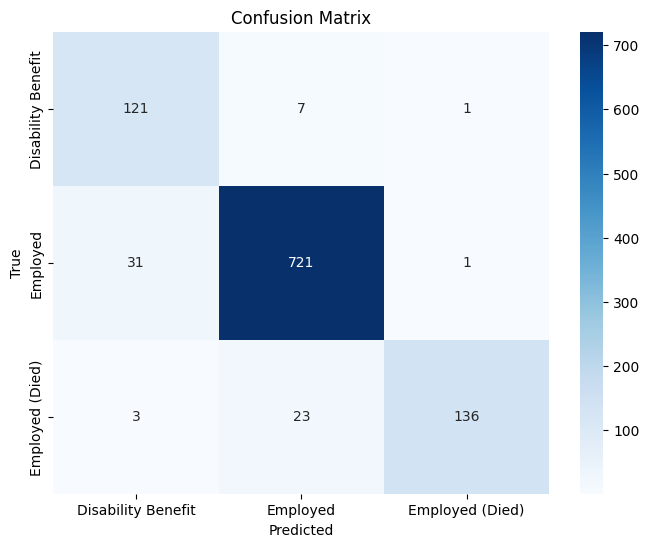


ROC AUC Score (OvR): 0.9468
ROC AUC Score (OvO): 0.9564

=== FINAL REPORT ===
Model: LSTM with 3 layers (128, 64 and 32 units)
Cross-validation: 5-fold stratified

Average Performance Across Folds:
- Balanced Accuracy: 0.9118 ± 0.0111
- Accuracy: 0.9368 ± 0.0072
- Cohen's Kappa: 0.8570 ± 0.0162
- Matthews Correlation: 0.8586 ± 0.0159
- ROC AUC (OvR): 0.9527 ± 0.0089
- ROC AUC (OvO): 0.9619 ± 0.0073

Class 0 (Disability Benefit):
- Precision: 0.7835 ± 0.0439
- Recall: 0.9382 ± 0.0185
- F1-score: 0.8527 ± 0.0191
- Accuracy: 0.9382 ± 0.0185

Class 1 (Employed):
- Precision: 0.9601 ± 0.0070
- Recall: 0.9575 ± 0.0136
- F1-score: 0.9588 ± 0.0066
- Accuracy: 0.9575 ± 0.0136

Class 2 (Employed (Died)):
- Precision: 0.9862 ± 0.0276
- Recall: 0.8396 ± 0.0353
- F1-score: 0.9064 ± 0.0234
- Accuracy: 0.8396 ± 0.0353

Confusion Matrix (All Predictions):
[[121   7   1]
 [ 31 721   1]
 [  3  23 136]]


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            accuracy_score, precision_recall_fscore_support,
                            confusion_matrix, roc_auc_score, cohen_kappa_score,
                            matthews_corrcoef)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from keras import backend as K

# --- Set Random Seeds for Reproducibility ---
random.seed(1927)
np.random.seed(1927)
tf.random.set_seed(1927)

# --- Data Loading and Preparation ---
data = pd.read_csv('sledatacutsdi.csv', parse_dates=['ASSDT'])
data = data[data['end_state'].isin(['Disability Benefit', 'Employed', "Employed (Died)"])]  # Three classes

# Feature Engineering
data['sdi_flare_interaction'] = data['score_n'] * data['total_flares']
data['flares_per_month'] = data['total_flares'] / (data['time_since_first']/30 + 1e-6)
data['delta_SLEDAI_Renal'] = data.groupby('PTNO')['SLEDAI_Renal'].diff().fillna(0)
data['time_between_visits'] = data.groupby('PTNO')['ASSDT'].diff().dt.days
data['visits_last_year'] = data.groupby('PTNO')['ASSDT'].transform(
    lambda x: x.apply(lambda d: ((x >= (d - pd.Timedelta(days=365))) & (x <= d)).sum())
)

# Select features
numeric_cols = [col for col in data.select_dtypes(include=['int64', 'float64']).columns
               if col not in ['PTNO', 'total_visits96', 'time_first_last96', 'total_visits',
                             'time_first_last','AMS_alt', 'first_change_index', 'time_since_first',
                             'time_since_last', 'ID', 'MAXSTEROIDDOSE', 'time_between96',
                             'early_retirement', 'DEATH', 'age_at_death', 'age_at_retirement',
                             'EMP_numeric', 'lupus_primary_death', 'visit_num96',
                             'lupus_secondary_death', 'time_to_first_change', 'cum_time']]

# --- Data Cleaning and Scaling ---
for col in numeric_cols:
    # Handle infinite values
    data[col] = data[col].replace([np.inf, -np.inf], np.nan)

    # Log-transform large values
    if data[col].max() > 1e6:
        data[col] = np.log1p(data[col])

    # Fill NaNs
    data[col] = data[col].fillna(0)

# Apply scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data['end_state_encoded'] = LabelEncoder().fit_transform(data['end_state'])

# --- Feature Selection with Random Forest ---
print("=== Feature Selection with Random Forest ===")

# Get MAXIMUM value for each patient
max_obs = data.groupby('PTNO')[numeric_cols].max()
y_labels = data.groupby('PTNO')['end_state_encoded'].last()  # Last outcome

# Train RF to get feature importances
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(max_obs, y_labels)

# Get top 20 features
importances = rf.feature_importances_
top_25_idx = np.argsort(importances)[-25:]
selected_features = [numeric_cols[i] for i in top_25_idx]

print("\nSelected Top 20 Features:")
for i, feat in enumerate(selected_features):
    print(f"{i+1}. {feat} (importance: {importances[top_25_idx][i]:.4f})")

# --- Prepare Sequences with Selected Features ---
def create_sequences(data, features, max_seq_length=None):
    patients = data['PTNO'].unique()
    if not max_seq_length:
        max_seq_length = data.groupby('PTNO').size().max()

    X_seq = np.zeros((len(patients), max_seq_length, len(features)))
    y = np.zeros(len(patients))

    for i, patient in enumerate(patients):
        patient_data = data[data['PTNO'] == patient].sort_values('ASSDT')
        seq_len = len(patient_data)
        X_seq[i, :seq_len, :] = patient_data[features].values
        y[i] = patient_data['end_state_encoded'].iloc[-1]

    return X_seq, to_categorical(y)

# Create sequences with only selected features
X_seq, y = create_sequences(data, selected_features)
y_labels = np.argmax(y, axis=1)

# --- Class Balance Analysis ---
print("\n=== Class Distribution ===")
class_counts = Counter(y_labels)
for class_label, count in class_counts.items():
    class_name = ['Disability Benefit', 'Employed', "Employed (Died)"][class_label]
    print(f"Class {class_label} ({class_name}): {count} samples ({count/len(y_labels):.2%})")

# --- Data Augmentation for Minority Class ---
def augment_minority_class(X, y, minority_class=2, augmentation_factor=5):
    """Augment minority class samples by adding small noise to existing samples"""
    minority_indices = np.where(np.argmax(y, axis=1) == minority_class)[0]
    X_minority = X[minority_indices]
    y_minority = y[minority_indices]

    if len(X_minority) == 0:
        return X, y

    augmented_X = [X]
    augmented_y = [y]

    for _ in range(augmentation_factor):
        noise = np.random.normal(0, 0.01, size=X_minority.shape)
        augmented_X.append(X_minority + noise)
        augmented_y.append(y_minority)

    augmented_X = np.concatenate(augmented_X)
    augmented_y = np.concatenate(augmented_y)

    return augmented_X, augmented_y

# Augment only if minority class exists
if 2 in y_labels:
    X_seq_aug, y_aug = augment_minority_class(X_seq, y)
    y_labels_aug = np.argmax(y_aug, axis=1)
    print("\nAfter augmentation:")
    for class_label, count in Counter(y_labels_aug).items():
        class_name = ['Disability Benefit', 'Employed', "Employed (Died)"][class_label]
        print(f"Class {class_label} ({class_name}): {count} samples ({count/len(y_labels_aug):.2%})")
else:
    X_seq_aug, y_aug = X_seq, y
    y_labels_aug = y_labels

# Verify shapes before training
print("\n=== Data Shapes ===")
print(f"X_seq_aug shape: {X_seq_aug.shape}")  # Should be (n_samples, seq_length, n_features)
print(f"y_aug shape: {y_aug.shape}")  # Should be (n_samples, n_classes)

import tensorflow as tf
def balanced_accuracy_metric(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true_classes = tf.argmax(y_true, axis=-1)

    num_classes = y_pred.shape[1]  # Requires static shape

    class_accs = []
    for class_id in range(num_classes):
        mask = tf.equal(y_true_classes, class_id)
        class_correct = tf.reduce_sum(
            tf.cast(tf.equal(y_pred_classes[mask], y_true_classes[mask]), tf.float32)
        )
        class_total = tf.reduce_sum(tf.cast(mask, tf.float32))
        class_acc = class_correct / (class_total + tf.keras.backend.epsilon())
        class_accs.append(class_acc)

    return tf.reduce_mean(class_accs)

# --- LSTM Model with Improved Architecture ---
def build_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Masking(mask_value=0)(inputs)

    # First LSTM layer with more units
    x = LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second LSTM layer
    x = LSTM(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Third LSTM layer
    x = LSTM(32)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Additional dense layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Custom metrics for imbalanced data
    metrics = [
        'accuracy',
        balanced_accuracy_metric,
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1_score', average='weighted')
    ]

    model.compile(optimizer=Adam(0.001),
                loss='categorical_crossentropy',
                metrics=metrics)

    return model

# --- LSTM Training with Selected Features ---
print("\n=== Training LSTM with Selected Features ===")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1927)

# Initialize metric storage
fold_metrics = {
    'precision_0': [], 'recall_0': [], 'f1_0': [],
    'precision_1': [], 'recall_1': [], 'f1_1': [],
    'precision_2': [], 'recall_2': [], 'f1_2': [],
    'bal_acc': [], 'acc': [], 'roc_auc_ovr': [], 'roc_auc_ovo': [],
    'kappa': [], 'mcc': []
}

class_accuracies = {0: [], 1: [], 2: []}  # To store accuracies for each class
all_y_true = []
all_y_pred = []
all_y_probs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_seq_aug, y_labels_aug)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train, X_val = X_seq_aug[train_idx], X_seq_aug[val_idx]
    y_train, y_val = y_aug[train_idx], y_aug[val_idx]
    y_train_labels = np.argmax(y_train, axis=1)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    # Build and train model
    model = build_lstm_model((X_seq_aug.shape[1], X_seq_aug.shape[2]), y_aug.shape[1])

    callbacks = [
        EarlyStopping(
            monitor='val_balanced_accuracy_metric',
            patience=20,
            restore_best_weights=True,
            min_delta=0.001,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_balanced_accuracy_metric',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1,
            mode='max'
        ),
        ModelCheckpoint(
            filepath=f'best_model_fold{fold}.h5',
            monitor='val_balanced_accuracy_metric',
            save_best_only=True,
            mode='max'
        )
    ]

    # Apply class weights through sample weights
    sample_weights = np.array([class_weight_dict[label] for label in y_train_labels])

    history = model.fit(
        X_train, y_train,
        epochs=300,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        shuffle=True,
        sample_weight=sample_weights  # Using sample_weight instead of class_weight
    )

    # Load the best model
    try:
        model = load_model(f'best_model_fold{fold}.h5',
                          custom_objects={'balanced_accuracy_metric': balanced_accuracy_metric})
    except:
        print(f"Could not load best model for fold {fold+1}, using last epoch's model")

    # Evaluate
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Store predictions for overall evaluation
    all_y_true.extend(y_true_classes)
    all_y_pred.extend(y_pred_classes)
    all_y_probs.extend(y_pred)

    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_true_classes, y_pred_classes)
    acc = accuracy_score(y_true_classes, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, zero_division=0)
    kappa = cohen_kappa_score(y_true_classes, y_pred_classes)
    mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

    # For multi-class ROC AUC
    if len(np.unique(y_true_classes)) > 2:
        try:
            roc_auc_ovr = roc_auc_score(y_true_classes, y_pred, multi_class='ovr')
            roc_auc_ovo = roc_auc_score(y_true_classes, y_pred, multi_class='ovo')
        except:
            roc_auc_ovr = np.nan
            roc_auc_ovo = np.nan

    # Store fold metrics
    for class_label in [0, 1, 2]:
        fold_metrics[f'precision_{class_label}'].append(precision[class_label] if class_label < len(precision) else np.nan)
        fold_metrics[f'recall_{class_label}'].append(recall[class_label] if class_label < len(recall) else np.nan)
        fold_metrics[f'f1_{class_label}'].append(f1[class_label] if class_label < len(f1) else np.nan)

    fold_metrics['bal_acc'].append(bal_acc)
    fold_metrics['acc'].append(acc)
    fold_metrics['kappa'].append(kappa)
    fold_metrics['mcc'].append(mcc)

    if len(np.unique(y_true_classes)) > 2:
        fold_metrics['roc_auc_ovr'].append(roc_auc_ovr)
        fold_metrics['roc_auc_ovo'].append(roc_auc_ovo)

    # Calculate and store accuracy for each class
    for class_label in [0, 1, 2]:
        class_mask = y_true_classes == class_label
        if sum(class_mask) > 0:
            class_acc = accuracy_score(y_true_classes[class_mask], y_pred_classes[class_mask])
            class_accuracies[class_label].append(class_acc)

    # Print fold results
    print(f"\nFold {fold + 1} Results:")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Matthews Correlation: {mcc:.4f}")
    if len(np.unique(y_true_classes)) > 2:
        print(f"ROC AUC (OvR): {roc_auc_ovr:.4f}")
        print(f"ROC AUC (OvO): {roc_auc_ovo:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                              target_names=['Disability Benefit', 'Employed', "Employed (Died)"],
                              zero_division=0))

    # Clean up model file
    try:
        os.remove(f'best_model_fold{fold}.h5')
    except:
        pass

# --- Final Evaluation ---
print("\n=== Final LSTM Evaluation ===")

# Calculate mean and std of all metrics
final_metrics = {k: (np.mean(v), np.std(v)) for k, v in fold_metrics.items() if len(v) > 0}

# Print averaged metrics
print("\n=== Average Performance Across All Folds ===")
print(f"Balanced Accuracy: {final_metrics['bal_acc'][0]:.4f} ± {final_metrics['bal_acc'][1]:.4f}")
print(f"Accuracy: {final_metrics['acc'][0]:.4f} ± {final_metrics['acc'][1]:.4f}")
print(f"Cohen's Kappa: {final_metrics['kappa'][0]:.4f} ± {final_metrics['kappa'][1]:.4f}")
print(f"Matthews Correlation: {final_metrics['mcc'][0]:.4f} ± {final_metrics['mcc'][1]:.4f}")
if 'roc_auc_ovr' in final_metrics:
    print(f"ROC AUC (OvR): {final_metrics['roc_auc_ovr'][0]:.4f} ± {final_metrics['roc_auc_ovr'][1]:.4f}")
    print(f"ROC AUC (OvO): {final_metrics['roc_auc_ovo'][0]:.4f} ± {final_metrics['roc_auc_ovo'][1]:.4f}")

print("\n=== Class-wise Average Performance ===")
for class_label in [0, 1, 2]:
    if len(class_accuracies.get(class_label, [])) > 0:
        print(f"\nClass {class_label}:")
        print(f"  Precision: {final_metrics[f'precision_{class_label}'][0]:.4f} ± {final_metrics[f'precision_{class_label}'][1]:.4f}")
        print(f"  Recall: {final_metrics[f'recall_{class_label}'][0]:.4f} ± {final_metrics[f'recall_{class_label}'][1]:.4f}")
        print(f"  F1-score: {final_metrics[f'f1_{class_label}'][0]:.4f} ± {final_metrics[f'f1_{class_label}'][1]:.4f}")
        print(f"  Accuracy: {np.mean(class_accuracies[class_label]):.4f} ± {np.std(class_accuracies[class_label]):.4f}")

# --- Comprehensive Evaluation on All Predictions ---
print("\n=== Comprehensive Evaluation on All Predictions ===")
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
all_y_probs = np.array(all_y_probs)

print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred,
                          target_names=['Disability Benefit', 'Employed', "Employed (Died)"],
                          zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_y_true, all_y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Disability Benefit', 'Employed', "Employed (Died)"],
            yticklabels=['Disability Benefit', 'Employed', "Employed (Died)"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

if len(np.unique(all_y_true)) > 2:
    try:
        print(f"\nROC AUC Score (OvR): {roc_auc_score(all_y_true, all_y_probs, multi_class='ovr'):.4f}")
        print(f"ROC AUC Score (OvO): {roc_auc_score(all_y_true, all_y_probs, multi_class='ovo'):.4f}")
    except:
        print("\nCould not calculate multi-class ROC AUC scores")

# --- Generate Final Report ---
print("\n=== FINAL REPORT ===")
print("Model: LSTM with 3 layers (128, 64 and 32 units)")
print(f"Cross-validation: {n_splits}-fold stratified")
print("\nAverage Performance Across Folds:")
print(f"- Balanced Accuracy: {final_metrics['bal_acc'][0]:.4f} ± {final_metrics['bal_acc'][1]:.4f}")
print(f"- Accuracy: {final_metrics['acc'][0]:.4f} ± {final_metrics['acc'][1]:.4f}")
print(f"- Cohen's Kappa: {final_metrics['kappa'][0]:.4f} ± {final_metrics['kappa'][1]:.4f}")
print(f"- Matthews Correlation: {final_metrics['mcc'][0]:.4f} ± {final_metrics['mcc'][1]:.4f}")
if 'roc_auc_ovr' in final_metrics:
    print(f"- ROC AUC (OvR): {final_metrics['roc_auc_ovr'][0]:.4f} ± {final_metrics['roc_auc_ovr'][1]:.4f}")
    print(f"- ROC AUC (OvO): {final_metrics['roc_auc_ovo'][0]:.4f} ± {final_metrics['roc_auc_ovo'][1]:.4f}")

for class_label in [0, 1, 2]:
    if len(class_accuracies.get(class_label, [])) > 0:
        class_name = ['Disability Benefit', 'Employed', "Employed (Died)"][class_label]
        print(f"\nClass {class_label} ({class_name}):")
        print(f"- Precision: {final_metrics[f'precision_{class_label}'][0]:.4f} ± {final_metrics[f'precision_{class_label}'][1]:.4f}")
        print(f"- Recall: {final_metrics[f'recall_{class_label}'][0]:.4f} ± {final_metrics[f'recall_{class_label}'][1]:.4f}")
        print(f"- F1-score: {final_metrics[f'f1_{class_label}'][0]:.4f} ± {final_metrics[f'f1_{class_label}'][1]:.4f}")
        print(f"- Accuracy: {np.mean(class_accuracies[class_label]):.4f} ± {np.std(class_accuracies[class_label]):.4f}")

print("\nConfusion Matrix (All Predictions):")
print(cm)

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score)
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_auc_score

# --- First, train and save the best model ---

# [Previous code remains the same until after model training]

# After cross-validation training, train a final model on all data
print("\n=== Training Final Model on All Data ===")
final_model = build_lstm_model((X_seq.shape[1], X_seq.shape[2]), y.shape[1])

# Callbacks for final training
final_callbacks = [
    EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_final_model.h5',
        monitor='accuracy',
        save_best_only=True,
        mode='max'
    )
]

# Train final model
history = final_model.fit(
    X_seq, y,
    epochs=300,
    batch_size=64,
    callbacks=final_callbacks,
    verbose=1,
    shuffle=True
)

# Load the best final model
try:
    final_model = load_model('best_final_model.h5', custom_objects=custom_objects)
    print("Successfully loaded best final model")
except Exception as e:
    print(f"Error loading final model: {e}")
    print("Using last epoch's model instead")


def assess_patient_risk_lstm_only(patient_data, model, temporal_features, max_seq_length, threshold=0.7):
    """
    Risk assessment using only LSTM model predictions
    Args:
        patient_data: DataFrame for one patient's visits
        model: Trained LSTM model
        temporal_features: List of temporal pattern features
        max_seq_length: Maximum sequence length model expects
        threshold: Risk threshold for flagging
    Returns:
        DataFrame with risk assessments for each visit
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction
        pred_proba = model.predict(seq_data, verbose=0)[0][0]

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'risk_score': pred_proba,
            'flagged': pred_proba >= threshold
        })

    return pd.DataFrame(risks)

def evaluate_patients(data, model, temporal_features, max_seq_length):
    """
    Evaluate all patients using LSTM-only approach
    Args:
        data: Full dataset with all patients
        model: Trained LSTM model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
    Returns:
        results_df: DataFrame with evaluation results
        timing_data: List of detection times
    """
    results = []
    timing_analysis = []

    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        # Get risk assessment
        risk_df = assess_patient_risk_lstm_only(
            patient_data,
            model,
            temporal_features,
            max_seq_length
        )

        # Record first time flagged (if any)
        first_flag = risk_df[risk_df['flagged']]['visit_date'].min()

        # For patients who became disabled
        if final_outcome == 0:  # Disability
            if pd.notna(first_flag):
                months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                timing_analysis.append(months_before)
            else:
                disability_date = patient_data['ASSDT'].iloc[-1]
                last_visit_date = patient_data['ASSDT'].iloc[-2] if len(patient_data) > 1 else disability_date
                months_after = (first_flag - disability_date).days / 30 if pd.notna(first_flag) else (disability_date - last_visit_date).days / 30
                timing_analysis.append(-months_after)

        # Store results
        results.append({
            'PTNO': ptno,
            'final_outcome': final_outcome,
            'ever_flagged': any(risk_df['flagged']),
            'first_flag_date': first_flag,
            'max_risk_score': risk_df['risk_score'].max(),
            'final_risk_score': risk_df['risk_score'].iloc[-1],
            'num_visits': len(patient_data)
        })

    return pd.DataFrame(results)



# Example Usage
if __name__ == "__main__":
    # Assuming you have these defined:
    # data = your patient data
    # final_model = your trained LSTM model
    # selected_features = your temporal features
    # X_seq = your sequence data (for getting max_seq_length)

    max_seq_length = X_seq.shape[1]  # Get sequence length from training data

    results_df = evaluate_patients(
        data,
        final_model,
        temporal_features=selected_features,
        max_seq_length=max_seq_length
    )




=== Training Final Model on All Data ===
Epoch 1/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3639 - auc: 0.5827 - balanced_accuracy_metric: 0.4182 - f1_score: 0.4496 - loss: 1.8176 - precision: 0.3479 - recall: 0.2653

15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.3675 - auc: 0.5878 - balanced_accuracy_metric: 0.4214 - f1_score: 0.4534 - loss: 1.8076 - precision: 0.3525 - recall: 0.2682 - learning_rate: 0.0010
Epoch 2/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5478 - auc: 0.7396 - balanced_accuracy_metric: 0.5619 - f1_score: 0.6339 - loss: 1.4066 - precision: 0.5821 - recall: 0.4042

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.5492 - auc: 0.7410 - balanced_accuracy_metric: 0.5633 - f1_score: 0.6350 - loss: 1.4016 - precision: 0.5845 - recall: 0.4052 - learning_rate: 0.0010
Epoch 3/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6941 - auc: 0.7958 - balanced_accuracy_metric: 0.6018 - f1_score: 0.7536 - loss: 1.1559 - precision: 0.7588 - recall: 0.5053

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.6954 - auc: 0.7952 - balanced_accuracy_metric: 0.6008 - f1_score: 0.7547 - loss: 1.1519 - precision: 0.7600 - recall: 0.5068 - learning_rate: 0.0010
Epoch 4/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8000 - auc: 0.8173 - balanced_accuracy_metric: 0.6365 - f1_score: 0.8304 - loss: 1.0502 - precision: 0.8578 - recall: 0.6141

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.8004 - auc: 0.8163 - balanced_accuracy_metric: 0.6356 - f1_score: 0.8307 - loss: 1.0450 - precision: 0.8579 - recall: 0.6156 - learning_rate: 0.0010
Epoch 5/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8281 - auc: 0.7836 - balanced_accuracy_metric: 0.5591 - f1_score: 0.8480 - loss: 0.9245 - precision: 0.8638 - recall: 0.7174

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.8286 - auc: 0.7845 - balanced_accuracy_metric: 0.5606 - f1_score: 0.8484 - loss: 0.9200 - precision: 0.8649 - recall: 0.7188 - learning_rate: 0.0010
Epoch 6/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8723 - auc: 0.8392 - balanced_accuracy_metric: 0.6619 - f1_score: 0.8811 - loss: 0.8200 - precision: 0.9139 - recall: 0.8271

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.8728 - auc: 0.8380 - balanced_accuracy_metric: 0.6606 - f1_score: 0.8814 - loss: 0.8153 - precision: 0.9143 - recall: 0.8270 - learning_rate: 0.0010
Epoch 7/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8821 - auc: 0.8073 - balanced_accuracy_metric: 0.6056 - f1_score: 0.8832 - loss: 0.7603 - precision: 0.8991 - recall: 0.8413

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.8826 - auc: 0.8076 - balanced_accuracy_metric: 0.6058 - f1_score: 0.8836 - loss: 0.7544 - precision: 0.9000 - recall: 0.8422 - learning_rate: 0.0010
Epoch 8/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8808 - auc: 0.7942 - balanced_accuracy_metric: 0.5755 - f1_score: 0.8787 - loss: 0.7364 - precision: 0.9059 - recall: 0.8431

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.8820 - auc: 0.7945 - balanced_accuracy_metric: 0.5767 - f1_score: 0.8796 - loss: 0.7294 - precision: 0.9069 - recall: 0.8446 - learning_rate: 0.0010
Epoch 9/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8971 - auc: 0.7928 - balanced_accuracy_metric: 0.5925 - f1_score: 0.8918 - loss: 0.6976 - precision: 0.9074 - recall: 0.8719

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 384ms/step - accuracy: 0.8977 - auc: 0.7929 - balanced_accuracy_metric: 0.5932 - f1_score: 0.8923 - loss: 0.6903 - precision: 0.9083 - recall: 0.8721 - learning_rate: 0.0010
Epoch 10/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.9002 - auc: 0.8647 - balanced_accuracy_metric: 0.5974 - f1_score: 0.8905 - loss: 0.6458 - precision: 0.9109 - recall: 0.8950 - learning_rate: 0.0010
Epoch 11/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9002 - auc: 0.8100 - balanced_accuracy_metric: 0.5862 - f1_score: 0.8917 - loss: 0.5852 - precision: 0.9086 - recall: 0.8926

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.9013 - auc: 0.8103 - balanced_accuracy_metric: 0.5882 - f1_score: 0.8928 - loss: 0.5799 - precision: 0.9098 - recall: 0.8936 - learning_rate: 0.0010
Epoch 12/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9092 - auc: 0.7908 - balanced_accuracy_metric: 0.6066 - f1_score: 0.8989 - loss: 0.5389 - precision: 0.9116 - recall: 0.8998

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.9100 - auc: 0.7924 - balanced_accuracy_metric: 0.6072 - f1_score: 0.8996 - loss: 0.5343 - precision: 0.9125 - recall: 0.9005 - learning_rate: 0.0010
Epoch 13/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.9064 - auc: 0.8530 - balanced_accuracy_metric: 0.5943 - f1_score: 0.8955 - loss: 0.5412 - precision: 0.9156 - recall: 0.8962 - learning_rate: 0.0010
Epoch 14/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.9000 - auc: 0.8109 - balanced_accuracy_metric: 0.5776 - f1_score: 0.8878 - loss: 0.4937 - precision: 0.9023 - recall: 0.8957 - learning_rate: 0.0010
Epoch 15/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.9079 - auc: 0.8301 - balanced_accuracy_metric: 0.5895 - f1_score: 0.8954 - loss: 0.4990 - precision: 0.9160 - recall: 0.8920 - learning_rate: 0.0010
Epoch 16/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.9103 - auc: 0.8393 - balanced_accuracy_metric: 0.6190 - f1_score: 0.9019 - lo

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.9174 - auc: 0.8576 - balanced_accuracy_metric: 0.6073 - f1_score: 0.9069 - loss: 0.3937 - precision: 0.9221 - recall: 0.9067 - learning_rate: 0.0010
Epoch 19/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.9153 - auc: 0.8242 - balanced_accuracy_metric: 0.6004 - f1_score: 0.9023 - loss: 0.3895 - precision: 0.9191 - recall: 0.9145 - learning_rate: 0.0010
Epoch 20/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9150 - auc: 0.8229 - balanced_accuracy_metric: 0.5968 - f1_score: 0.9025 - loss: 0.3894 - precision: 0.9148 - recall: 0.9090

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9160 - auc: 0.8242 - balanced_accuracy_metric: 0.5982 - f1_score: 0.9034 - loss: 0.3869 - precision: 0.9158 - recall: 0.9099 - learning_rate: 0.0010
Epoch 21/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - accuracy: 0.9108 - auc: 0.8593 - balanced_accuracy_metric: 0.5930 - f1_score: 0.8976 - loss: 0.3872 - precision: 0.9106 - recall: 0.9086 - learning_rate: 0.0010
Epoch 22/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.9089 - auc: 0.8279 - balanced_accuracy_metric: 0.5842 - f1_score: 0.8956 - loss: 0.3744 - precision: 0.9167 - recall: 0.9077 - learning_rate: 0.0010
Epoch 23/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9208 - auc: 0.8743 - balanced_accuracy_metric: 0.6081 - f1_score: 0.9076 - loss: 0.3572 - precision: 0.9232 - recall: 0.9166 - learning_rate: 0.0010
Epoch 24/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.9153 - auc: 0.8777 - balanced_accuracy_metric: 0.6053 - f1_score: 0.9033 - l

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9270 - auc: 0.8557 - balanced_accuracy_metric: 0.6078 - f1_score: 0.9131 - loss: 0.3234 - precision: 0.9301 - recall: 0.9211 - learning_rate: 0.0010
Epoch 29/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.9126 - auc: 0.8728 - balanced_accuracy_metric: 0.5991 - f1_score: 0.9012 - loss: 0.3185 - precision: 0.9193 - recall: 0.9122 - learning_rate: 0.0010
Epoch 30/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9211 - auc: 0.8725 - balanced_accuracy_metric: 0.6064 - f1_score: 0.9080 - loss: 0.3187 - precision: 0.9214 - recall: 0.9179

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9219 - auc: 0.8721 - balanced_accuracy_metric: 0.6074 - f1_score: 0.9088 - loss: 0.3168 - precision: 0.9223 - recall: 0.9188 - learning_rate: 0.0010
Epoch 31/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.9028 - auc: 0.9023 - balanced_accuracy_metric: 0.5613 - f1_score: 0.8881 - loss: 0.3319 - precision: 0.9113 - recall: 0.9028 - learning_rate: 0.0010
Epoch 32/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.9178 - auc: 0.8997 - balanced_accuracy_metric: 0.5860 - f1_score: 0.9035 - loss: 0.3126 - precision: 0.9200 - recall: 0.9167 - learning_rate: 0.0010
Epoch 33/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.9299 - auc: 0.8753 - balanced_accuracy_metric: 0.6143 - f1_score: 0.9186 - loss: 0.2890 - precision: 0.9343 - recall: 0.9294 - learning_rate: 0.0010
Epoch 34/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.9213 - auc: 0.8843 - balanced_accuracy_metric: 0.6085 - f1_score: 0.9095 - lo

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9315 - auc: 0.8815 - balanced_accuracy_metric: 0.6039 - f1_score: 0.9175 - loss: 0.2868 - precision: 0.9354 - recall: 0.9248 - learning_rate: 0.0010
Epoch 37/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.9261 - auc: 0.9170 - balanced_accuracy_metric: 0.5988 - f1_score: 0.9128 - loss: 0.2709 - precision: 0.9310 - recall: 0.9239 - learning_rate: 0.0010
Epoch 38/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.9285 - auc: 0.8931 - balanced_accuracy_metric: 0.6240 - f1_score: 0.9166 - loss: 0.2764 - precision: 0.9298 - recall: 0.9272 - learning_rate: 0.0010
Epoch 39/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9217 - auc: 0.9005 - balanced_accuracy_metric: 0.5959 - f1_score: 0.9094 - loss: 0.3007 - precision: 0.9244 - recall: 0.9195 - learning_rate: 0.0010
Epoch 40/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.9093 - auc: 0.9173 - balanced_accuracy_metric: 0.5856 - f1_score: 0.8960 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.9357 - auc: 0.9318 - balanced_accuracy_metric: 0.6324 - f1_score: 0.9243 - loss: 0.2522 - precision: 0.9357 - recall: 0.9357 - learning_rate: 0.0010
Epoch 47/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.9268 - auc: 0.9280 - balanced_accuracy_metric: 0.6223 - f1_score: 0.9180 - loss: 0.2573 - precision: 0.9274 - recall: 0.9253 - learning_rate: 0.0010
Epoch 48/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.9395 - auc: 0.9230 - balanced_accuracy_metric: 0.6486 - f1_score: 0.9303 - loss: 0.2421 - precision: 0.9404 - recall: 0.9395 - learning_rate: 0.0010
Epoch 49/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.9331 - auc: 0.9433 - balanced_accuracy_metric: 0.6116 - f1_score: 0.9208 - loss: 0.2340 - precision: 0.9344 - recall: 0.9331 - learning_rate: 0.0010
Epoch 50/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9458 - auc: 0.9522 - balanced_accuracy_metric: 0.6260 - f1_score: 0.9312 - lo

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.9461 - auc: 0.9516 - balanced_accuracy_metric: 0.6267 - f1_score: 0.9315 - loss: 0.2124 - precision: 0.9488 - recall: 0.9455 - learning_rate: 0.0010
Epoch 51/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9462 - auc: 0.9148 - balanced_accuracy_metric: 0.6962 - f1_score: 0.9383 - loss: 0.2247 - precision: 0.9468 - recall: 0.9412

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step - accuracy: 0.9467 - auc: 0.9159 - balanced_accuracy_metric: 0.6953 - f1_score: 0.9387 - loss: 0.2231 - precision: 0.9474 - recall: 0.9418 - learning_rate: 0.0010
Epoch 52/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.9467 - auc: 0.9506 - balanced_accuracy_metric: 0.6695 - f1_score: 0.9394 - loss: 0.2020 - precision: 0.9491 - recall: 0.9443 - learning_rate: 0.0010
Epoch 53/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.9401 - auc: 0.9256 - balanced_accuracy_metric: 0.6427 - f1_score: 0.9299 - loss: 0.2518 - precision: 0.9401 - recall: 0.9393 - learning_rate: 0.0010
Epoch 54/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.9366 - auc: 0.9229 - balanced_accuracy_metric: 0.6367 - f1_score: 0.9272 - loss: 0.2466 - precision: 0.9370 - recall: 0.9366 - learning_rate: 0.0010
Epoch 55/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.9353 - auc: 0.9379 - balanced_accuracy_metric: 0.6588 - f1_score: 0.9252 - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - accuracy: 0.9534 - auc: 0.9125 - balanced_accuracy_metric: 0.7186 - f1_score: 0.9465 - loss: 0.2266 - precision: 0.9532 - recall: 0.9489 - learning_rate: 5.0000e-04
Epoch 61/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.9531 - auc: 0.9657 - balanced_accuracy_metric: 0.6616 - f1_score: 0.9435 - loss: 0.1817 - precision: 0.9560 - recall: 0.9489 - learning_rate: 5.0000e-04
Epoch 62/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.9533 - auc: 0.9290 - balanced_accuracy_metric: 0.6912 - f1_score: 0.9456 - loss: 0.1897 - precision: 0.9536 - recall: 0.9533 - learning_rate: 5.0000e-04
Epoch 63/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.9437 - auc: 0.9522 - balanced_accuracy_metric: 0.6444 - f1_score: 0.9337 - loss: 0.1998 - precision: 0.9481 - recall: 0.9404 - learning_rate: 5.0000e-04
Epoch 64/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.9474 - auc: 0.9480 - balanced_accuracy_metric: 0.6486 - f1_s

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.9669 - auc: 0.9552 - balanced_accuracy_metric: 0.7462 - f1_score: 0.9610 - loss: 0.1749 - precision: 0.9669 - recall: 0.9669 - learning_rate: 5.0000e-04
Epoch 71/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.9537 - auc: 0.9589 - balanced_accuracy_metric: 0.6801 - f1_score: 0.9470 - loss: 0.1754 - precision: 0.9536 - recall: 0.9519 - learning_rate: 5.0000e-04
Epoch 72/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.9547 - auc: 0.9615 - balanced_accuracy_metric: 0.7153 - f1_score: 0.9481 - loss: 0.1812 - precision: 0.9546 - recall: 0.9524 - learning_rate: 5.0000e-04
Epoch 73/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.9475 - auc: 0.9549 - balanced_accuracy_metric: 0.6990 - f1_score: 0.9399 - loss: 0.1790 - precision: 0.9485 - recall: 0.9475 - learning_rate: 5.0000e-04
Epoch 74/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - accuracy: 0.9510 - auc: 0.9627 - balanced_accuracy_metric: 0.7243 - f1_s

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.9693 - auc: 0.9798 - balanced_accuracy_metric: 0.7624 - f1_score: 0.9645 - loss: 0.1297 - precision: 0.9693 - recall: 0.9682 - learning_rate: 2.5000e-04
Epoch 108/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.9664 - auc: 0.9813 - balanced_accuracy_metric: 0.7560 - f1_score: 0.9621 - loss: 0.1342 - precision: 0.9664 - recall: 0.9664 - learning_rate: 2.5000e-04
Epoch 109/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9742 - auc: 0.9790 - balanced_accuracy_metric: 0.8065 - f1_score: 0.9707 - loss: 0.1286 - precision: 0.9742 - recall: 0.9742

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9743 - auc: 0.9790 - balanced_accuracy_metric: 0.8063 - f1_score: 0.9708 - loss: 0.1284 - precision: 0.9743 - recall: 0.9743 - learning_rate: 2.5000e-04
Epoch 110/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.9622 - auc: 0.9843 - balanced_accuracy_metric: 0.6898 - f1_score: 0.9548 - loss: 0.1354 - precision: 0.9622 - recall: 0.9610 - learning_rate: 2.5000e-04
Epoch 111/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9775 - auc: 0.9760 - balanced_accuracy_metric: 0.8313 - f1_score: 0.9761 - loss: 0.1157 - precision: 0.9775 - recall: 0.9775

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.9775 - auc: 0.9754 - balanced_accuracy_metric: 0.8282 - f1_score: 0.9760 - loss: 0.1160 - precision: 0.9775 - recall: 0.9775 - learning_rate: 2.5000e-04
Epoch 112/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.9719 - auc: 0.9860 - balanced_accuracy_metric: 0.7933 - f1_score: 0.9690 - loss: 0.1204 - precision: 0.9719 - recall: 0.9709 - learning_rate: 2.5000e-04
Epoch 113/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 298ms/step - accuracy: 0.9656 - auc: 0.9763 - balanced_accuracy_metric: 0.7646 - f1_score: 0.9615 - loss: 0.1311 - precision: 0.9658 - recall: 0.9656 - learning_rate: 2.5000e-04
Epoch 114/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.9775 - auc: 0.9767 - balanced_accuracy_metric: 0.8385 - f1_score: 0.9755 - loss: 0.1143 - precision: 0.9775 - recall: 0.9775 - learning_rate: 2.5000e-04
Epoch 115/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.9721 - auc: 0.9857 - balanced_accuracy_metric: 0.8162 -

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.9765 - auc: 0.9880 - balanced_accuracy_metric: 0.7887 - f1_score: 0.9744 - loss: 0.1134 - precision: 0.9765 - recall: 0.9765 - learning_rate: 1.2500e-04
Epoch 140/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9759 - auc: 0.9673 - balanced_accuracy_metric: 0.8453 - f1_score: 0.9743 - loss: 0.1261 - precision: 0.9759 - recall: 0.9754 - learning_rate: 1.2500e-04
Epoch 141/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.9692 - auc: 0.9802 - balanced_accuracy_metric: 0.7434 - f1_score: 0.9625 - loss: 0.1210 - precision: 0.9691 - recall: 0.9683 - learning_rate: 1.2500e-04
Epoch 142/300
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9748 - auc: 0.9897 - balanced_accuracy_metric: 0.8219 - f1_score: 0.9722 - loss: 0.1114 - precision: 0.9747 - recall: 0.9714
Epoch 142: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.9748 - auc: 0.9897 - b


=== Disability Early Detection Performance ===
Using threshold: 0.9260
Early warning threshold: 0.6482

Average detection time (months): 50.3
Median detection time: 28.6
Detection rate: 115/129 (89.1%)

=== Disability Alert-Level Performance ===
Confusion Matrix:
[[763  17]
 [  8 121]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       780
           1       0.88      0.94      0.91       129

    accuracy                           0.97       909
   macro avg       0.93      0.96      0.95       909
weighted avg       0.97      0.97      0.97       909


=== Disability Warning-Level Performance ===
Confusion Matrix:
[[761  19]
 [  7 122]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       780
           1       0.87      0.95      0.90       129

    accuracy                           0.97       909
   macro avg       0.93      0.9

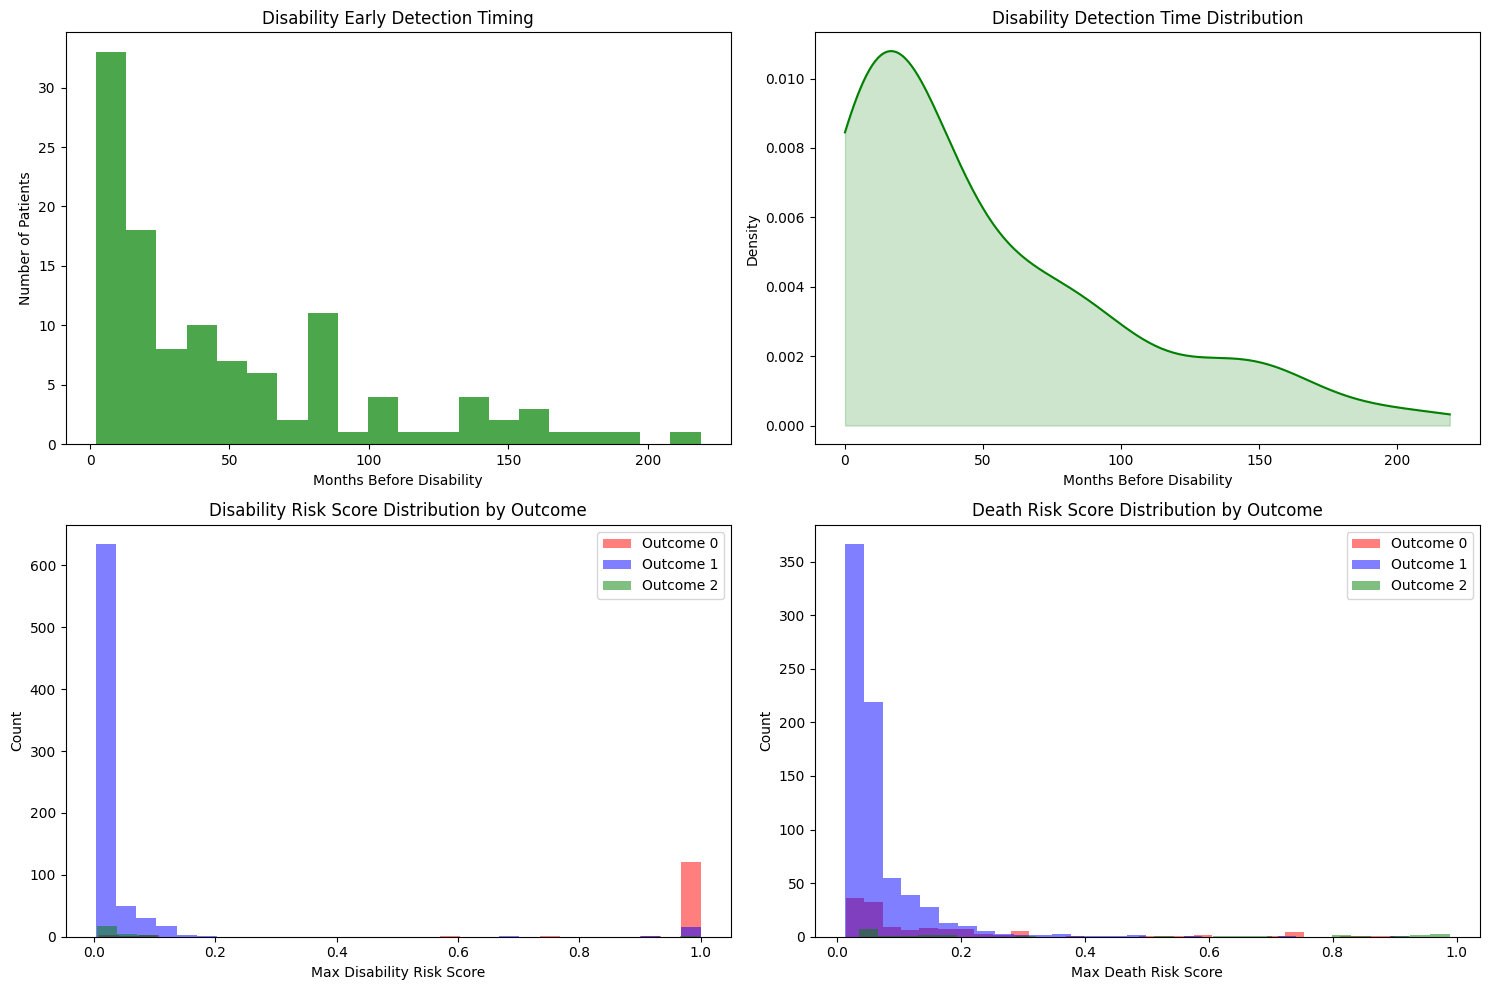

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_auc_score, precision_recall_curve,
                           average_precision_score, roc_curve)
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def find_early_detection_threshold(y_true, y_scores, timing_data=None, min_sensitivity=0.9):
    """
    Find threshold that optimizes for early detection while maintaining sensitivity
    Args:
        y_true: True labels
        y_scores: Predicted probabilities
        timing_data: List of detection times (negative for missed cases)
        min_sensitivity: Minimum sensitivity to maintain
    Returns:
        optimal_threshold: Threshold that maximizes early detection
        detection_stats: Dictionary with detection statistics
    """
    # Calculate ROC curve metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filter thresholds that meet minimum sensitivity
    valid_idx = np.where(tpr >= min_sensitivity)[0]
    if len(valid_idx) == 0:
        return 0.5, {}  # Fallback if no threshold meets sensitivity

    # Get subset of thresholds that meet sensitivity
    valid_thresholds = thresholds[valid_idx]
    valid_tpr = tpr[valid_idx]

    # If no timing data, just return the threshold with highest sensitivity
    if timing_data is None:
        best_idx = np.argmax(valid_tpr)
        optimal_threshold = valid_thresholds[best_idx]
        return optimal_threshold, {}

    # For each candidate threshold, calculate detection timing
    detection_stats = []
    for thresh in valid_thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        detected_times = [t for t in timing_data if t > 0]
        avg_detection_time = np.mean(detected_times) if detected_times else 0
        detection_rate = len(detected_times) / sum(y_true)

        detection_stats.append({
            'threshold': thresh,
            'sensitivity': valid_tpr[np.where(valid_thresholds == thresh)[0][0]],
            'avg_detection_time': avg_detection_time,
            'detection_rate': detection_rate
        })

    # Select threshold with best (earliest) average detection time
    detection_stats = pd.DataFrame(detection_stats)
    best_idx = detection_stats['avg_detection_time'].idxmax()
    optimal_threshold = detection_stats.loc[best_idx, 'threshold']

    return optimal_threshold, detection_stats

def assess_patient_risk_with_early_warning(patient_data, model, temporal_features,
                                         max_seq_length, disability_threshold=0.15,
                                         death_threshold=0.15, early_warning_factor=0.7):
    """
    Enhanced risk assessment with separate early warning signals for disability and death
    Args:
        patient_data: DataFrame for one patient's visits
        model: Trained LSTM model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
        disability_threshold: Main risk threshold for disability
        death_threshold: Main risk threshold for death
        early_warning_factor: Fraction of main threshold for early warning
    Returns:
        DataFrame with risk assessments and warning flags for both outcomes
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')
    disability_warning_threshold = disability_threshold * early_warning_factor
    death_warning_threshold = death_threshold * early_warning_factor

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction probabilities for all classes
        pred_probas = model.predict(seq_data, verbose=0)[0]

        # Class 0 is disability, class 2 is death (assuming your encoding)
        disability_prob = pred_probas[0]
        death_prob = pred_probas[2]

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'disability_risk': disability_prob,
            'death_risk': death_prob,
            'disability_flagged': disability_prob >= disability_threshold,
            'death_flagged': death_prob >= death_threshold,
            'disability_warning': disability_prob >= disability_warning_threshold,
            'death_warning': death_prob >= death_warning_threshold
        })

    return pd.DataFrame(risks)

def evaluate_patients_with_early_detection(data, model, temporal_features,
                                         max_seq_length, timing_data=None):
    """
    Enhanced evaluation with separate tracking for disability and death outcomes
    Args:
        data: Full dataset
        model: Trained model
        temporal_features: List of temporal features
        max_seq_length: Maximum sequence length
        timing_data: Optional existing timing data (dict with 'disability' and 'death' keys)
    Returns:
        results_df: Evaluation results
        timing_data: Detection timing (dict with both outcomes)
        thresholds: Dictionary with optimal thresholds
        detection_stats: Dictionary with detection statistics
    """
    results = []
    timing_analysis = {
        'disability': [],
        'death': []
    }
    all_scores = {
        'disability': [],
        'death': []
    }
    all_outcomes = {
        'disability': [],
        'death': []
    }

    # First pass to collect all scores and outcomes
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        # Get risk assessment
        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            disability_threshold=0.5,  # Temporary thresholds
            death_threshold=0.5
        )

        # Store max scores and outcomes for both conditions
        all_scores['disability'].append(risk_df['disability_risk'].max())
        all_scores['death'].append(risk_df['death_risk'].max())

        all_outcomes['disability'].append(final_outcome == 0)  # Disability
        all_outcomes['death'].append(final_outcome == 2)      # Death

    # Find optimal thresholds for both outcomes
    thresholds = {}
    detection_stats = {}

    # For disability
    y_true_disability = np.array(all_outcomes['disability']).astype(int)
    y_scores_disability = np.array(all_scores['disability'])

    # Get timing data if not provided
    if timing_data is None or 'disability' not in timing_data:
        disability_timing = []
        for ptno, patient_data in data.groupby('PTNO'):
            patient_data = patient_data.sort_values('ASSDT')
            final_outcome = patient_data['end_state_encoded'].iloc[-1]

            if final_outcome == 0:  # Disability cases only
                risk_df = assess_patient_risk_with_early_warning(
                    patient_data,
                    model,
                    temporal_features,
                    max_seq_length
                )

                first_flag = risk_df[risk_df['disability_flagged']]['visit_date'].min()
                if pd.notna(first_flag):
                    months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                    disability_timing.append(months_before)
                else:
                    disability_date = patient_data['ASSDT'].iloc[-1]
                    last_visit_date = patient_data['ASSDT'].iloc[-2] if len(patient_data) > 1 else disability_date
                    months_after = (disability_date - last_visit_date).days / 30
                    disability_timing.append(-months_after)
        timing_analysis['disability'] = disability_timing
    else:
        timing_analysis['disability'] = timing_data['disability']

    # Find optimal threshold for disability
    thresholds['disability'], detection_stats['disability'] = find_early_detection_threshold(
        y_true_disability, y_scores_disability, timing_analysis['disability']
    )

    # For death - typically we don't have timing data for death (can't detect after event)
    y_true_death = np.array(all_outcomes['death']).astype(int)
    y_scores_death = np.array(all_scores['death'])

    # Find threshold that maximizes sensitivity for death
    thresholds['death'], detection_stats['death'] = find_early_detection_threshold(
        y_true_death, y_scores_death, min_sensitivity=0.9
    )

    # Second pass with optimal thresholds and early warning
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        # Get risk assessment with early warning
        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            disability_threshold=thresholds['disability'],
            death_threshold=thresholds['death']
        )

        # Record first time flagged (if any) for both outcomes
        first_disability_flag = risk_df[risk_df['disability_flagged']]['visit_date'].min()
        first_death_flag = risk_df[risk_df['death_flagged']]['visit_date'].min()

        first_disability_warning = risk_df[risk_df['disability_warning']]['visit_date'].min()
        first_death_warning = risk_df[risk_df['death_warning']]['visit_date'].min()

        # Store results
        results.append({
            'PTNO': ptno,
            'final_outcome': final_outcome,
            'ever_disability_flagged': any(risk_df['disability_flagged']),
            'ever_death_flagged': any(risk_df['death_flagged']),
            'ever_disability_warned': any(risk_df['disability_warning']),
            'ever_death_warned': any(risk_df['death_warning']),
            'first_disability_flag_date': first_disability_flag,
            'first_death_flag_date': first_death_flag,
            'first_disability_warning_date': first_disability_warning,
            'first_death_warning_date': first_death_warning,
            'max_disability_risk': risk_df['disability_risk'].max(),
            'max_death_risk': risk_df['death_risk'].max(),
            'final_disability_risk': risk_df['disability_risk'].iloc[-1],
            'final_death_risk': risk_df['death_risk'].iloc[-1],
            'num_visits': len(patient_data)
        })

    return pd.DataFrame(results), timing_analysis, thresholds, detection_stats

def analyze_early_detection_results(results_df, timing_data, thresholds, detection_stats):
    """
    Enhanced analysis with separate metrics for disability and death outcomes
    """
    # Disability analysis
    disability_true = (results_df['final_outcome'] == 0).astype(int)
    disability_pred_alert = results_df['ever_disability_flagged'].astype(int)
    disability_pred_warning = results_df['ever_disability_warned'].astype(int)
    disability_scores = results_df['max_disability_risk']

    # Death analysis
    death_true = (results_df['final_outcome'] == 2).astype(int)
    death_pred_alert = results_df['ever_death_flagged'].astype(int)
    death_pred_warning = results_df['ever_death_warned'].astype(int)
    death_scores = results_df['max_death_risk']

    # Convert timing data to arrays
    disability_timing = np.array(timing_data['disability'])
    disability_detections = disability_timing[disability_timing > 0]

    print("\n=== Disability Early Detection Performance ===")
    print(f"Using threshold: {thresholds['disability']:.4f}")
    print(f"Early warning threshold: {thresholds['disability']*0.7:.4f}")

    if len(disability_detections) > 0:
        print(f"\nAverage detection time (months): {np.mean(disability_detections):.1f}")
        print(f"Median detection time: {np.median(disability_detections):.1f}")
        print(f"Detection rate: {len(disability_detections)}/{sum(disability_true)} ({len(disability_detections)/sum(disability_true):.1%})")
    else:
        print("\nNo positive detections for disability")

    print("\n=== Disability Alert-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(disability_true, disability_pred_alert))
    print("\nClassification Report:")
    print(classification_report(disability_true, disability_pred_alert))

    print("\n=== Disability Warning-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(disability_true, disability_pred_warning))
    print("\nClassification Report:")
    print(classification_report(disability_true, disability_pred_warning))

    print(f"\nROC AUC: {roc_auc_score(disability_true, disability_scores):.4f}")
    print(f"Average Precision: {average_precision_score(disability_true, disability_scores):.4f}")

    # Death analysis
    print("\n=== Death Detection Performance ===")
    print(f"Using threshold: {thresholds['death']:.4f}")
    print(f"Early warning threshold: {thresholds['death']*0.7:.4f}")

    print("\n=== Death Alert-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(death_true, death_pred_alert))
    print("\nClassification Report:")
    print(classification_report(death_true, death_pred_alert))

    print("\n=== Death Warning-Level Performance ===")
    print("Confusion Matrix:")
    print(confusion_matrix(death_true, death_pred_warning))
    print("\nClassification Report:")
    print(classification_report(death_true, death_pred_warning))

    print(f"\nROC AUC: {roc_auc_score(death_true, death_scores):.4f}")
    print(f"Average Precision: {average_precision_score(death_true, death_scores):.4f}")

    # Plotting
    plt.figure(figsize=(15, 10))

    # Disability detection time distribution
    if len(disability_detections) > 0:
        plt.subplot(2, 2, 1)
        plt.hist(disability_detections, bins=20, color='green', alpha=0.7)
        plt.xlabel('Months Before Disability')
        plt.ylabel('Number of Patients')
        plt.title('Disability Early Detection Timing')

        plt.subplot(2, 2, 2)
        density = gaussian_kde(disability_detections)
        xs = np.linspace(0, max(disability_detections), 200)
        plt.plot(xs, density(xs), color='green')
        plt.fill_between(xs, density(xs), color='green', alpha=0.2)
        plt.xlabel('Months Before Disability')
        plt.ylabel('Density')
        plt.title('Disability Detection Time Distribution')

    # Risk score distributions
    plt.subplot(2, 2, 3)
    for outcome, color in zip([0, 1, 2], ['red', 'blue', 'green']):
        subset = results_df[results_df['final_outcome'] == outcome]
        plt.hist(subset['max_disability_risk'], bins=30, alpha=0.5, color=color,
                label=f'Outcome {outcome}')
    plt.xlabel('Max Disability Risk Score')
    plt.ylabel('Count')
    plt.title('Disability Risk Score Distribution by Outcome')
    plt.legend()

    plt.subplot(2, 2, 4)
    for outcome, color in zip([0, 1, 2], ['red', 'blue', 'green']):
        subset = results_df[results_df['final_outcome'] == outcome]
        plt.hist(subset['max_death_risk'], bins=30, alpha=0.5, color=color,
                label=f'Outcome {outcome}')
    plt.xlabel('Max Death Risk Score')
    plt.ylabel('Count')
    plt.title('Death Risk Score Distribution by Outcome')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Assuming you have these defined:
    # data = your patient data
    # final_model = your trained LSTM model
    # selected_features = your temporal features
    # X_seq = your sequence data (for getting max_seq_length)

    max_seq_length = X_seq.shape[1]

    # Run evaluation with early detection focus
    results_df, timing_data, thresholds, det_stats = evaluate_patients_with_early_detection(
        data,
        final_model,
        temporal_features=selected_features,
        max_seq_length=max_seq_length
    )

    # Analyze results
    analyze_early_detection_results(results_df, timing_data, thresholds, det_stats)


=== Disability Early Detection Performance ===
Using threshold: 0.9260
Early warning threshold: 0.6482

Average detection time (months): 50.3
Median detection time: 28.6
Detection rate: 115/129 (89.1%)

Confusion Matrix (Disability):
[[763  17]
 [  8 121]]

Classification Report (Disability):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       780
           1       0.88      0.94      0.91       129

    accuracy                           0.97       909
   macro avg       0.93      0.96      0.95       909
weighted avg       0.97      0.97      0.97       909


ROC AUC: 0.9803
Average Precision: 0.8872

=== Improved Death Detection Performance ===
Using balanced threshold: 0.0589
Early warning threshold: 0.0412

Confusion Matrix (Death):
[[586 296]
 [  4  23]]

Classification Report (Death):
              precision    recall  f1-score   support

           0       0.99      0.66      0.80       882
           1       0.07      0.85

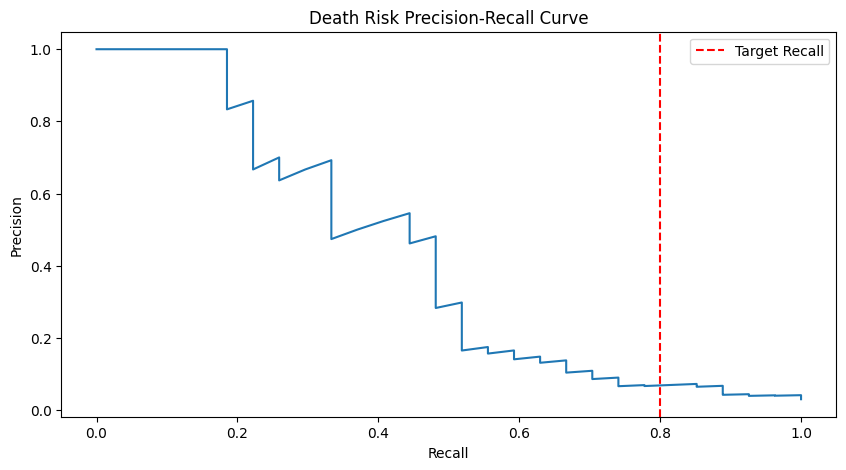

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_auc_score, precision_recall_curve,
                           average_precision_score, roc_curve,
                           precision_score, recall_score)  # Added imports here
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for handling class imbalance
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

def find_balanced_threshold(y_true, y_scores, min_recall=0.8):
    """
    Find threshold that maintains minimum recall while maximizing precision
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    # Find threshold that maintains min recall while maximizing precision
    valid_idx = np.where(recalls >= min_recall)[0]
    if len(valid_idx) > 0:
        best_idx = np.argmax(precisions[valid_idx])
        return thresholds[best_idx]
    return 0.5

def find_early_detection_threshold(y_true, y_scores, timing_data=None, min_sensitivity=0.9):
    """
    Find threshold that optimizes for early detection while maintaining sensitivity
    """
    # Calculate ROC curve metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Filter thresholds that meet minimum sensitivity
    valid_idx = np.where(tpr >= min_sensitivity)[0]
    if len(valid_idx) == 0:
        return 0.5, {}  # Fallback if no threshold meets sensitivity

    # Get subset of thresholds that meet sensitivity
    valid_thresholds = thresholds[valid_idx]
    valid_tpr = tpr[valid_idx]

    # If no timing data, just return the threshold with highest sensitivity
    if timing_data is None:
        best_idx = np.argmax(valid_tpr)
        optimal_threshold = valid_thresholds[best_idx]
        return optimal_threshold, {}

    # For each candidate threshold, calculate detection timing
    detection_stats = []
    for thresh in valid_thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        detected_times = [t for t in timing_data if t > 0]
        avg_detection_time = np.mean(detected_times) if detected_times else 0
        detection_rate = len(detected_times) / sum(y_true)

        detection_stats.append({
            'threshold': thresh,
            'sensitivity': valid_tpr[np.where(valid_thresholds == thresh)[0][0]],
            'avg_detection_time': avg_detection_time,
            'detection_rate': detection_rate
        })

    # Select threshold with best (earliest) average detection time
    detection_stats = pd.DataFrame(detection_stats)
    best_idx = detection_stats['avg_detection_time'].idxmax()
    optimal_threshold = detection_stats.loc[best_idx, 'threshold']

    return optimal_threshold, detection_stats

def assess_patient_risk_with_early_warning(patient_data, model, temporal_features,
                                         max_seq_length, disability_threshold=0.15,
                                         death_threshold=0.15, early_warning_factor=0.7):
    """
    Enhanced risk assessment with separate early warning signals
    """
    risks = []
    patient_data = patient_data.sort_values('ASSDT')
    disability_warning_threshold = disability_threshold * early_warning_factor
    death_warning_threshold = death_threshold * early_warning_factor

    for i in range(1, len(patient_data)+1):
        current_visit = patient_data.iloc[:i]
        current_row = current_visit.iloc[-1]

        # Prepare sequence data
        seq_len = len(current_visit)
        seq_data = np.zeros((1, max_seq_length, len(temporal_features)))
        seq_data[0, :seq_len, :] = current_visit[temporal_features].values

        # Get prediction probabilities for all classes
        pred_probas = model.predict(seq_data, verbose=0)[0]

        # Class 0 is disability, class 2 is death
        disability_prob = pred_probas[0]
        death_prob = pred_probas[2]

        risks.append({
            'visit_date': current_row['ASSDT'],
            'visit_number': i,
            'disability_risk': disability_prob,
            'death_risk': death_prob,
            'disability_flagged': disability_prob >= disability_threshold,
            'death_flagged': death_prob >= death_threshold,
            'disability_warning': disability_prob >= disability_warning_threshold,
            'death_warning': death_prob >= death_warning_threshold
        })

    return pd.DataFrame(risks)

def evaluate_patients_with_early_detection(data, model, temporal_features,
                                         max_seq_length, timing_data=None):
    """
    Enhanced evaluation with improved death modeling
    """
    results = []
    timing_analysis = {
        'disability': [],
        'death': []
    }
    all_scores = {
        'disability': [],
        'death': []
    }
    all_outcomes = {
        'disability': [],
        'death': []
    }

    # First pass to collect all scores and outcomes
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            disability_threshold=0.5,
            death_threshold=0.5
        )

        all_scores['disability'].append(risk_df['disability_risk'].max())
        all_scores['death'].append(risk_df['death_risk'].max())
        all_outcomes['disability'].append(final_outcome == 0)
        all_outcomes['death'].append(final_outcome == 2)

    # Find optimal thresholds
    thresholds = {}
    detection_stats = {}

    # For disability (original approach works well)
    y_true_disability = np.array(all_outcomes['disability']).astype(int)
    y_scores_disability = np.array(all_scores['disability'])

    if timing_data is None or 'disability' not in timing_data:
        disability_timing = []
        for ptno, patient_data in data.groupby('PTNO'):
            patient_data = patient_data.sort_values('ASSDT')
            final_outcome = patient_data['end_state_encoded'].iloc[-1]

            if final_outcome == 0:
                risk_df = assess_patient_risk_with_early_warning(
                    patient_data,
                    model,
                    temporal_features,
                    max_seq_length
                )

                first_flag = risk_df[risk_df['disability_flagged']]['visit_date'].min()
                if pd.notna(first_flag):
                    months_before = (patient_data['ASSDT'].iloc[-1] - first_flag).days / 30
                    disability_timing.append(months_before)
                else:
                    disability_date = patient_data['ASSDT'].iloc[-1]
                    last_visit_date = patient_data['ASSDT'].iloc[-2] if len(patient_data) > 1 else disability_date
                    months_after = (disability_date - last_visit_date).days / 30
                    disability_timing.append(-months_after)
        timing_analysis['disability'] = disability_timing
    else:
        timing_analysis['disability'] = timing_data['disability']

    thresholds['disability'], detection_stats['disability'] = find_early_detection_threshold(
        y_true_disability, y_scores_disability, timing_analysis['disability']
    )

    # For death - use balanced approach
    y_true_death = np.array(all_outcomes['death']).astype(int)
    y_scores_death = np.array(all_scores['death'])

    thresholds['death'] = find_balanced_threshold(y_true_death, y_scores_death, min_recall=0.8)
    detection_stats['death'] = {
        'threshold': thresholds['death'],
        'precision': precision_score(y_true_death, y_scores_death >= thresholds['death']),
        'recall': recall_score(y_true_death, y_scores_death >= thresholds['death'])
    }

    # Second pass with optimal thresholds
    for ptno, patient_data in data.groupby('PTNO'):
        patient_data = patient_data.sort_values('ASSDT')
        final_outcome = patient_data['end_state_encoded'].iloc[-1]

        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            model,
            temporal_features,
            max_seq_length,
            disability_threshold=thresholds['disability'],
            death_threshold=thresholds['death']
        )

        first_disability_flag = risk_df[risk_df['disability_flagged']]['visit_date'].min()
        first_death_flag = risk_df[risk_df['death_flagged']]['visit_date'].min()
        first_disability_warning = risk_df[risk_df['disability_warning']]['visit_date'].min()
        first_death_warning = risk_df[risk_df['death_warning']]['visit_date'].min()

        results.append({
            'PTNO': ptno,
            'final_outcome': final_outcome,
            'ever_disability_flagged': any(risk_df['disability_flagged']),
            'ever_death_flagged': any(risk_df['death_flagged']),
            'ever_disability_warned': any(risk_df['disability_warning']),
            'ever_death_warned': any(risk_df['death_warning']),
            'first_disability_flag_date': first_disability_flag,
            'first_death_flag_date': first_death_flag,
            'first_disability_warning_date': first_disability_warning,
            'first_death_warning_date': first_death_warning,
            'max_disability_risk': risk_df['disability_risk'].max(),
            'max_death_risk': risk_df['death_risk'].max(),
            'final_disability_risk': risk_df['disability_risk'].iloc[-1],
            'final_death_risk': risk_df['death_risk'].iloc[-1],
            'num_visits': len(patient_data)
        })

    return pd.DataFrame(results), timing_analysis, thresholds, detection_stats

def analyze_results_with_improved_death_model(results_df, timing_data, thresholds, detection_stats):
    """
    Enhanced analysis with better death modeling metrics
    """
    # Disability analysis (unchanged)
    disability_true = (results_df['final_outcome'] == 0).astype(int)
    disability_pred_alert = results_df['ever_disability_flagged'].astype(int)
    disability_scores = results_df['max_disability_risk']

    # Death analysis with improved metrics
    death_true = (results_df['final_outcome'] == 2).astype(int)
    death_pred_alert = results_df['ever_death_flagged'].astype(int)
    death_scores = results_df['max_death_risk']

    print("\n=== Disability Early Detection Performance ===")
    print(f"Using threshold: {thresholds['disability']:.4f}")
    print(f"Early warning threshold: {thresholds['disability']*0.7:.4f}")

    disability_timing = np.array(timing_data['disability'])
    disability_detections = disability_timing[disability_timing > 0]

    if len(disability_detections) > 0:
        print(f"\nAverage detection time (months): {np.mean(disability_detections):.1f}")
        print(f"Median detection time: {np.median(disability_detections):.1f}")
        print(f"Detection rate: {len(disability_detections)}/{sum(disability_true)} ({len(disability_detections)/sum(disability_true):.1%})")

    print("\nConfusion Matrix (Disability):")
    print(confusion_matrix(disability_true, disability_pred_alert))
    print("\nClassification Report (Disability):")
    print(classification_report(disability_true, disability_pred_alert))
    print(f"\nROC AUC: {roc_auc_score(disability_true, disability_scores):.4f}")
    print(f"Average Precision: {average_precision_score(disability_true, disability_scores):.4f}")

    print("\n=== Improved Death Detection Performance ===")
    print(f"Using balanced threshold: {thresholds['death']:.4f}")
    print(f"Early warning threshold: {thresholds['death']*0.7:.4f}")

    print("\nConfusion Matrix (Death):")
    print(confusion_matrix(death_true, death_pred_alert))
    print("\nClassification Report (Death):")
    print(classification_report(death_true, death_pred_alert))
    print(f"\nROC AUC: {roc_auc_score(death_true, death_scores):.4f}")
    print(f"Average Precision: {average_precision_score(death_true, death_scores):.4f}")

    # Plot precision-recall curve for death
    precision, recall, _ = precision_recall_curve(death_true, death_scores)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Death Risk Precision-Recall Curve')
    plt.axvline(x=0.8, color='r', linestyle='--', label='Target Recall')
    plt.legend()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Assuming you have these defined:
    # data = your patient data
    # final_model = your trained LSTM model
    # selected_features = your temporal features
    # X_seq = your sequence data (for getting max_seq_length)

    max_seq_length = X_seq.shape[1]

    # Run evaluation with improved death modeling
    results_df, timing_data, thresholds, det_stats = evaluate_patients_with_early_detection(
        data,
        final_model,
        temporal_features=selected_features,
        max_seq_length=max_seq_length
    )

    # Analyze results
    analyze_results_with_improved_death_model(results_df, timing_data, thresholds, det_stats)

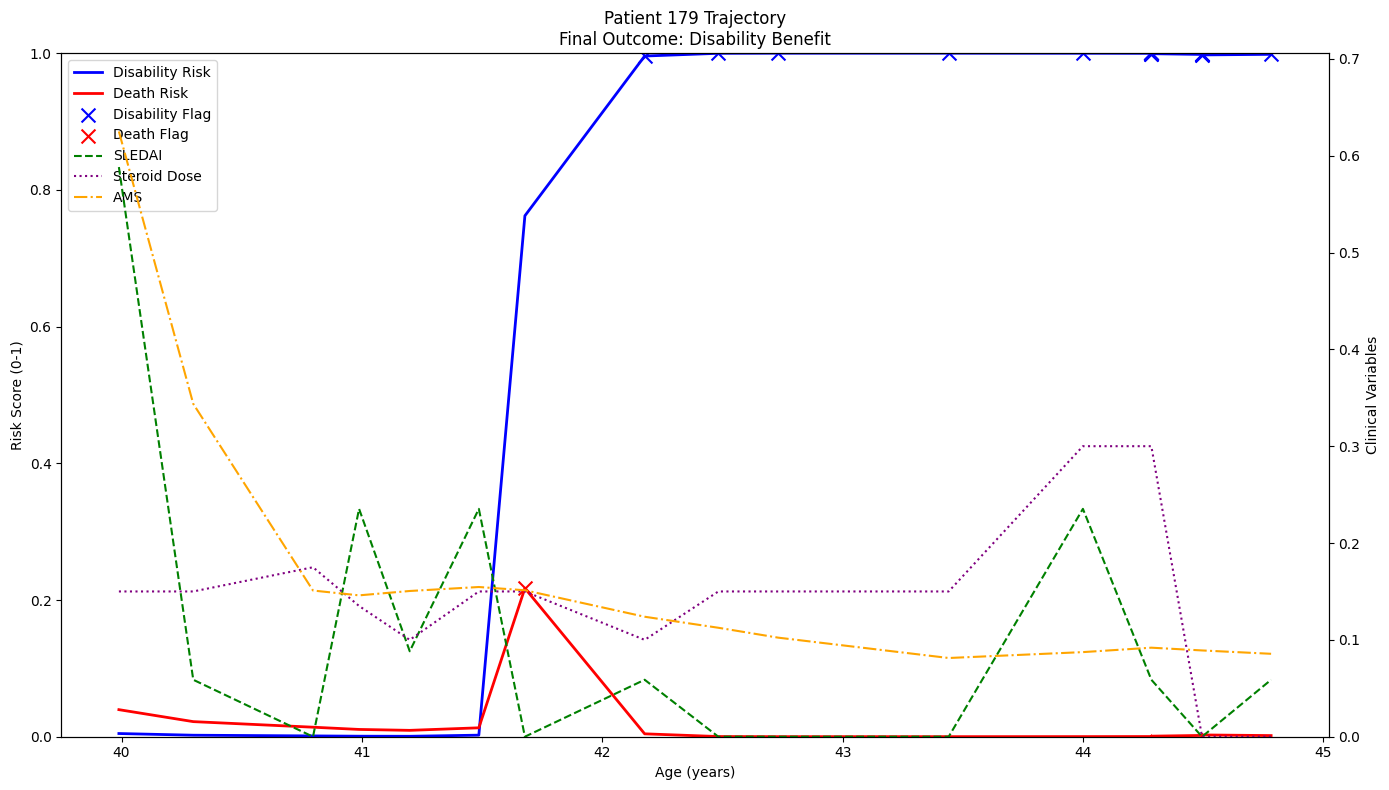

In [6]:
def plot_patient_trajectory(patient_data, risk_df, ptno):
    """
    Plot individual patient trajectory with risk scores (left axis) and
    clinical variables (right axis) on a single plot.
    """
    # Data preparation
    patient_data = patient_data.copy()
    risk_df = risk_df.copy()

    # Convert and merge data
    patient_data['ASSDT'] = pd.to_datetime(patient_data['ASSDT'])
    risk_df['visit_date'] = pd.to_datetime(risk_df['visit_date'])
    merged = pd.merge(patient_data, risk_df,
                    left_on='ASSDT',
                    right_on='visit_date',
                    how='left')

    # Calculate patient age
    birth_date = pd.to_datetime(merged['BIRTHDT'].iloc[0])
    merged['age'] = (merged['ASSDT'] - birth_date).dt.days / 365.25

    # Create figure with dual axes
    fig, ax = plt.subplots(figsize=(14, 8))
    ax_right = ax.twinx()

    # Plot risk scores on left axis
    ax.plot(merged['age'], merged['disability_risk'],
           label='Disability Risk', color='blue', linewidth=2)
    ax.plot(merged['age'], merged['death_risk'],
           label='Death Risk', color='red', linewidth=2)

    # Plot clinical variables on right axis
    if 'SLEDAI2_I' in merged.columns:
        ax_right.plot(merged['age'], merged['SLEDAI2_I'],
                     label='SLEDAI', color='green', linestyle='--')
    if 'STERDOSE' in merged.columns:
        ax_right.plot(merged['age'], merged['STERDOSE'],
                     label='Steroid Dose', color='purple', linestyle=':')
    if 'AMS' in merged.columns:
        ax_right.plot(merged['age'], merged['AMS'],
                     label='AMS', color='orange', linestyle='-.')

    # Mark key events
    if 'disability_flagged' in merged.columns:
        flags = merged[merged['disability_flagged']]
        if not flags.empty:
            ax.scatter(flags['age'], flags['disability_risk'],
                      color='blue', marker='x', s=100, label='Disability Flag')

    if 'death_flagged' in merged.columns:
        flags = merged[merged['death_flagged']]
        if not flags.empty:
            ax.scatter(flags['age'], flags['death_risk'],
                      color='red', marker='x', s=100, label='Death Flag')

    if 'EMP' in merged.columns:
        exit_idx = merged[merged['EMP'] == 0].index.min()
        if not pd.isna(exit_idx):
            exit_age = merged.loc[exit_idx, 'age']
            ax.axvline(x=exit_age, color='black', linewidth=2, label='Work Exit')

    # Formatting
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Risk Score (0-1)', color='black')
    ax_right.set_ylabel('Clinical Variables', color='black')

    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    lines_right, labels_right = ax_right.get_legend_handles_labels()
    ax.legend(lines + lines_right, labels + labels_right, loc='upper left')

    # Set colors for axes
    ax.tick_params(axis='y', colors='black')
    ax_right.tick_params(axis='y', colors='black')

    # Set limits
    ax.set_ylim(0, 1)
    if 'SLEDAI2_I' in merged.columns:
        ax_right.set_ylim(0, merged['SLEDAI2_I'].max() * 1.2)

    plt.title(f'Patient {ptno} Trajectory\nFinal Outcome: {merged["end_state"].iloc[-1]}')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Get example patient
    case_patient = results_df[results_df['final_outcome'].isin([0, 2])].iloc[2]
    ptno = case_patient['PTNO']

    patient_data = data[data['PTNO'] == ptno].sort_values('ASSDT')
    risk_df = assess_patient_risk_with_early_warning(
        patient_data,
        final_model,
        selected_features,
        max_seq_length,
        disability_threshold=thresholds['disability'],
        death_threshold=thresholds['death']
    )

    plot_patient_trajectory(patient_data, risk_df, ptno)

In [7]:
data['severe_flare']

,severe_flare
0,0.0
2,0.0
4,0.0
5,0.0
6,0.0
...,...
9154,0.0
9155,0.0
9156,0.0
9157,0.0


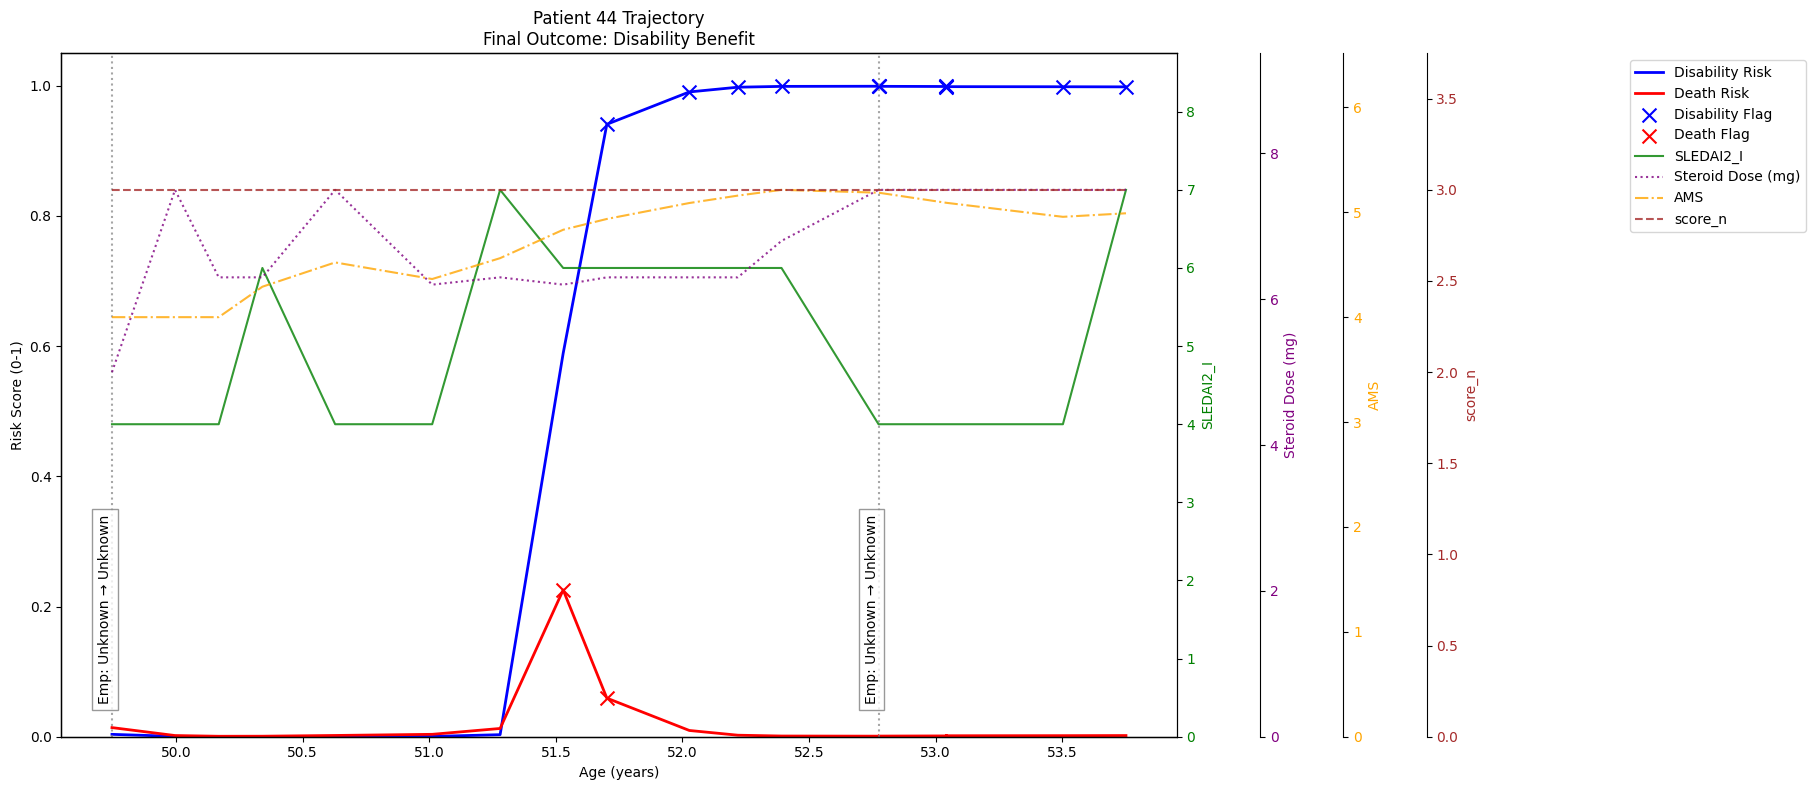

In [8]:
def plot_patient_trajectory(patient_data, risk_df, ptno, data_orig):
    """
    Plot individual patient trajectory with:
    - Risk scores (left axis)
    - Clinical variables (right axes, properly unscaled)
    - Flare events from original data
    - Disability onset marker
    - Detailed employment transition markers
    """
    # Known variable ranges for reference
    VAR_RANGES = {
        'SLEDAI2_I': (0, 105),
        'STERDOSE': (0, 100),
        'AMS': (0, 4),
        'score_n': (0, 1)
    }

    # Employment status mapping
    EMP_STATUS = {
        0: 'Unemployed',
        1: 'Employed',
        2: 'Sick Leave',
        3: 'Retired',
        4: 'Disabled'
    }

    # Prepare data
    patient_data = patient_data.copy()
    risk_df = risk_df.copy()
    patient_data['ASSDT'] = pd.to_datetime(patient_data['ASSDT'])
    risk_df['visit_date'] = pd.to_datetime(risk_df['visit_date'])

    # Get original values including employment history
    orig_values = data_orig[data_orig['PTNO'] == ptno].sort_values('ASSDT')
    orig_values = orig_values[orig_values['ASSDT'].isin(patient_data['ASSDT'])]

    # Merge all data
    merged = pd.merge(patient_data, risk_df,
                     left_on='ASSDT',
                     right_on='visit_date',
                     how='left')

    # Add original values including flares and employment
    for col in ['SLEDAI2_I', 'STERDOSE', 'AMS', 'score_n', 'severe_flare', 'mild_flare', 'EMP']:
        if col in orig_values.columns:
            value_map = dict(zip(orig_values['ASSDT'], orig_values[col]))
            merged[col+'_orig'] = merged['ASSDT'].map(value_map)

    # Calculate patient age
    birth_date = pd.to_datetime(merged['BIRTHDT'].iloc[0])
    merged['age'] = (merged['ASSDT'] - birth_date).dt.days / 365.25

    # Create figure with multiple axes
    fig, ax = plt.subplots(figsize=(20, 8))

    # Create right axes for clinical variables
    ax_right_vars = {}
    colors = ['green', 'purple', 'orange', 'brown']
    for i, col in enumerate(['SLEDAI2_I_orig', 'STERDOSE_orig', 'AMS_orig', 'score_n_orig']):
        if col in merged.columns:
            ax_right = ax.twinx()
            ax_right.spines['right'].set_position(('outward', i*60))
            ax_right_vars[col] = ax_right

            # Set y-axis with 25% margin
            max_val = merged[col].max()
            upper_limit = max_val * 1.25 if max_val > 0 else 1.25
            ax_right.set_ylim(0, upper_limit)

            # Plot and label
            var_name = col.replace('_orig', '')
            label = 'Steroid Dose (mg)' if var_name == 'STERDOSE' else var_name
            ax_right.plot(merged['age'], merged[col],
                         label=label, color=colors[i],
                         linestyle=['-',':','-.','--'][i], alpha=0.8)
            ax_right.set_ylabel(label, color=colors[i])
            ax_right.tick_params(axis='y', labelcolor=colors[i])

    # Plot risk scores
    ax.plot(merged['age'], merged['disability_risk'],
           label='Disability Risk', color='blue', linewidth=2)
    ax.plot(merged['age'], merged['death_risk'],
           label='Death Risk', color='red', linewidth=2)

    # Mark flares
    for flare_type, color, y_pos in [('severe', 'darkred', 1.02), ('mild', 'gold', 1.0)]:
        col = f'{flare_type}_flare_orig'
        if col in merged.columns:
            flares = merged[merged[col] == 1]
            if not flares.empty:
                ax.scatter(flares['age'], [y_pos]*len(flares),
                          color=color, marker='v', s=100, label=f'{flare_type.title()} Flare')

    # Mark risk flags
    for risk_type, color in [('disability', 'blue'), ('death', 'red')]:
        col = f'{risk_type}_flagged'
        if col in merged.columns:
            flags = merged[merged[col]]
            if not flags.empty:
                ax.scatter(flags['age'], flags[f'{risk_type}_risk'],
                          color=color, marker='x', s=100, label=f'{risk_type.title()} Flag')

    # Mark employment transitions
    if 'EMP_orig' in merged.columns:
        emp_changes = merged[merged['EMP_orig'].ne(merged['EMP_orig'].shift())]
        for _, row in emp_changes.iterrows():
            prev_emp = EMP_STATUS.get(merged.loc[row.name-1, 'EMP_orig'] if row.name > 0 else None, 'Unknown')
            new_emp = EMP_STATUS.get(row['EMP_orig'], 'Unknown')
            label = f"Emp: {prev_emp} → {new_emp}"

            ax.axvline(x=row['age'], color='gray', linestyle=':', alpha=0.7)
            ax.text(row['age'], 0.05, label, rotation=90, va='bottom', ha='right',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Mark disability onset
    if 'end_state' in orig_values.columns:
        disability_dates = orig_values[orig_values['end_state'] == 'Disabled']['ASSDT']
        if not disability_dates.empty:
            disability_age = (disability_dates.iloc[0] - birth_date).days / 365.25
            ax.axvline(x=disability_age, color='blue', linestyle='--',
                      linewidth=2, label='Disability Onset')
            ax.text(disability_age, 0.95, 'Disability Onset',
                   rotation=90, va='top', ha='right', color='blue')

    # Formatting
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Risk Score (0-1)', color='black')
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='y', colors='black')

    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    for ax_right in ax_right_vars.values():
        lines_right, labels_right = ax_right.get_legend_handles_labels()
        lines += lines_right
        labels += labels_right

    ax.legend(lines, labels, bbox_to_anchor=(1.4, 1), loc='upper left')

    plt.title(f'Patient {ptno} Trajectory\nFinal Outcome: {merged["end_state"].iloc[-1] if "end_state" in merged.columns else "Unknown"}')
    plt.tight_layout()
    plt.show()

# Load original data with proper date parsing
data_orig = pd.read_csv('sledatacutsdi.csv',
                       parse_dates=['ASSDT', 'BIRTHDT'],
                       low_memory=False)

# Example usage
if __name__ == "__main__":
    # Get example patient who became disabled
    case_patient = results_df[results_df['final_outcome'] == 0].iloc[0]
    ptno = case_patient['PTNO']

    patient_data = data[data['PTNO'] == ptno].sort_values('ASSDT')
    risk_df = assess_patient_risk_with_early_warning(
        patient_data,
        final_model,
        selected_features,
        max_seq_length,
        disability_threshold=thresholds['disability'],
        death_threshold=thresholds['death']
    )

    plot_patient_trajectory(patient_data, risk_df, ptno, data_orig)

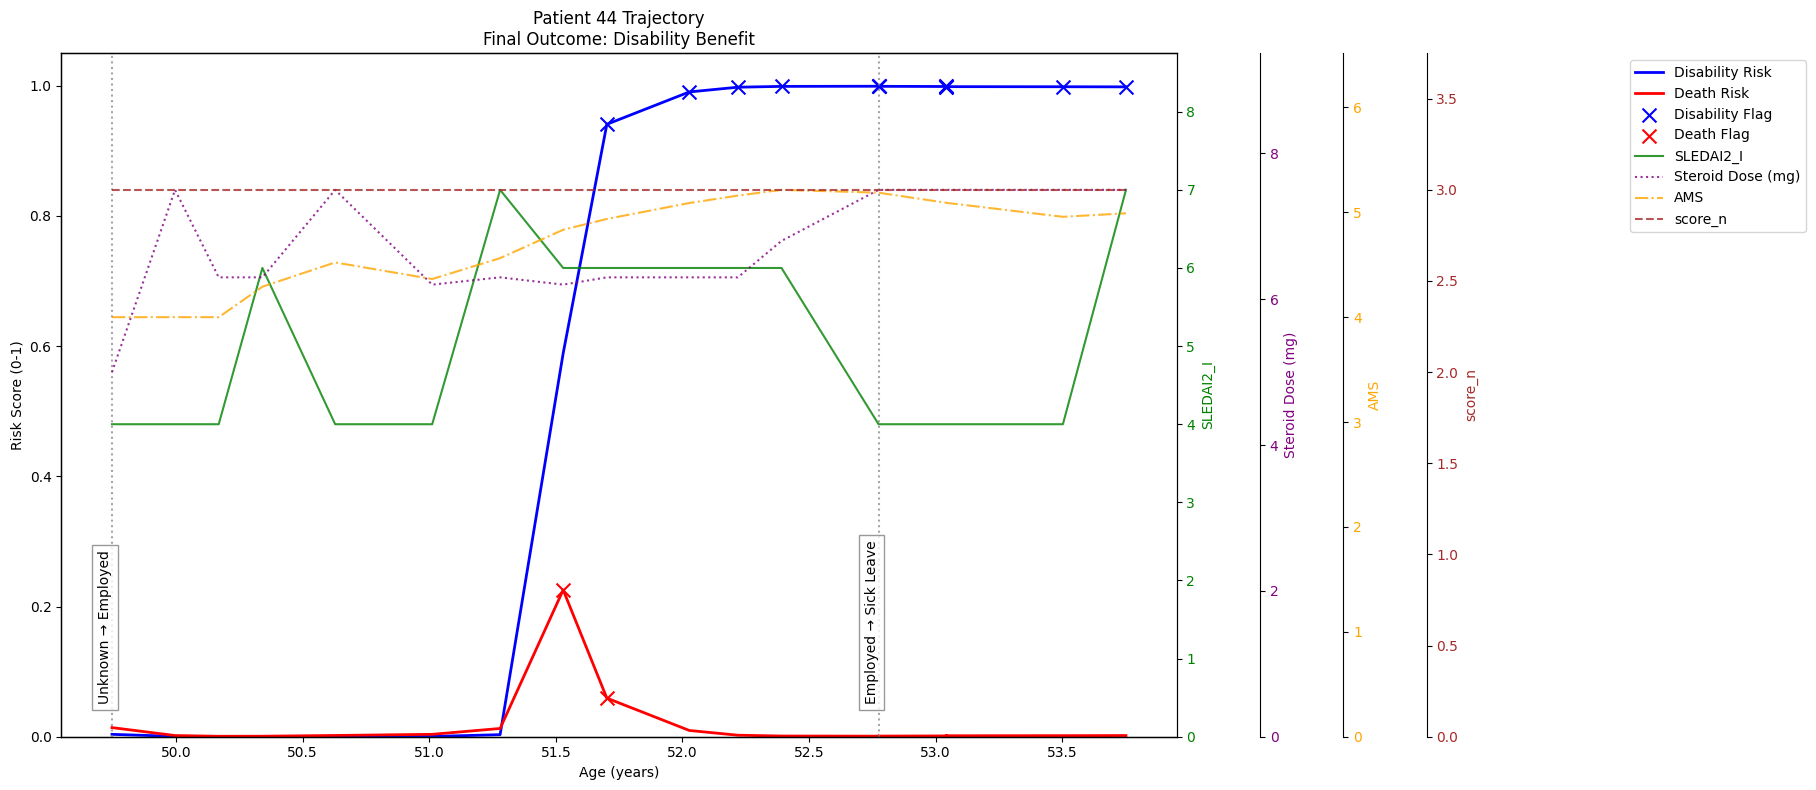

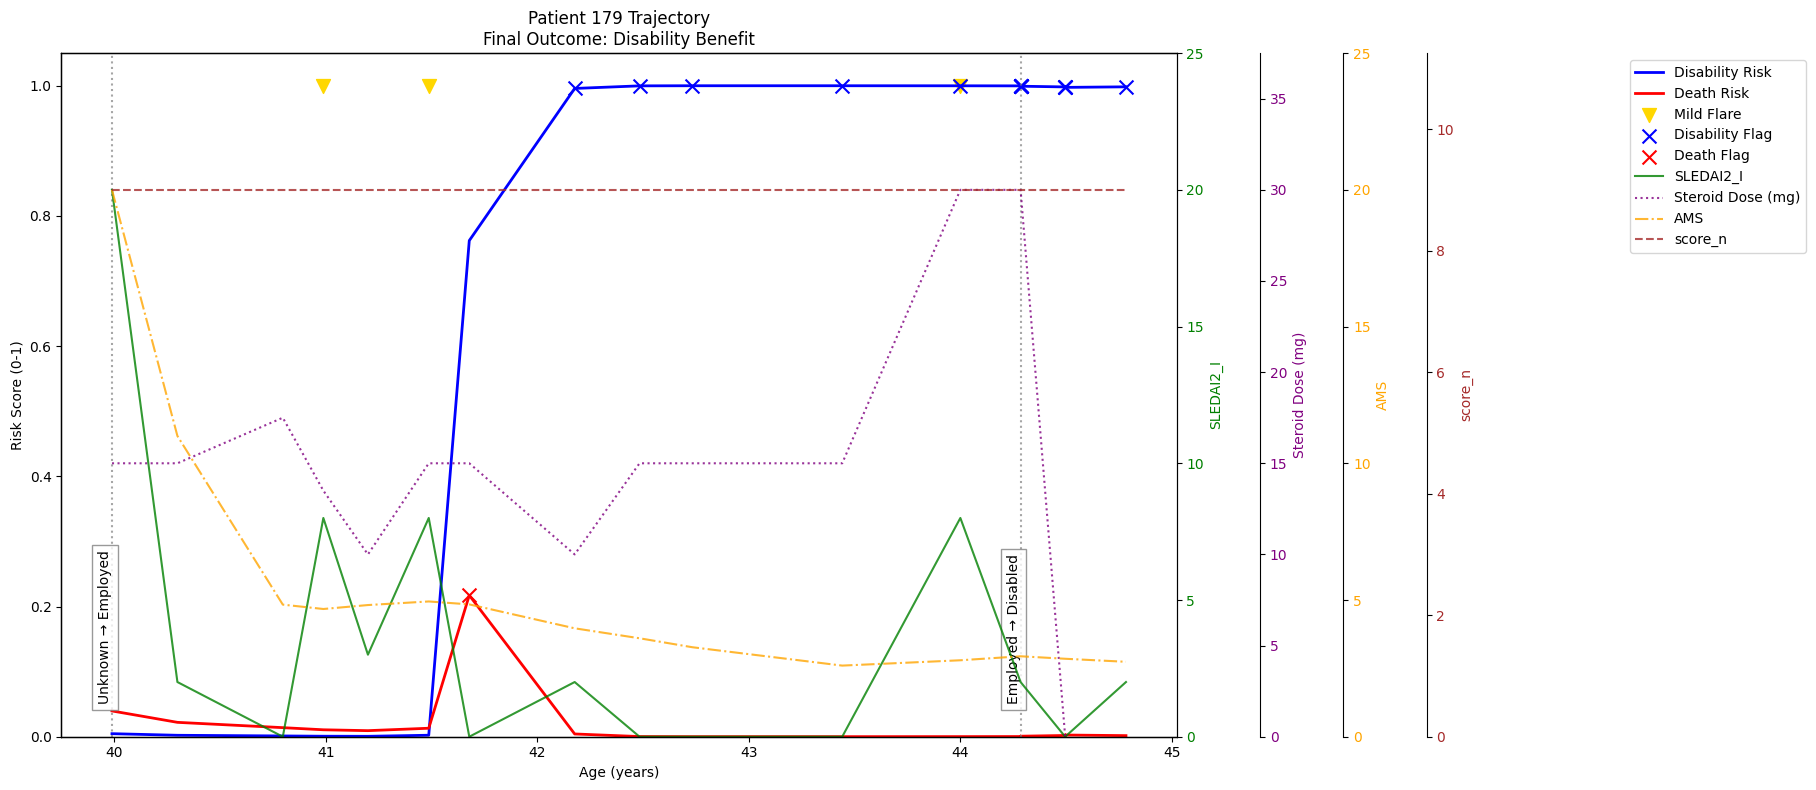

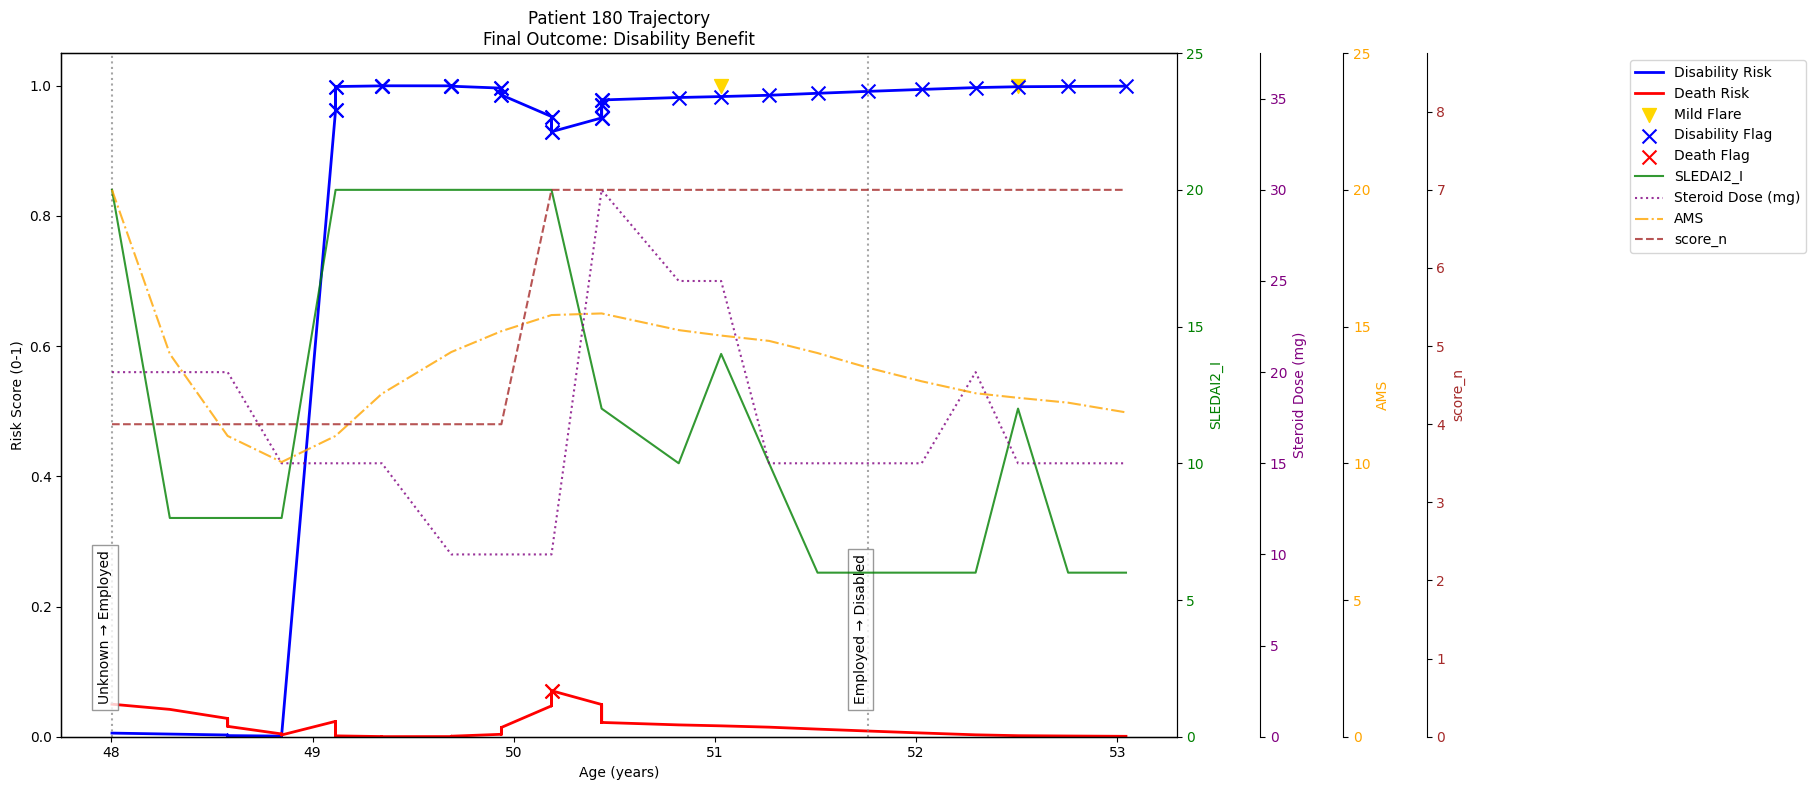

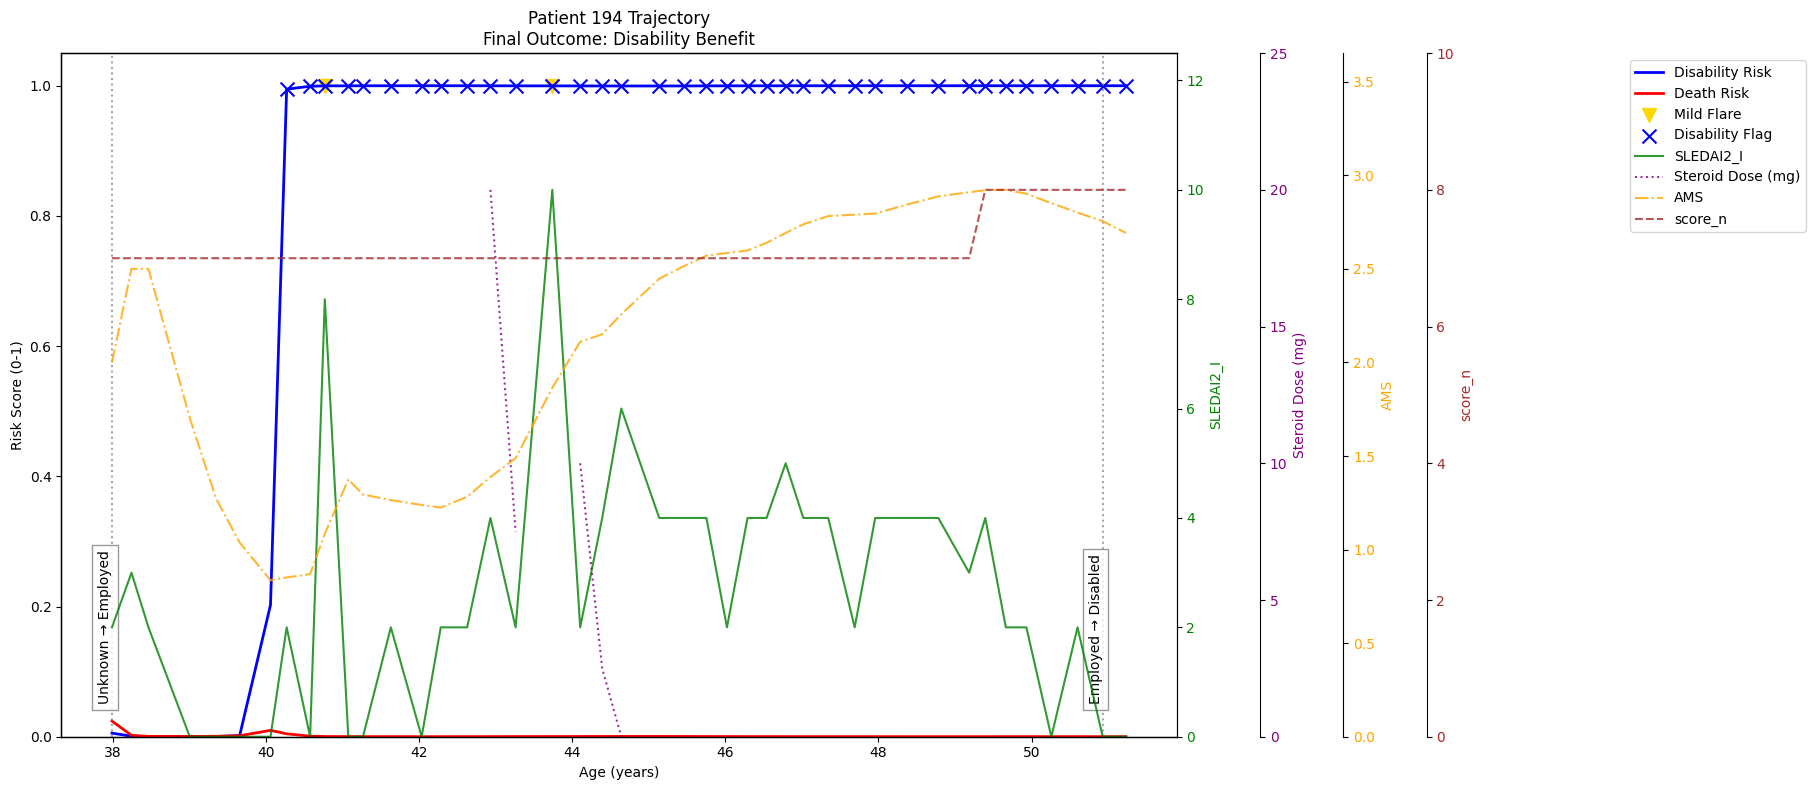

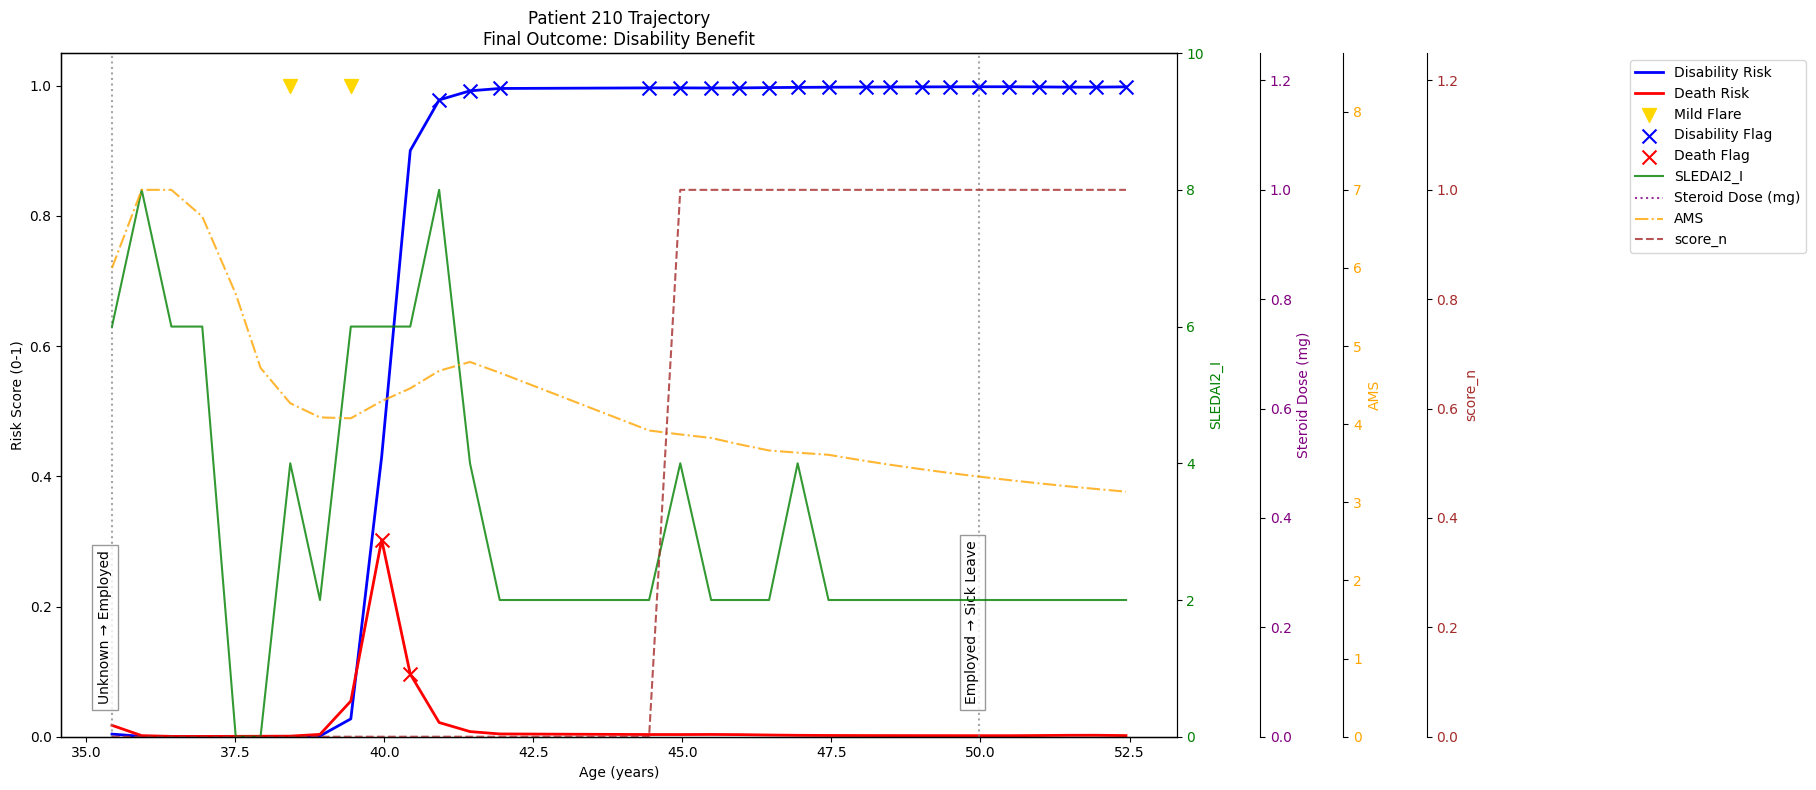

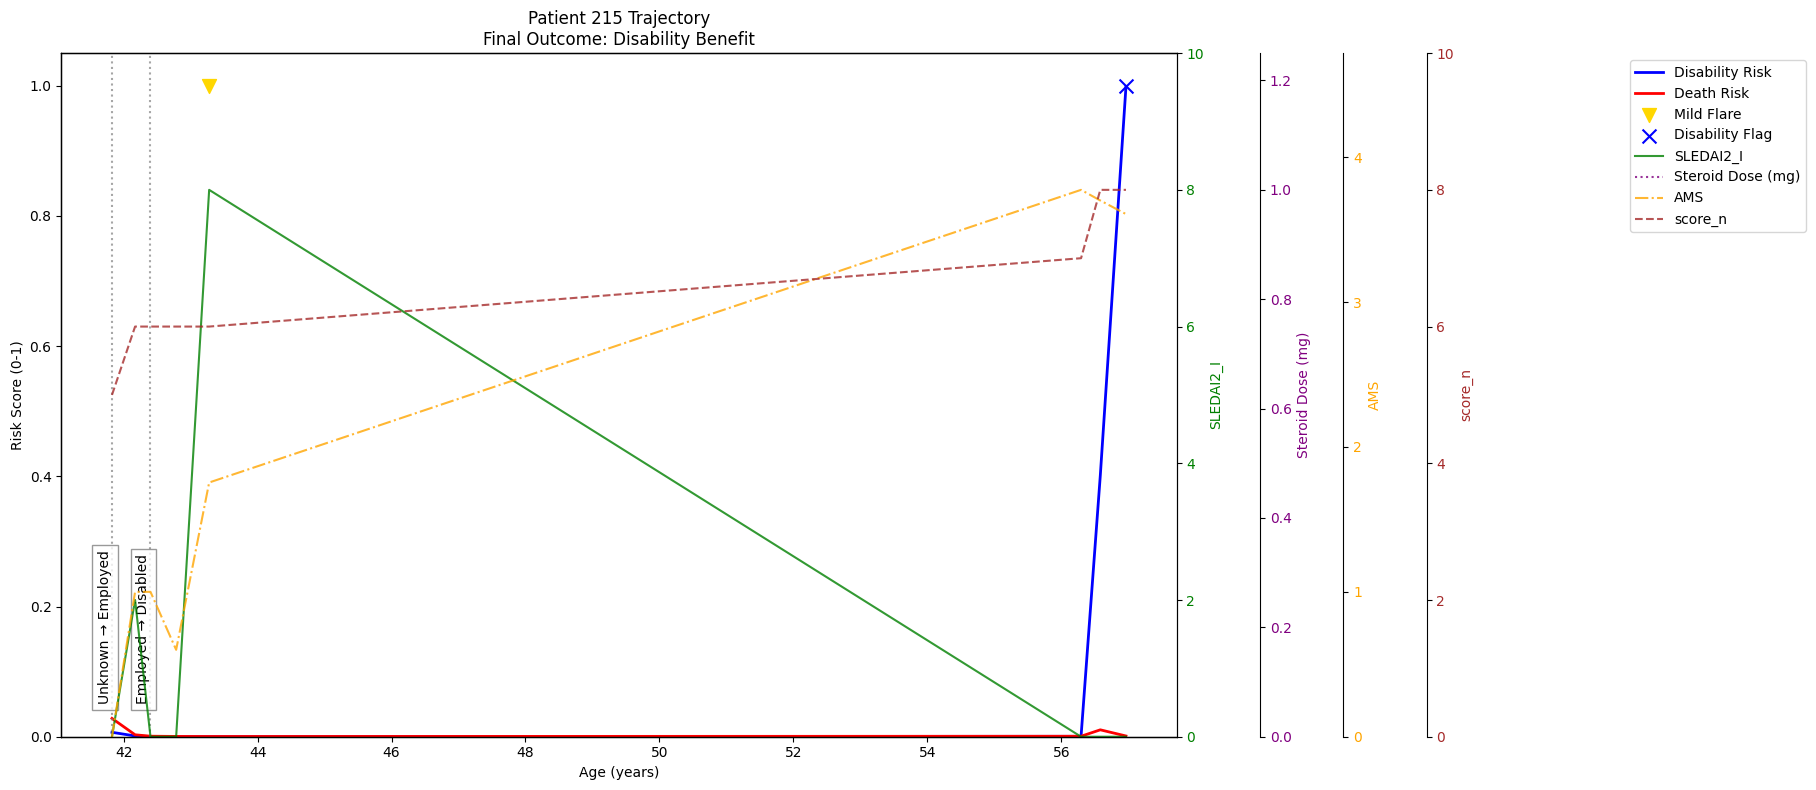

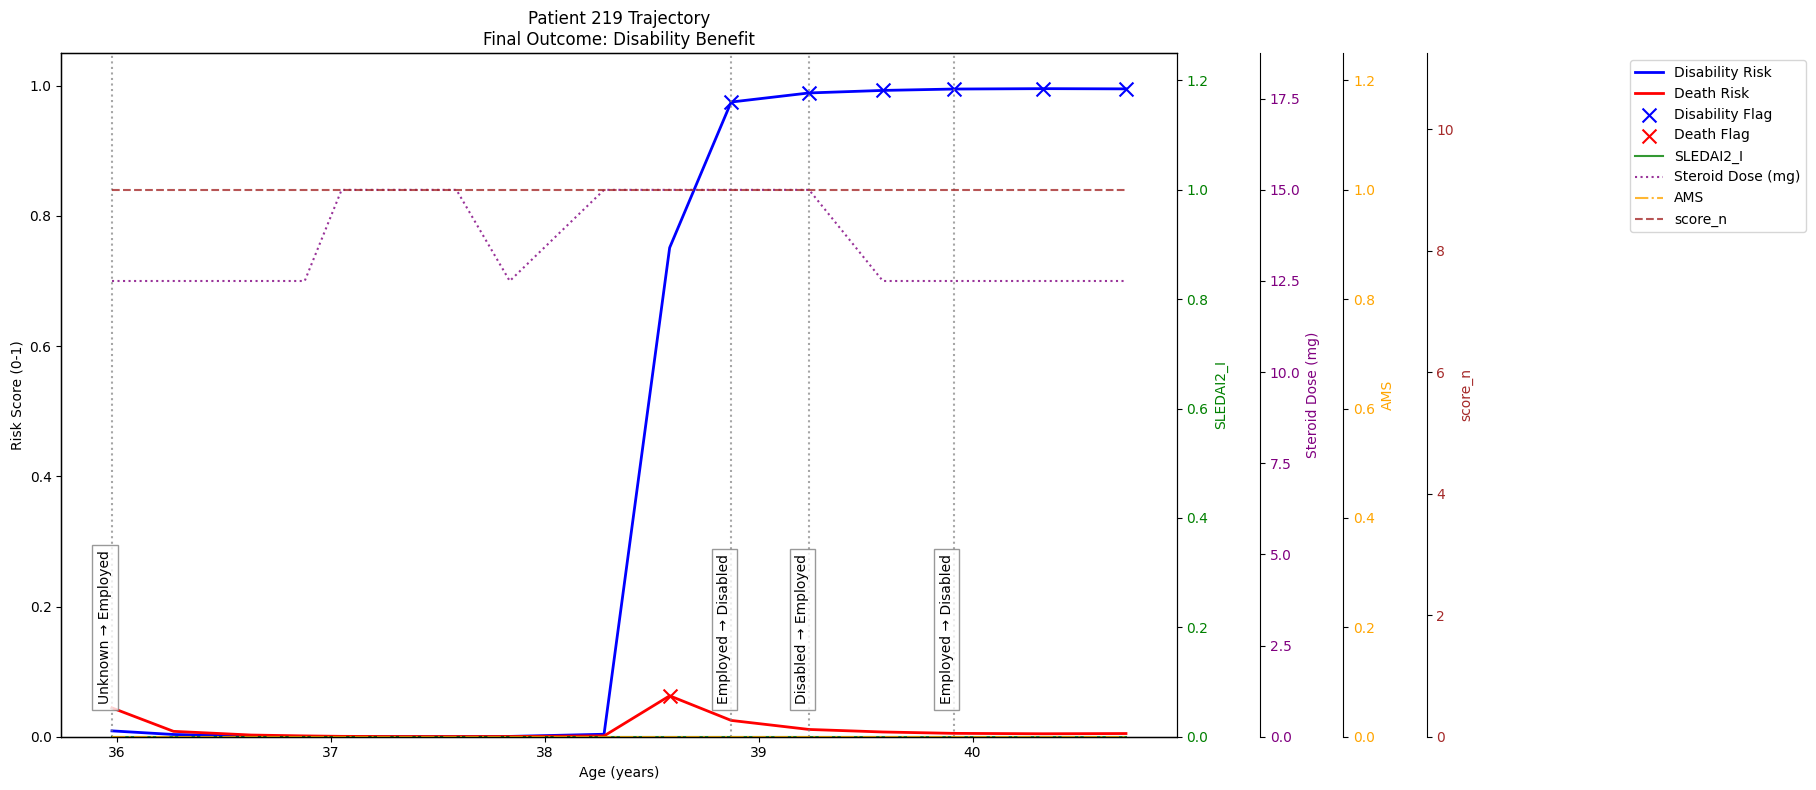

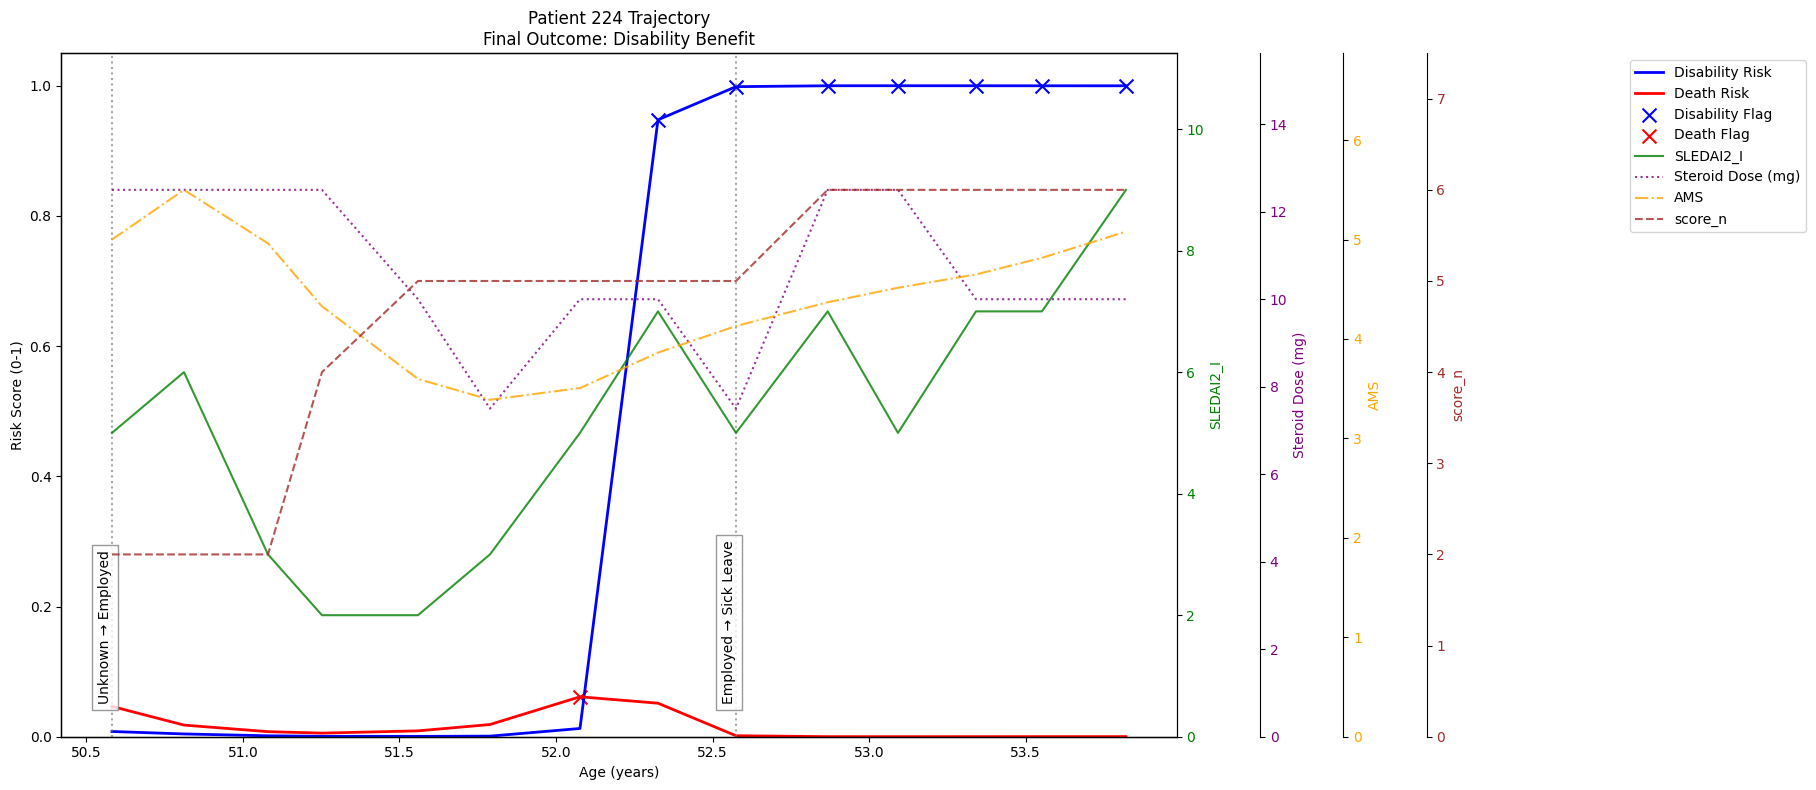

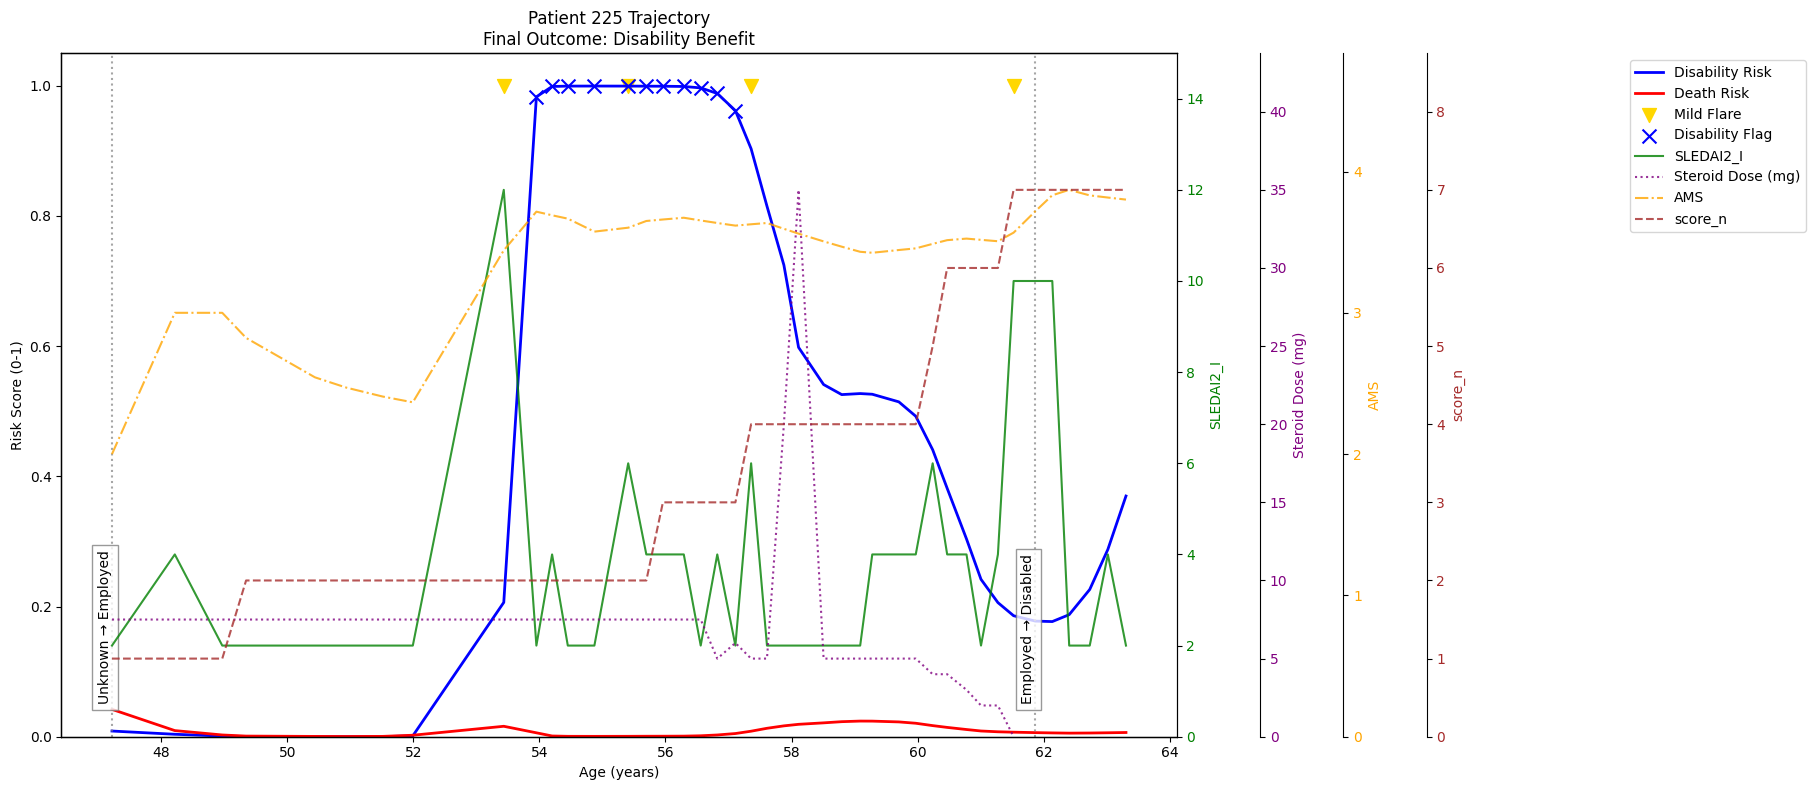

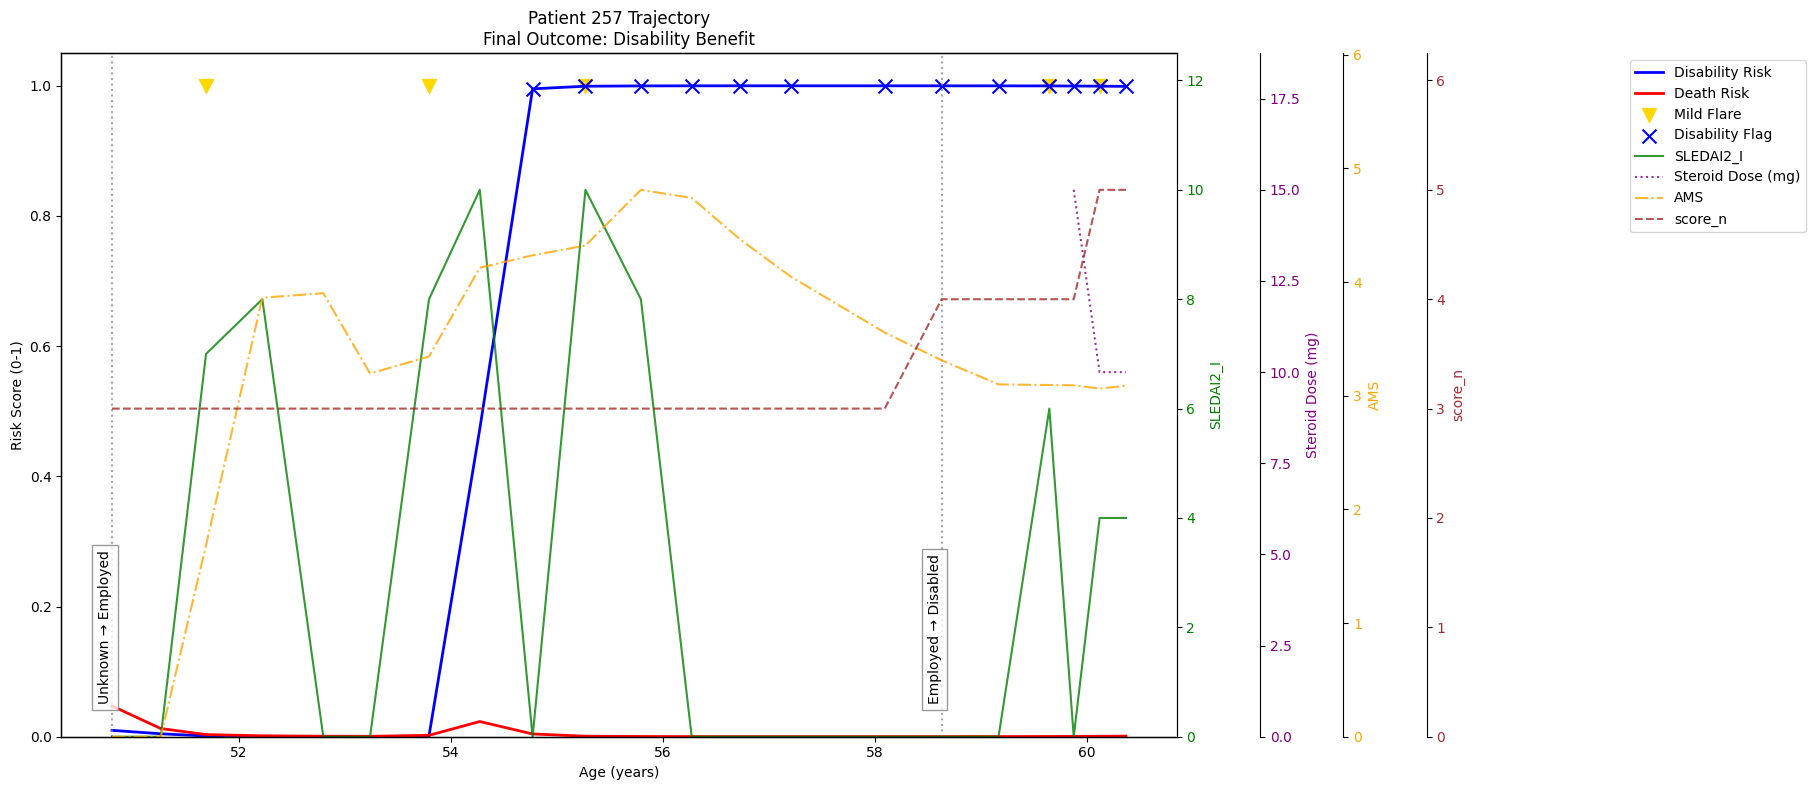

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_patient_trajectory(patient_data, risk_df, ptno, data_orig):
    """
    Plot individual patient trajectory with:
    - Risk scores (left axis)
    - Clinical variables (right axes, properly unscaled with 25% upper margin)
    - Flare events extracted directly from original data
    - Clear disability onset marker
    - Detailed employment transitions with labels
    """
    # Employment status mapping
    EMP_STATUS_MAP = {
        "disabled": "Disabled",
        "sick leave": "Sick Leave",
        "homemaker": "Homemaker",
        "retired": "Retired",
        "student": "Student",
        "looking for work": "Looking for Work",
        "employed": "Employed"
    }

    # Prepare data
    patient_data = patient_data.copy()
    risk_df = risk_df.copy()
    patient_data['ASSDT'] = pd.to_datetime(patient_data['ASSDT'])
    risk_df['visit_date'] = pd.to_datetime(risk_df['visit_date'])

    # Get original values including employment
    orig_values = data_orig[data_orig['PTNO'] == ptno].sort_values('ASSDT')
    orig_values = orig_values[orig_values['ASSDT'].isin(patient_data['ASSDT'])]

    # Extract and map employment status from original data
    if 'EMP' in orig_values.columns:
        orig_values['EMP_status'] = orig_values['EMP'].str.lower().map(EMP_STATUS_MAP)
        orig_values['EMP_status'] = orig_values['EMP_status'].fillna('Unknown')

    # Merge all data
    merged = pd.merge(patient_data, risk_df,
                     left_on='ASSDT',
                     right_on='visit_date',
                     how='left')

    # Add original values including flares
    for col in ['SLEDAI2_I', 'STERDOSE', 'AMS', 'score_n', 'severe_flare', 'mild_flare']:
        if col in orig_values.columns:
            value_map = dict(zip(orig_values['ASSDT'], orig_values[col]))
            merged[col+'_orig'] = merged['ASSDT'].map(value_map)

    # Add employment status from original data
    if 'EMP_status' in orig_values.columns:
        emp_map = dict(zip(orig_values['ASSDT'], orig_values['EMP_status']))
        merged['EMP_status'] = merged['ASSDT'].map(emp_map)

    # Calculate patient age
    birth_date = pd.to_datetime(merged['BIRTHDT'].iloc[0])
    merged['age'] = (merged['ASSDT'] - birth_date).dt.days / 365.25

    # Create figure with multiple axes
    fig, ax = plt.subplots(figsize=(20, 8))

    # Create right axes for each clinical variable
    ax_right_vars = {}
    colors = ['green', 'purple', 'orange', 'brown']
    for i, col in enumerate(['SLEDAI2_I_orig', 'STERDOSE_orig', 'AMS_orig', 'score_n_orig']):
        if col in merged.columns:
            ax_right = ax.twinx()
            ax_right.spines['right'].set_position(('outward', i*60))
            ax_right_vars[col] = ax_right

            # Calculate y-axis with 25% upper margin
            max_val = merged[col].max()
            upper_limit = max_val * 1.25 if max_val > 0 else 1.25
            ax_right.set_ylim(0, upper_limit)

            # Plot and label
            var_name = col.replace('_orig', '')
            label = 'Steroid Dose (mg)' if var_name == 'STERDOSE' else var_name
            ax_right.plot(merged['age'], merged[col],
                         label=label, color=colors[i],
                         linestyle=['-',':','-.','--'][i], alpha=0.8)
            ax_right.set_ylabel(label, color=colors[i])
            ax_right.tick_params(axis='y', labelcolor=colors[i])

    # Plot risk scores on left axis
    ax.plot(merged['age'], merged['disability_risk'],
           label='Disability Risk', color='blue', linewidth=2)
    ax.plot(merged['age'], merged['death_risk'],
           label='Death Risk', color='red', linewidth=2)

    # Mark flare events from original data
    for flare_type, color, y_pos in [('severe', 'darkred', 1.02), ('mild', 'gold', 1.0)]:
        col = f'{flare_type}_flare_orig'
        if col in merged.columns:
            flares = merged[merged[col] == 1]
            if not flares.empty:
                ax.scatter(flares['age'], [y_pos]*len(flares),
                          color=color, marker='v', s=100, label=f'{flare_type.title()} Flare')

    # Mark risk flags
    for risk_type, color in [('disability', 'blue'), ('death', 'red')]:
        col = f'{risk_type}_flagged'
        if col in merged.columns:
            flags = merged[merged[col]]
            if not flags.empty:
                ax.scatter(flags['age'], flags[f'{risk_type}_risk'],
                          color=color, marker='x', s=100, label=f'{risk_type.title()} Flag')

    # Mark employment transitions from original data
    if 'EMP_status' in merged.columns:
        # Find all employment status changes
        emp_changes = merged[merged['EMP_status'].ne(merged['EMP_status'].shift())]

        for idx, row in emp_changes.iterrows():
            prev_status = merged.loc[idx-1, 'EMP_status'] if idx > merged.index[0] else 'Unknown'
            new_status = row['EMP_status']

            # Only label meaningful transitions
            if pd.notna(new_status) and new_status != prev_status:
                label = f"{prev_status} → {new_status}"

                ax.axvline(x=row['age'], color='gray', linestyle=':', alpha=0.7)
                ax.text(row['age'], 0.05, label, rotation=90, va='bottom', ha='right',
                       bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

    # Mark disability onset (using original data)
    if 'end_state' in orig_values.columns:
        disability_dates = orig_values[orig_values['end_state'] == 'Disabled']['ASSDT']
        if not disability_dates.empty:
            disability_age = (disability_dates.iloc[0] - birth_date).days / 365.25
            ax.axvline(x=disability_age, color='blue', linestyle='--',
                      linewidth=2, label='Disability Onset')
            ax.text(disability_age, 0.95, 'Disability Onset',
                   rotation=90, va='top', ha='right', color='blue',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue'))

    # Formatting
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Risk Score (0-1)', color='black')
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='y', colors='black')

    # Combine legends
    lines, labels = ax.get_legend_handles_labels()
    for ax_right in ax_right_vars.values():
        lines_right, labels_right = ax_right.get_legend_handles_labels()
        lines += lines_right
        labels += labels_right

    ax.legend(lines, labels, bbox_to_anchor=(1.4, 1), loc='upper left')

    plt.title(f'Patient {ptno} Trajectory\nFinal Outcome: {merged["end_state"].iloc[-1] if "end_state" in merged.columns else "Unknown"}')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your data
    data_orig = pd.read_csv('sledatacutsdi.csv',
                          parse_dates=['ASSDT', 'BIRTHDT'],
                          low_memory=False)


    # Get example patient who became disabled
    case_patients = results_df[results_df['final_outcome'] == 0]
    for i in range(len(case_patients[:10])):
        ptno = case_patients.iloc[i]['PTNO']

        patient_data = data[data['PTNO'] == ptno].sort_values('ASSDT')
        risk_df = assess_patient_risk_with_early_warning(
            patient_data,
            final_model,
            selected_features,
            max_seq_length,
            disability_threshold=thresholds['disability'],
            death_threshold=thresholds['death']
        )

        plot_patient_trajectory(patient_data, risk_df, ptno, data_orig)